# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, multiply, Reshape, Embedding, Dropout, UpSampling2D, MaxPooling2D, BatchNormalization, Concatenate, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy


from sklearn.preprocessing import LabelBinarizer

# Dataset Load

We download MNIST dataset, consisting of 60.000 images of 28x28 pixels resolution. Each image defines a handwritten number in greyscale.

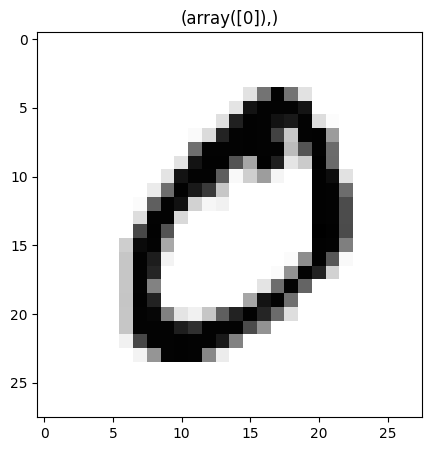

(60000, 28, 28)


In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

y_train = LabelBinarizer().fit_transform(y_train)
y_test = LabelBinarizer().fit_transform(y_test)

plt.imshow(X_train[1], cmap = 'Greys')
plt.title(np.where(y_train[1]==1))
plt.show()
print(X_train.shape)

## Preprocessing data

The pixels in the source image are within the range [0, 256] we will normalize this range to [-1, 1] in order to treat this information with neural networks.

In [ ]:
X_train = X_train.astype('float32')/127.5 -1

X_train = np.expand_dims(X_train, axis=3)

# Train 1

## Generator definition

> Voy a utilizar el mismo número de capas convulucionales, el mismo tipo de función de activación y la misma estrategía de regulación que he utilizado en mi mejor DCGAN de la parte 1, tanto para el generador como para el discriminador. Por otro lado, añadiré lo necesario para construir la ACGAN en base a los comentarios, apoyandome de su arquitectura y de internet.

In [ ]:
def create_generator():
    # Introducir una nueva entrada input_label y concatenerla con input_z para formar la entrada de la red
    input_z = Input(shape=(100,))
    input_label = Input(shape=(10,))

    # Cambiar el modelo para que ahora admita las dos entradas

    x = Concatenate(axis=-1)([input_z,input_label])

    x = Dense(256 * 7 * 7, activation="relu", input_dim=100)(x)

    x = Reshape((7, 7, 256))(x)


    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.01)(x)

    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.01)(x)

    x = Conv2DTranspose(32, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.01)(x)

    x = Conv2DTranspose(1, kernel_size=3, strides=1, padding="same")(x)
    output = Activation("tanh")(x)



    generator = Model([input_z, input_label], output)

    return generator

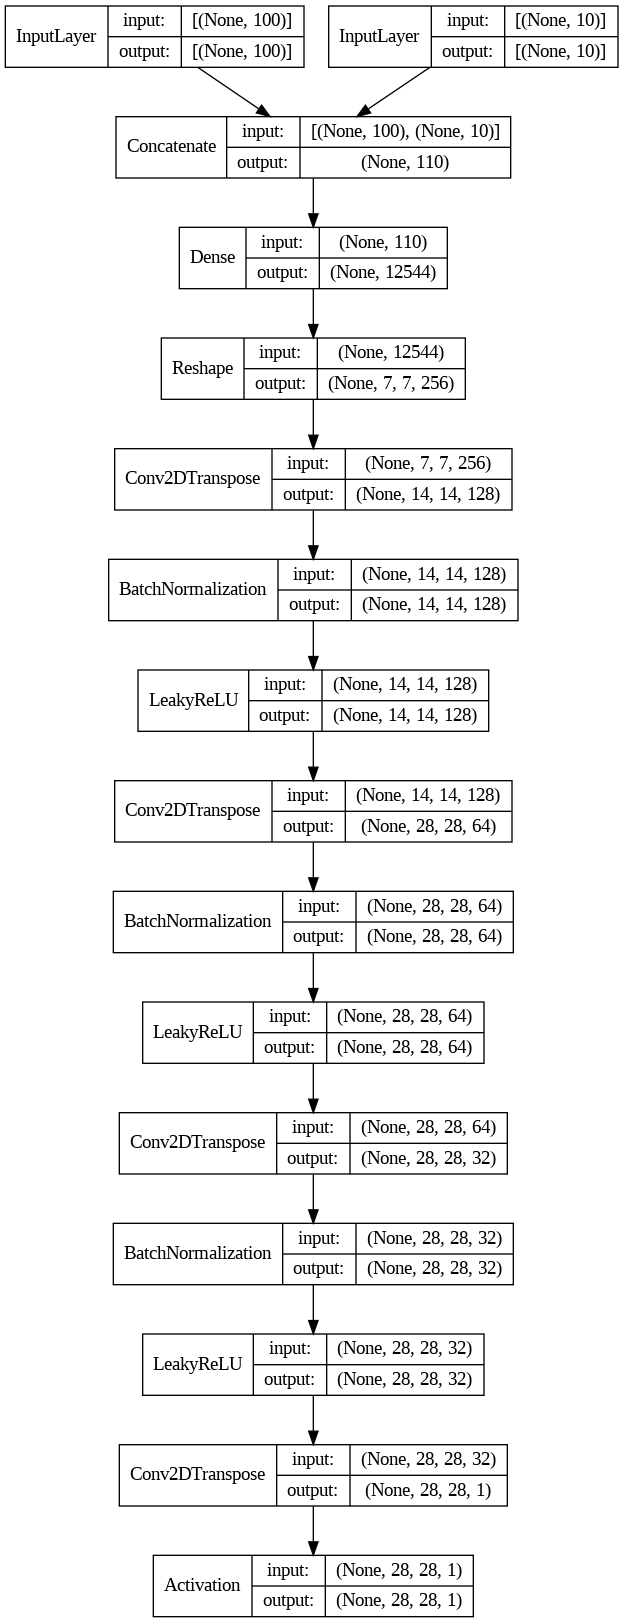

In [ ]:
generator = create_generator()
plot_model(generator, show_shapes=True, show_layer_names=False)

## Discriminator definition

In [ ]:
def create_discriminator():
    input = Input(shape=(28,28,1))

    x = Conv2D(32, kernel_size=5, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.01)(x)

    x = Dropout(0.2)(x)

    x = Conv2D(64, kernel_size=5, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.01)(x)

    x = Dropout(0.2)(x)

    x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)

    x = Dropout(0.2)(x)

    x = Flatten()(x)

    disc_output = Dense(1,activation='sigmoid')(x)
    class_output = Dense(10,activation='softmax')(x)

    discriminator = Model(input, [disc_output,class_output])

    return discriminator

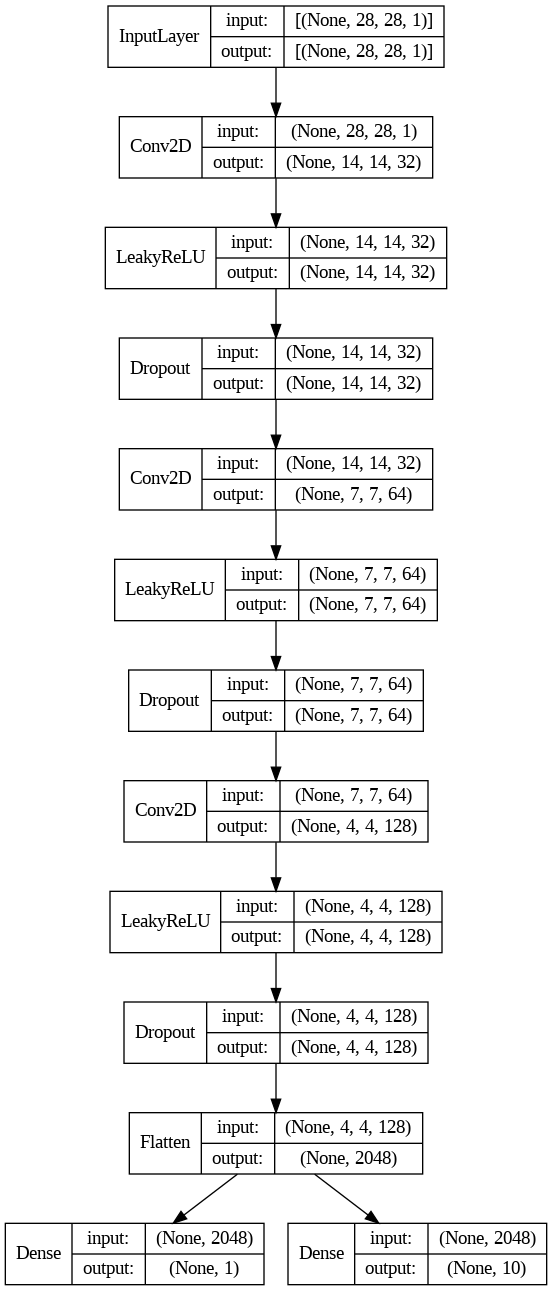

In [ ]:
discriminator = create_discriminator()
plot_model(discriminator, show_shapes=True, show_layer_names=False)

## GAN model definition

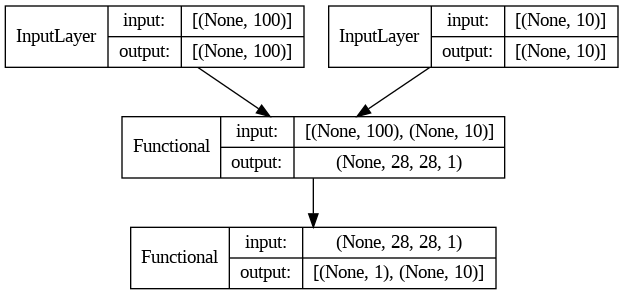

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
discriminator.trainable = False

z = Input(shape=(100,))
# Crear una nueva entrada label que tenga tantas dimensiones como clases
label = Input(shape=(10,))

# Introducir al generador las entradas z y label al mismo tiempo
img = generator([z,label])

# Obtener del discriminador las salidas validity y target_label a la vez
validity, target_label = discriminator(img)


# Modificar combined para que el modelo admita ambas entradas y salidas
combined = Model([z, label], [validity,target_label])
# Compilar el modelo para que ahora tenga 2 funciones de pérdida:
    # binary_crossentropy: para la salida de validez
    # categorical_crossentropy: para la salida de clasificación de etiqueta
combined.compile(loss= ['binary_crossentropy', 'categorical_crossentropy'], optimizer=Adam(learning_rate=0.0001))

plot_model(combined, show_shapes=True, show_layer_names=False)

## Training

In [ ]:
def generate_random_labels(batch_size, array_length):
    batch = []
    for _ in range(batch_size):
        arr = np.zeros(array_length)

        random_position = random.randint(0, array_length - 1)
        arr[random_position] = 1

        batch.append(arr)

    return np.array(batch)

In [ ]:
def train(X_train, y_train, generator, discriminator, combined, epochs, batch_size=32, sample_interval=100):
    # Adversarial ground truths (-1 fake and 1 real)
    valid = np.ones((batch_size, 1))

    fake = np.zeros((batch_size, 1))

    history = {
        'd_loss' : [],
        'd_acc' : [],
        'g_loss' : []
    }

    for epoch in range(epochs):
        print("----EPOCH " + str(epoch) + '-----')
        for batch in range(int(len(X_train)/batch_size)):
            #  Train the Discriminator
            noise = np.random.normal(0, 1, (batch_size, 100))
            # Generar un batch de etiquetas de manera aleatoria
            gen_labels=generate_random_labels(batch_size,10)

            # El generador ahora deberá admitir el noise la mismo tiempo que los gen_labels generados aleatoriamente
            gen_imgs = generator.predict([noise, gen_labels],verbose=0)
            imgs = X_train[batch*batch_size : (batch+1)*batch_size]

            # Obtener el batch correspondiente de etiquetas de y_train
            img_labels = y_train[batch * batch_size: (batch + 1) * batch_size]

            # Añadir a las salidas deseadas del discriminador las etiquetas aleatorias y las obtenidas de y_train
            d_loss_real = discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, gen_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the Generator
            noise = np.random.normal(0, 1, (batch_size, 100))
            # Generar un batch de etiquetas de manera aleatoria
            gen_labels2=generate_random_labels(batch_size,10)
            
            # Añadir como entrada y salida las etiquetas generadas
            g_loss = combined.train_on_batch([noise, gen_labels2], [valid, gen_labels2])

            # Save losses
            history['d_loss'].append(d_loss[0])
            history['d_acc'].append(d_loss[3])
            history['g_loss'].append(g_loss)

            # Plot the progress
            if batch % 50 == 0:
                print ("%d [D loss: %.4f,\t acc.: %.2f%%]\t[G loss: %.4f]" % (batch, d_loss[0], 100*d_loss[3], g_loss[0]))

            if batch % 500 == 0:
                sample_images(epoch, batch, gen_imgs, gen_labels, imgs, img_labels)

        plot_losses(history)

## Plotting functions

In [ ]:
def sample_images(epoch, batch, gen_imgs, gen_labels, imgs, img_labels):
    plt.rcParams['figure.figsize'] = [25, 5]
    fig, axs = plt.subplots(2, 10)
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=16)
    for i in range(10):
        axs[0,i].imshow(gen_imgs[i,:,:,0], cmap='Greys')
        axs[0,i].set_title(np.where(gen_labels[i]==1))
        axs[0,i].axis('off')

    for i in range(10):
        axs[1,i].imshow(imgs[i,:,:,0], cmap='Greys')
        axs[1,i].set_title(np.where(img_labels[i]==1))
        axs[1,i].axis('off')
    plt.show()
    plt.close()

In [ ]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()

    ax1.plot(history['d_loss'], label='D loss')
    ax1.plot(history['g_loss'], label='G loss')
    ax1.legend()

    ax2.set_title('D accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()

    ax2.plot(history['d_acc'], label='Accuracy')
    ax2.legend()

    plt.show()

----EPOCH 0-----
0 [D loss: 1.3849,	 acc.: 25.00%]	[G loss: 2.9819]


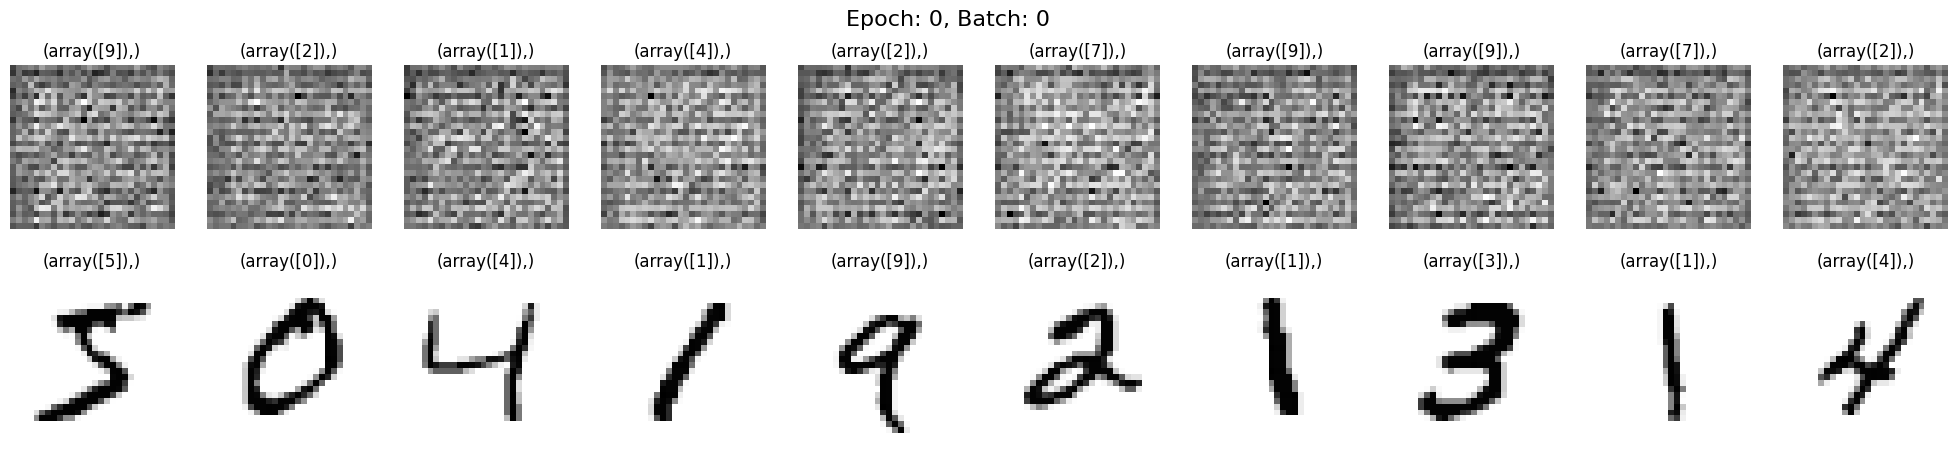

50 [D loss: 0.4785,	 acc.: 100.00%]	[G loss: 4.2334]
100 [D loss: 0.4183,	 acc.: 100.00%]	[G loss: 4.8872]
150 [D loss: 0.4331,	 acc.: 96.88%]	[G loss: 4.8014]
200 [D loss: 0.5293,	 acc.: 90.62%]	[G loss: 4.1509]
250 [D loss: 0.5100,	 acc.: 92.19%]	[G loss: 5.0498]
300 [D loss: 0.4987,	 acc.: 96.88%]	[G loss: 4.5976]
350 [D loss: 0.7426,	 acc.: 84.38%]	[G loss: 3.5827]
400 [D loss: 0.6053,	 acc.: 96.88%]	[G loss: 4.0370]
450 [D loss: 0.3882,	 acc.: 98.44%]	[G loss: 5.3248]
500 [D loss: 0.8243,	 acc.: 70.31%]	[G loss: 3.7221]


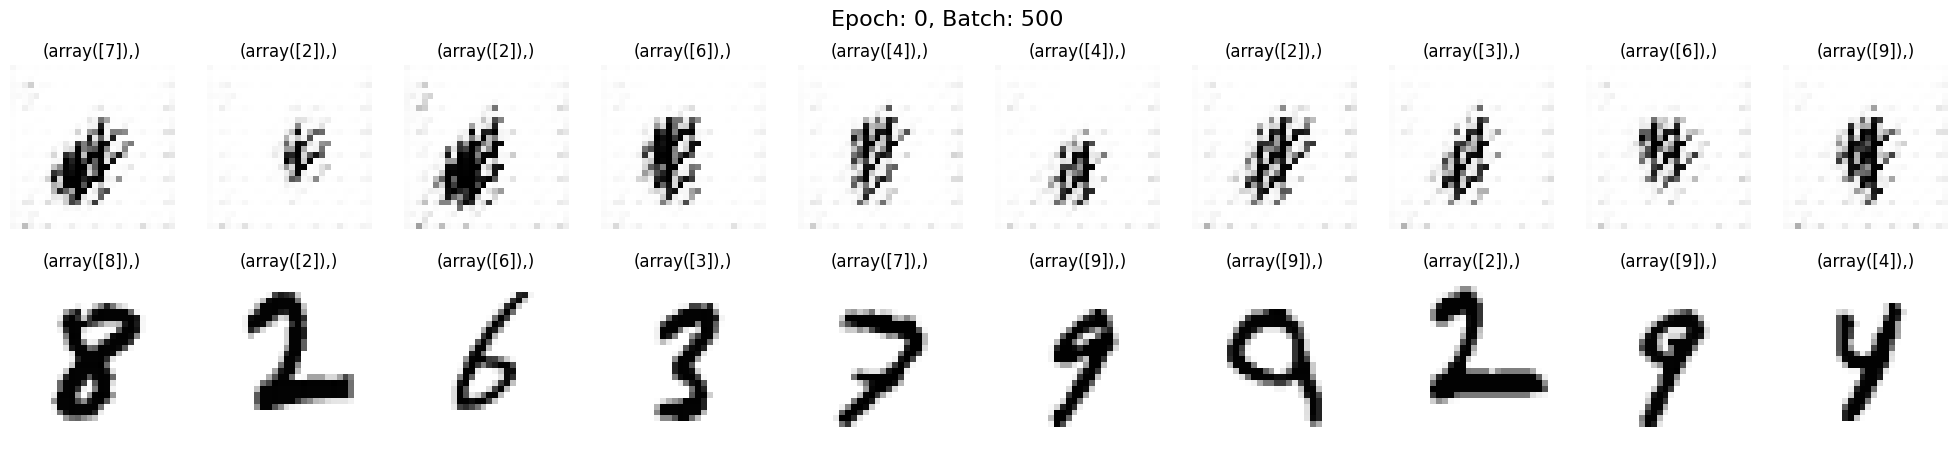

550 [D loss: 0.4401,	 acc.: 95.31%]	[G loss: 4.4710]
600 [D loss: 0.5091,	 acc.: 90.62%]	[G loss: 5.2005]
650 [D loss: 0.6587,	 acc.: 73.44%]	[G loss: 4.1803]
700 [D loss: 0.7515,	 acc.: 76.56%]	[G loss: 3.9092]
750 [D loss: 1.1383,	 acc.: 53.12%]	[G loss: 3.1185]
800 [D loss: 0.8832,	 acc.: 67.19%]	[G loss: 2.8309]
850 [D loss: 1.0146,	 acc.: 51.56%]	[G loss: 2.3425]
900 [D loss: 0.8601,	 acc.: 67.19%]	[G loss: 2.2456]
950 [D loss: 0.9061,	 acc.: 60.94%]	[G loss: 2.0290]
1000 [D loss: 0.8793,	 acc.: 65.62%]	[G loss: 1.7463]


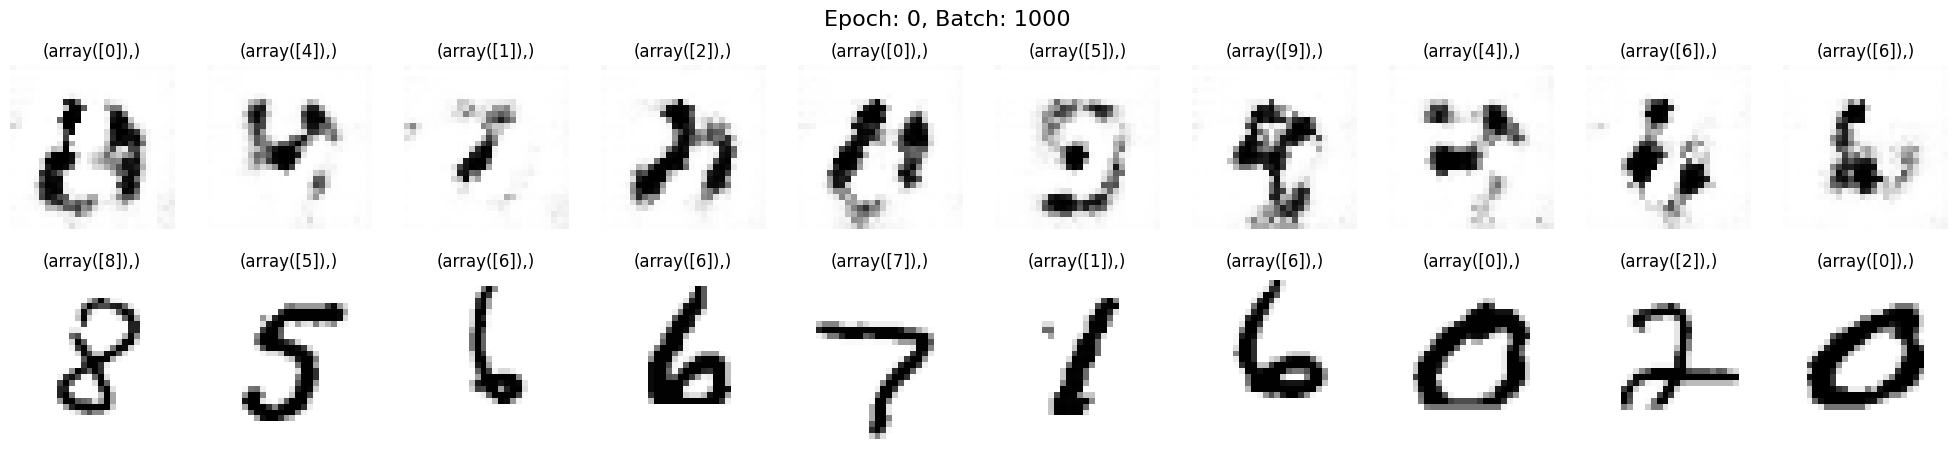

1050 [D loss: 0.8127,	 acc.: 60.94%]	[G loss: 1.6175]
1100 [D loss: 0.7358,	 acc.: 71.88%]	[G loss: 1.5137]
1150 [D loss: 0.9081,	 acc.: 51.56%]	[G loss: 1.1093]
1200 [D loss: 0.8158,	 acc.: 56.25%]	[G loss: 1.1626]
1250 [D loss: 0.7790,	 acc.: 60.94%]	[G loss: 0.9582]
1300 [D loss: 0.8439,	 acc.: 62.50%]	[G loss: 0.9283]
1350 [D loss: 0.7493,	 acc.: 62.50%]	[G loss: 1.1141]
1400 [D loss: 0.7606,	 acc.: 67.19%]	[G loss: 0.9613]
1450 [D loss: 0.7942,	 acc.: 64.06%]	[G loss: 0.9126]
1500 [D loss: 0.8081,	 acc.: 59.38%]	[G loss: 0.8794]


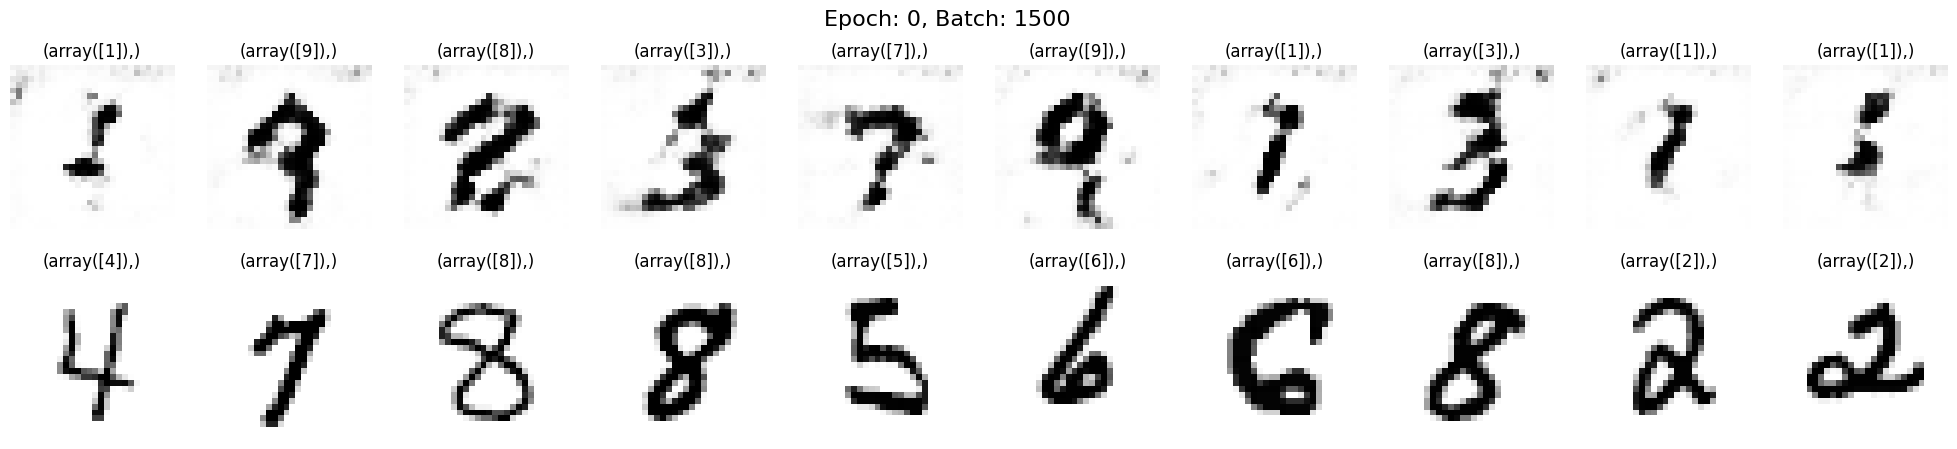

1550 [D loss: 0.8688,	 acc.: 42.19%]	[G loss: 0.7733]
1600 [D loss: 0.8556,	 acc.: 48.44%]	[G loss: 0.8156]
1650 [D loss: 0.7765,	 acc.: 65.62%]	[G loss: 0.8909]
1700 [D loss: 0.7975,	 acc.: 53.12%]	[G loss: 0.8796]
1750 [D loss: 0.7225,	 acc.: 65.62%]	[G loss: 0.9131]
1800 [D loss: 0.8112,	 acc.: 54.69%]	[G loss: 0.8623]
1850 [D loss: 0.7097,	 acc.: 67.19%]	[G loss: 0.8596]


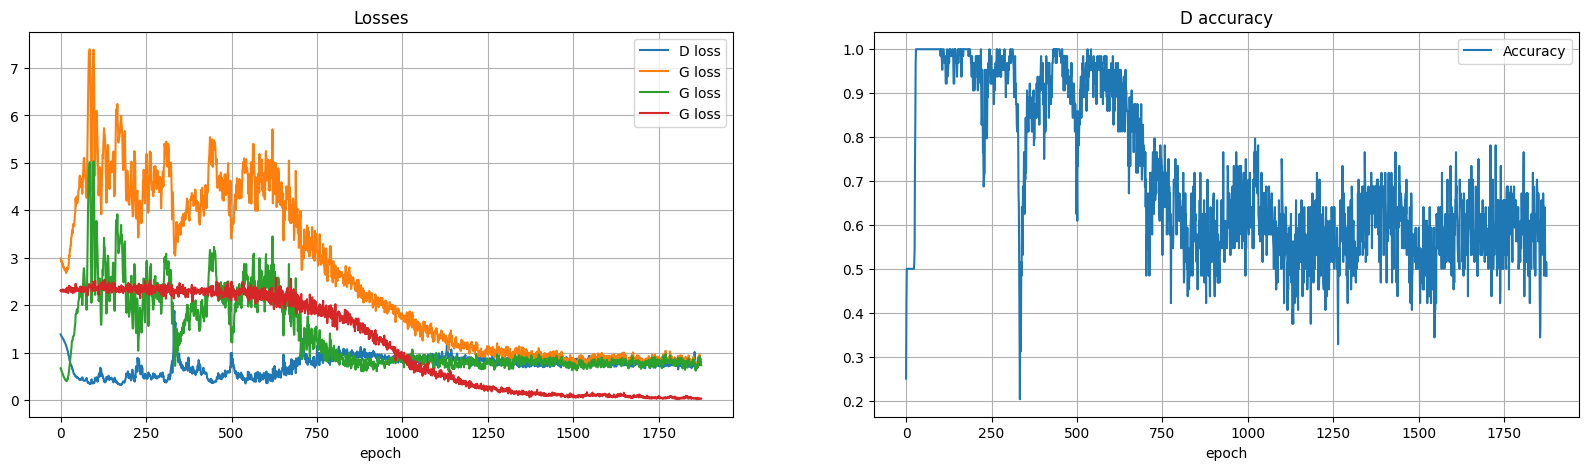

----EPOCH 1-----
0 [D loss: 0.8462,	 acc.: 40.62%]	[G loss: 0.8148]


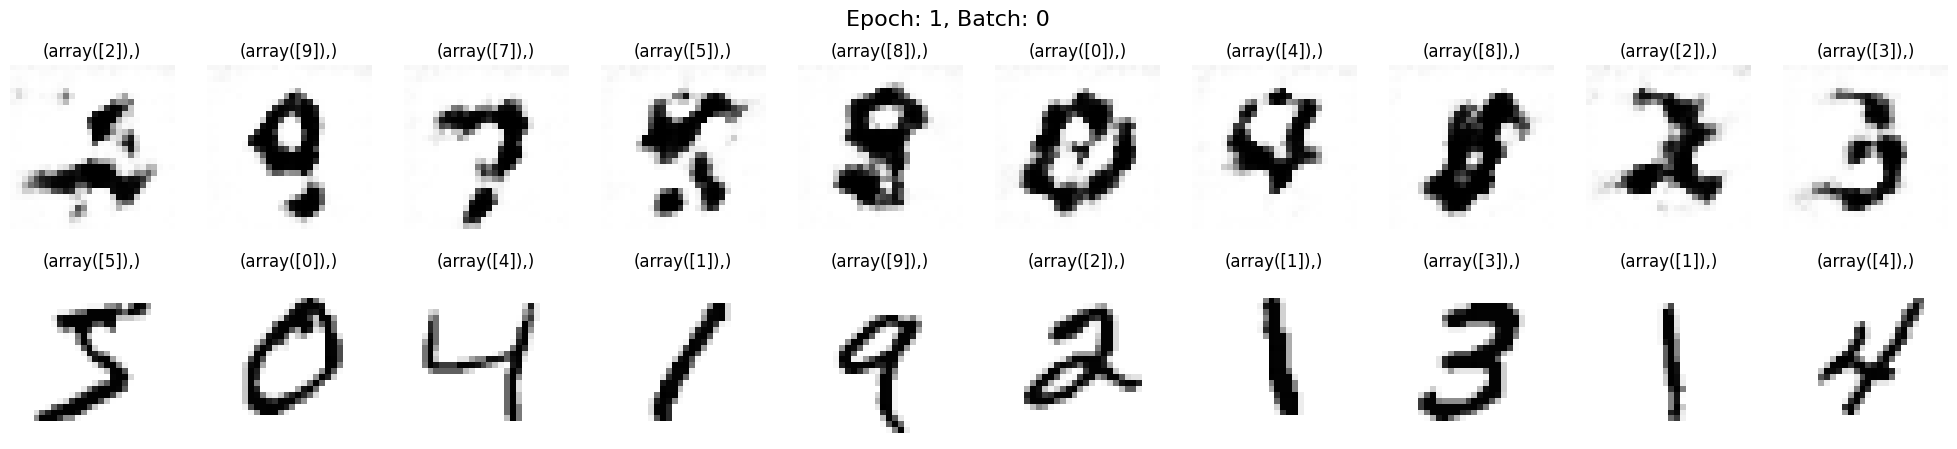

50 [D loss: 0.7356,	 acc.: 62.50%]	[G loss: 0.9147]
100 [D loss: 0.7810,	 acc.: 57.81%]	[G loss: 0.7758]
150 [D loss: 0.7465,	 acc.: 65.62%]	[G loss: 0.7695]
200 [D loss: 0.7612,	 acc.: 56.25%]	[G loss: 0.8595]
250 [D loss: 0.7892,	 acc.: 50.00%]	[G loss: 0.7468]
300 [D loss: 0.7652,	 acc.: 53.12%]	[G loss: 0.8362]
350 [D loss: 0.6845,	 acc.: 71.88%]	[G loss: 0.9620]
400 [D loss: 0.7832,	 acc.: 51.56%]	[G loss: 0.8556]
450 [D loss: 0.7061,	 acc.: 71.88%]	[G loss: 0.7973]
500 [D loss: 0.7962,	 acc.: 56.25%]	[G loss: 0.8314]


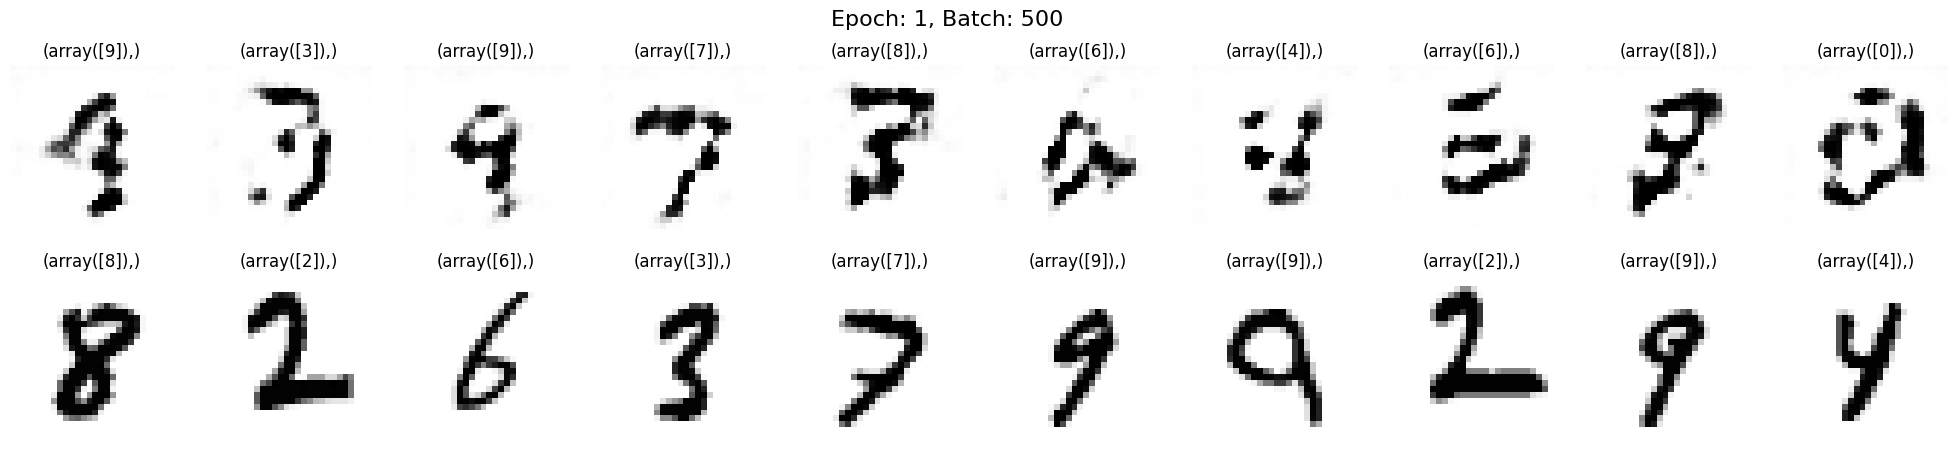

550 [D loss: 0.7503,	 acc.: 54.69%]	[G loss: 0.8321]
600 [D loss: 0.7083,	 acc.: 65.62%]	[G loss: 0.8825]
650 [D loss: 0.6963,	 acc.: 65.62%]	[G loss: 0.7331]
700 [D loss: 0.7081,	 acc.: 67.19%]	[G loss: 0.8125]
750 [D loss: 0.7708,	 acc.: 59.38%]	[G loss: 0.8534]
800 [D loss: 0.6139,	 acc.: 73.44%]	[G loss: 0.8814]
850 [D loss: 0.7861,	 acc.: 57.81%]	[G loss: 0.9015]
900 [D loss: 0.6661,	 acc.: 67.19%]	[G loss: 0.8883]
950 [D loss: 0.7235,	 acc.: 73.44%]	[G loss: 0.8081]
1000 [D loss: 0.7205,	 acc.: 60.94%]	[G loss: 0.9444]


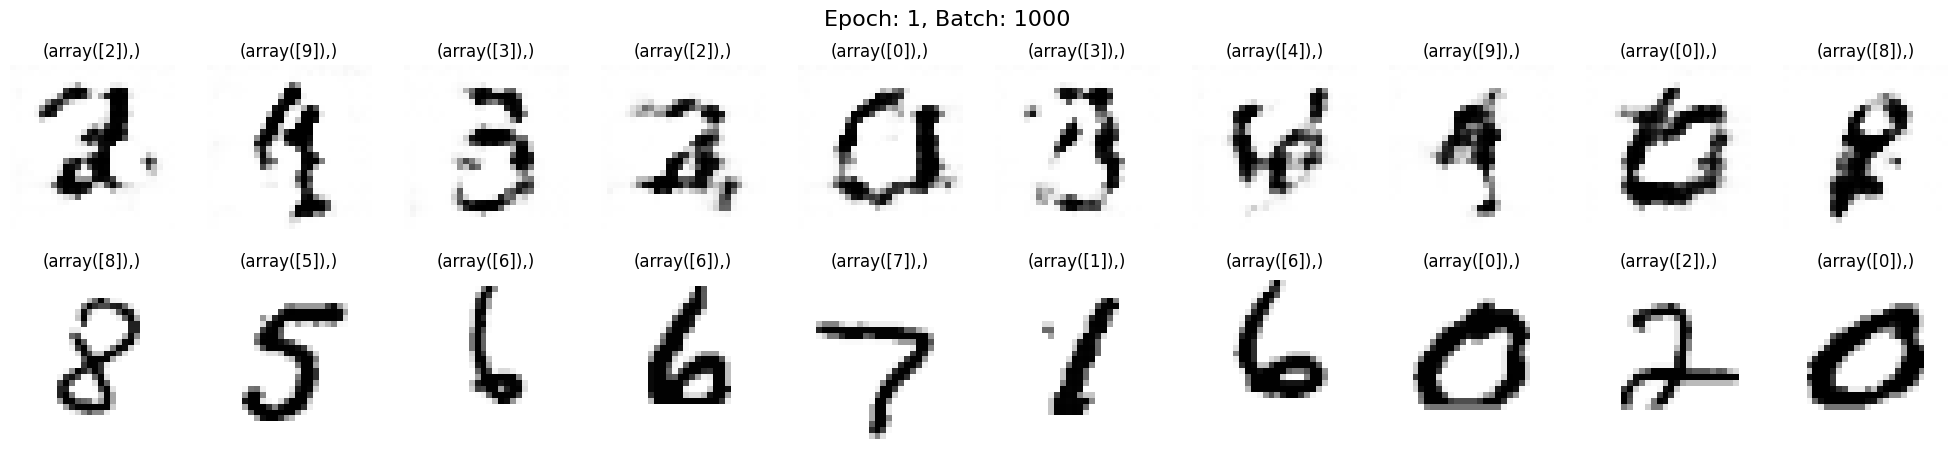

1050 [D loss: 0.6944,	 acc.: 68.75%]	[G loss: 0.8901]
1100 [D loss: 0.6265,	 acc.: 73.44%]	[G loss: 1.0018]
1150 [D loss: 0.6985,	 acc.: 64.06%]	[G loss: 1.0388]
1200 [D loss: 0.7423,	 acc.: 57.81%]	[G loss: 0.8907]
1250 [D loss: 0.6938,	 acc.: 65.62%]	[G loss: 0.9355]
1300 [D loss: 0.7088,	 acc.: 57.81%]	[G loss: 0.9158]
1350 [D loss: 0.6918,	 acc.: 73.44%]	[G loss: 0.8302]
1400 [D loss: 0.6898,	 acc.: 59.38%]	[G loss: 0.8973]
1450 [D loss: 0.6841,	 acc.: 67.19%]	[G loss: 0.8785]
1500 [D loss: 0.7533,	 acc.: 53.12%]	[G loss: 0.7435]


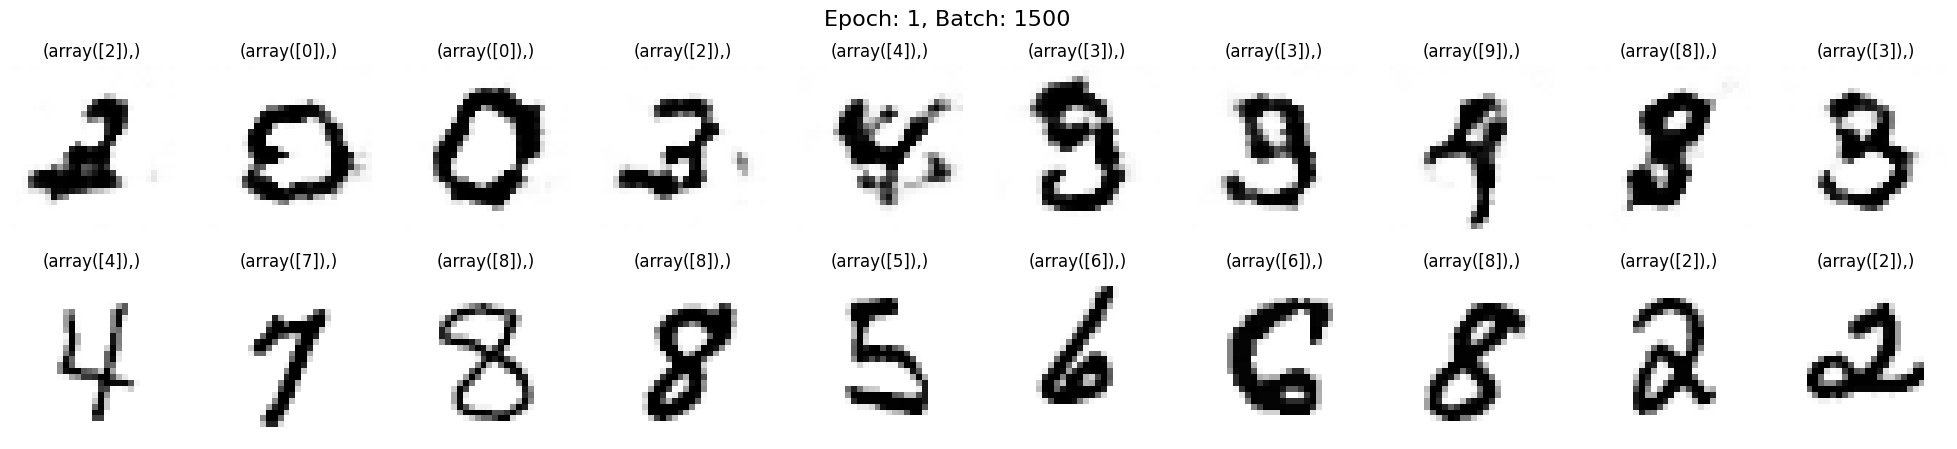

1550 [D loss: 0.6830,	 acc.: 70.31%]	[G loss: 0.9672]
1600 [D loss: 0.7706,	 acc.: 60.94%]	[G loss: 0.8445]
1650 [D loss: 0.6977,	 acc.: 70.31%]	[G loss: 0.8896]
1700 [D loss: 0.7384,	 acc.: 57.81%]	[G loss: 0.9372]
1750 [D loss: 0.7119,	 acc.: 56.25%]	[G loss: 0.8815]
1800 [D loss: 0.6665,	 acc.: 62.50%]	[G loss: 0.9729]
1850 [D loss: 0.6875,	 acc.: 57.81%]	[G loss: 0.8014]


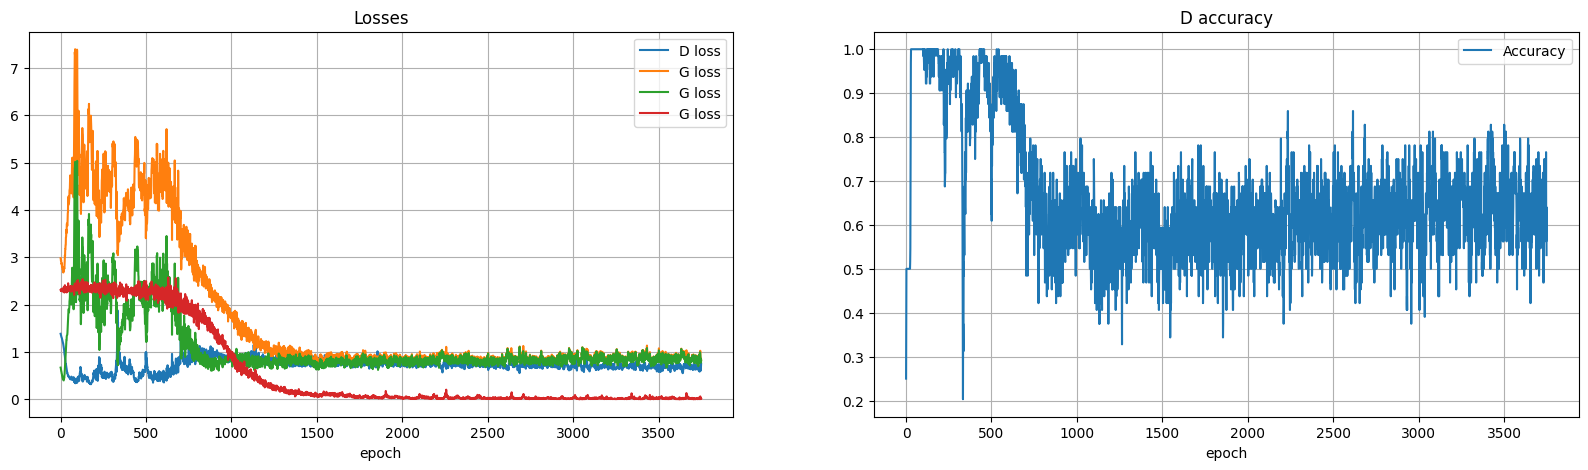

----EPOCH 2-----
0 [D loss: 0.7122,	 acc.: 60.94%]	[G loss: 0.8288]


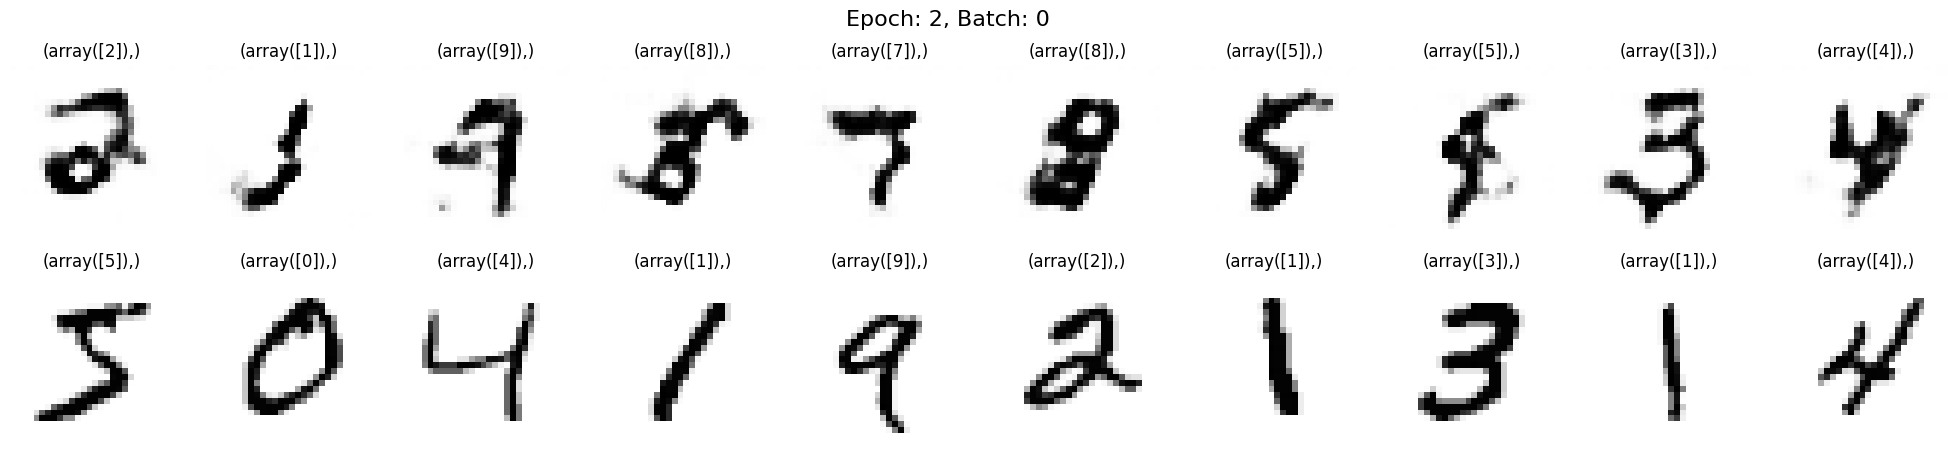

50 [D loss: 0.7133,	 acc.: 65.62%]	[G loss: 0.9129]
100 [D loss: 0.6085,	 acc.: 75.00%]	[G loss: 1.0184]
150 [D loss: 0.7005,	 acc.: 59.38%]	[G loss: 0.9070]
200 [D loss: 0.7130,	 acc.: 59.38%]	[G loss: 0.8387]
250 [D loss: 0.7648,	 acc.: 50.00%]	[G loss: 0.7938]
300 [D loss: 0.5923,	 acc.: 76.56%]	[G loss: 0.9460]
350 [D loss: 0.7552,	 acc.: 50.00%]	[G loss: 0.8950]
400 [D loss: 0.6481,	 acc.: 79.69%]	[G loss: 0.8849]
450 [D loss: 0.7304,	 acc.: 62.50%]	[G loss: 0.8007]
500 [D loss: 0.6976,	 acc.: 71.88%]	[G loss: 0.9688]


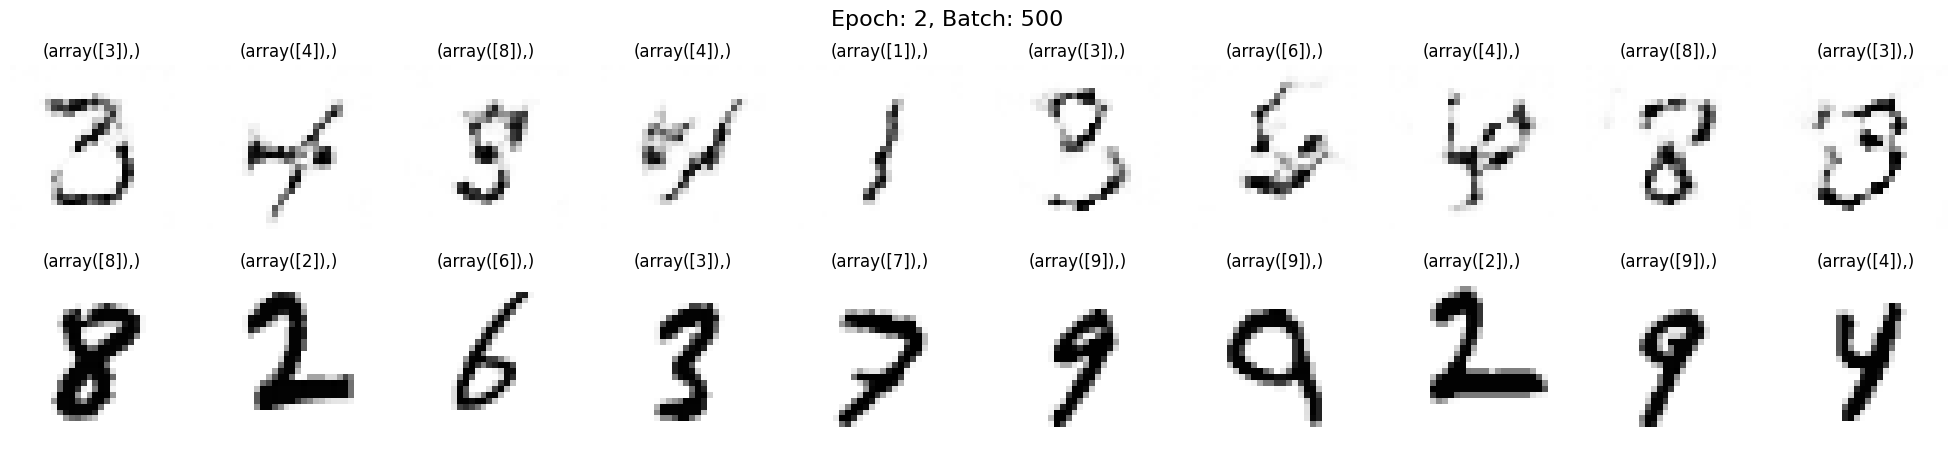

550 [D loss: 0.7433,	 acc.: 56.25%]	[G loss: 0.8532]
600 [D loss: 0.6638,	 acc.: 60.94%]	[G loss: 0.8628]
650 [D loss: 0.6861,	 acc.: 67.19%]	[G loss: 0.7442]
700 [D loss: 0.6463,	 acc.: 62.50%]	[G loss: 0.8227]
750 [D loss: 0.8100,	 acc.: 46.88%]	[G loss: 0.8624]
800 [D loss: 0.7730,	 acc.: 59.38%]	[G loss: 0.8210]
850 [D loss: 0.8364,	 acc.: 45.31%]	[G loss: 0.7788]
900 [D loss: 0.6997,	 acc.: 62.50%]	[G loss: 0.8342]
950 [D loss: 0.7376,	 acc.: 57.81%]	[G loss: 0.8527]
1000 [D loss: 0.7131,	 acc.: 56.25%]	[G loss: 0.8100]


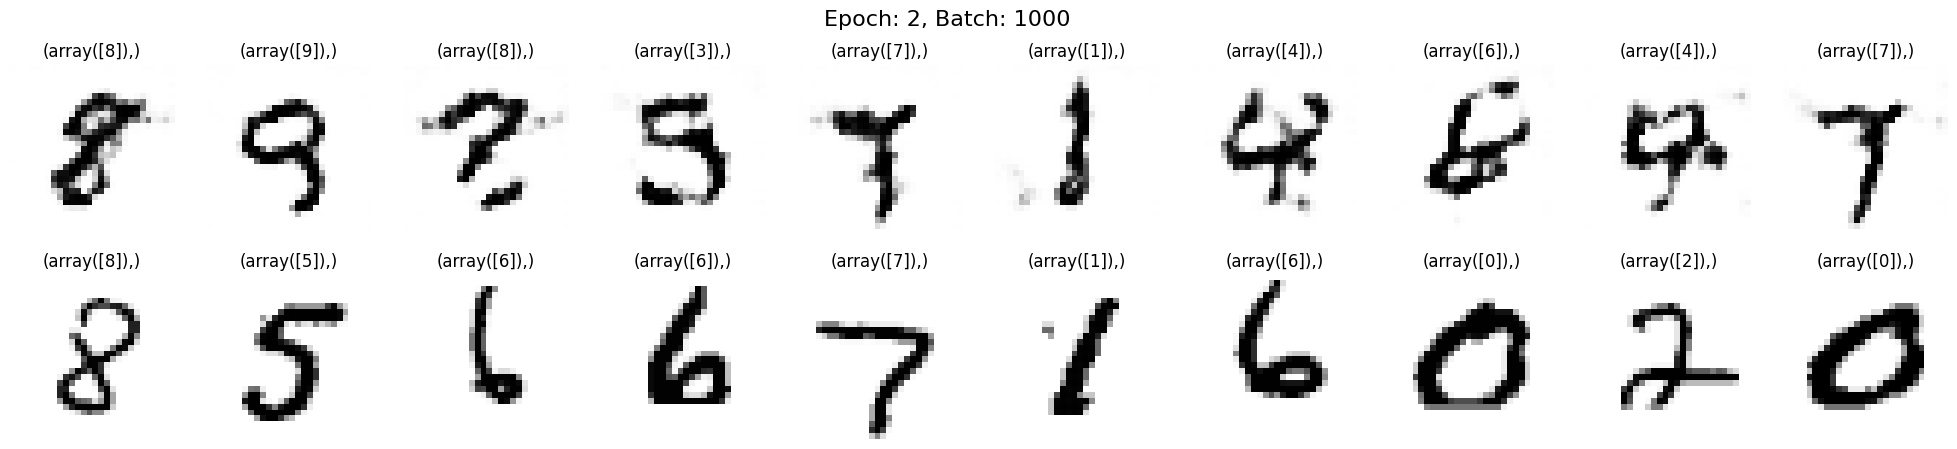

1050 [D loss: 0.7070,	 acc.: 57.81%]	[G loss: 0.8723]
1100 [D loss: 0.7030,	 acc.: 60.94%]	[G loss: 0.8554]
1150 [D loss: 0.6930,	 acc.: 62.50%]	[G loss: 0.8282]
1200 [D loss: 0.6370,	 acc.: 68.75%]	[G loss: 0.8951]
1250 [D loss: 0.7930,	 acc.: 51.56%]	[G loss: 0.8260]
1300 [D loss: 0.7817,	 acc.: 51.56%]	[G loss: 0.8465]
1350 [D loss: 0.7536,	 acc.: 59.38%]	[G loss: 0.8495]
1400 [D loss: 0.6348,	 acc.: 73.44%]	[G loss: 0.9226]
1450 [D loss: 0.7366,	 acc.: 59.38%]	[G loss: 0.9597]
1500 [D loss: 0.6548,	 acc.: 59.38%]	[G loss: 0.8688]


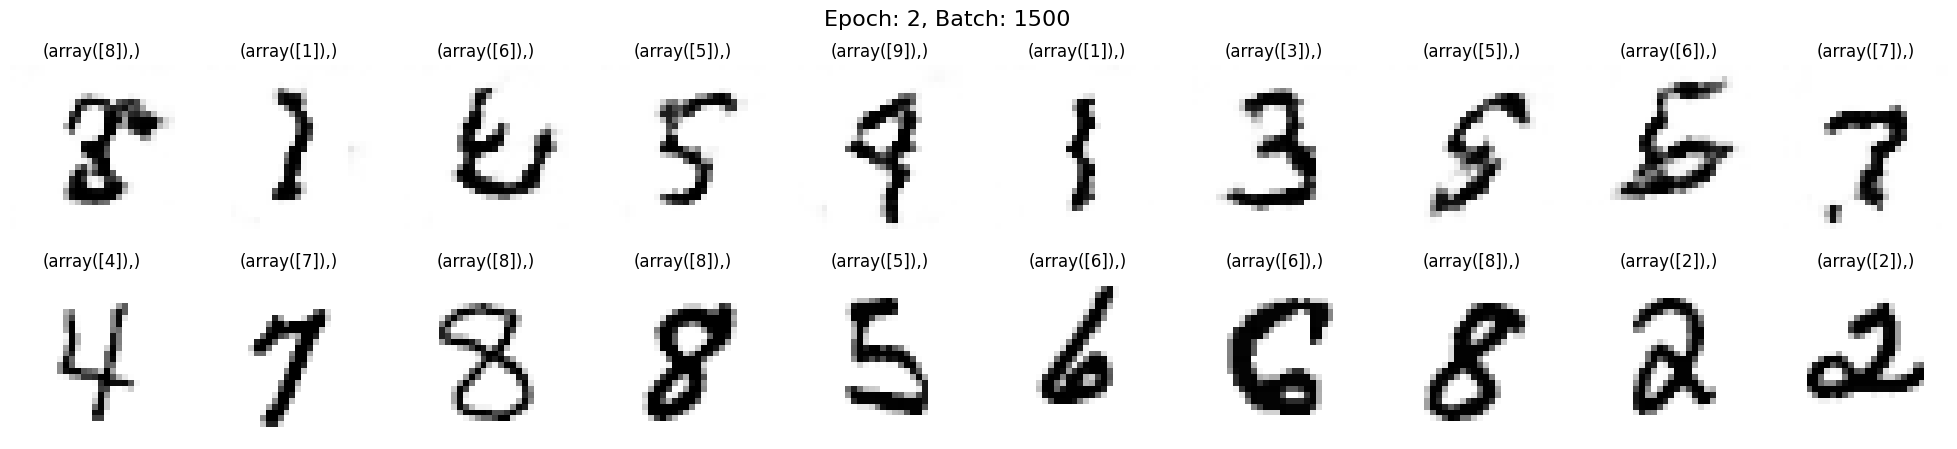

1550 [D loss: 0.6449,	 acc.: 70.31%]	[G loss: 0.9136]
1600 [D loss: 0.6256,	 acc.: 67.19%]	[G loss: 0.8727]
1650 [D loss: 0.7103,	 acc.: 60.94%]	[G loss: 0.9158]
1700 [D loss: 0.7570,	 acc.: 51.56%]	[G loss: 0.8102]
1750 [D loss: 0.6594,	 acc.: 65.62%]	[G loss: 0.7452]
1800 [D loss: 0.6654,	 acc.: 67.19%]	[G loss: 0.8854]
1850 [D loss: 0.6098,	 acc.: 68.75%]	[G loss: 1.0382]


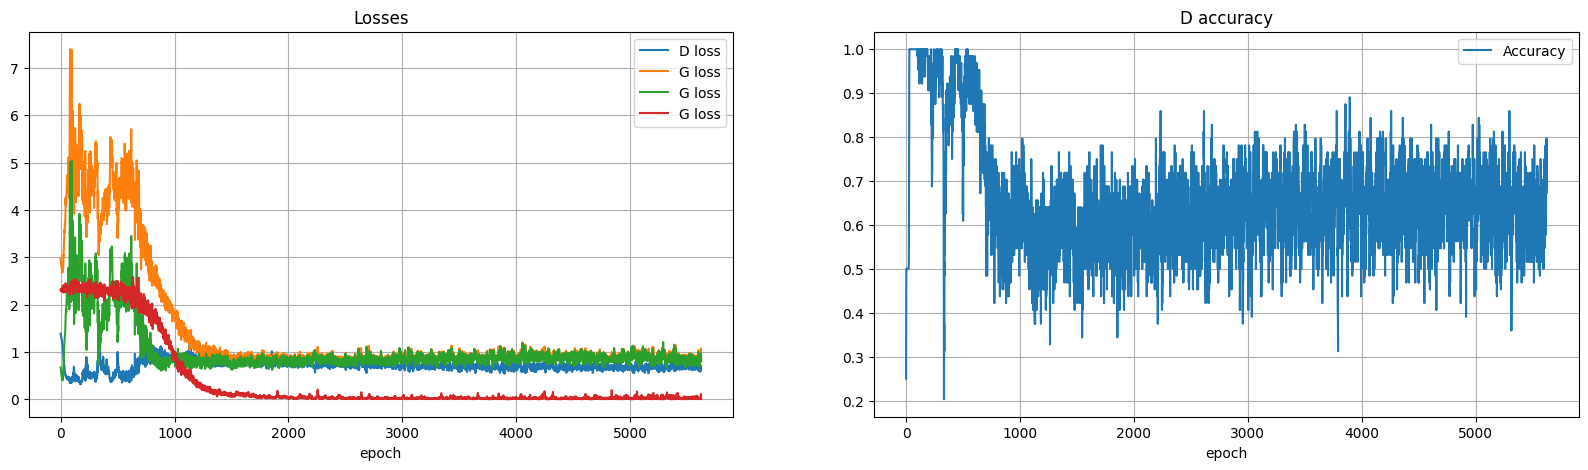

----EPOCH 3-----
0 [D loss: 0.6495,	 acc.: 70.31%]	[G loss: 0.9595]


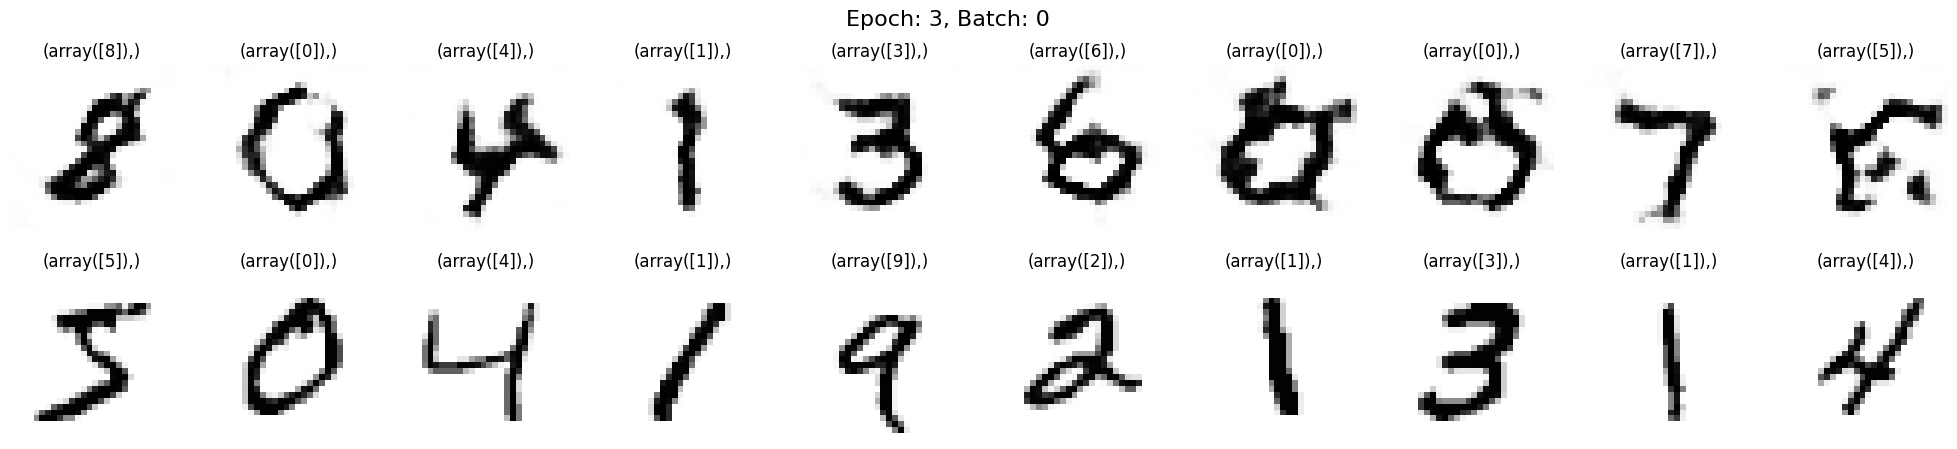

50 [D loss: 0.7342,	 acc.: 60.94%]	[G loss: 0.8873]
100 [D loss: 0.6931,	 acc.: 62.50%]	[G loss: 0.9082]
150 [D loss: 0.6931,	 acc.: 57.81%]	[G loss: 0.9407]
200 [D loss: 0.7259,	 acc.: 54.69%]	[G loss: 0.8479]
250 [D loss: 0.6944,	 acc.: 60.94%]	[G loss: 0.8423]
300 [D loss: 0.6457,	 acc.: 65.62%]	[G loss: 0.9424]
350 [D loss: 0.6784,	 acc.: 62.50%]	[G loss: 0.7678]
400 [D loss: 0.7191,	 acc.: 53.12%]	[G loss: 0.8682]
450 [D loss: 0.6469,	 acc.: 65.62%]	[G loss: 0.7644]
500 [D loss: 0.7264,	 acc.: 62.50%]	[G loss: 0.8225]


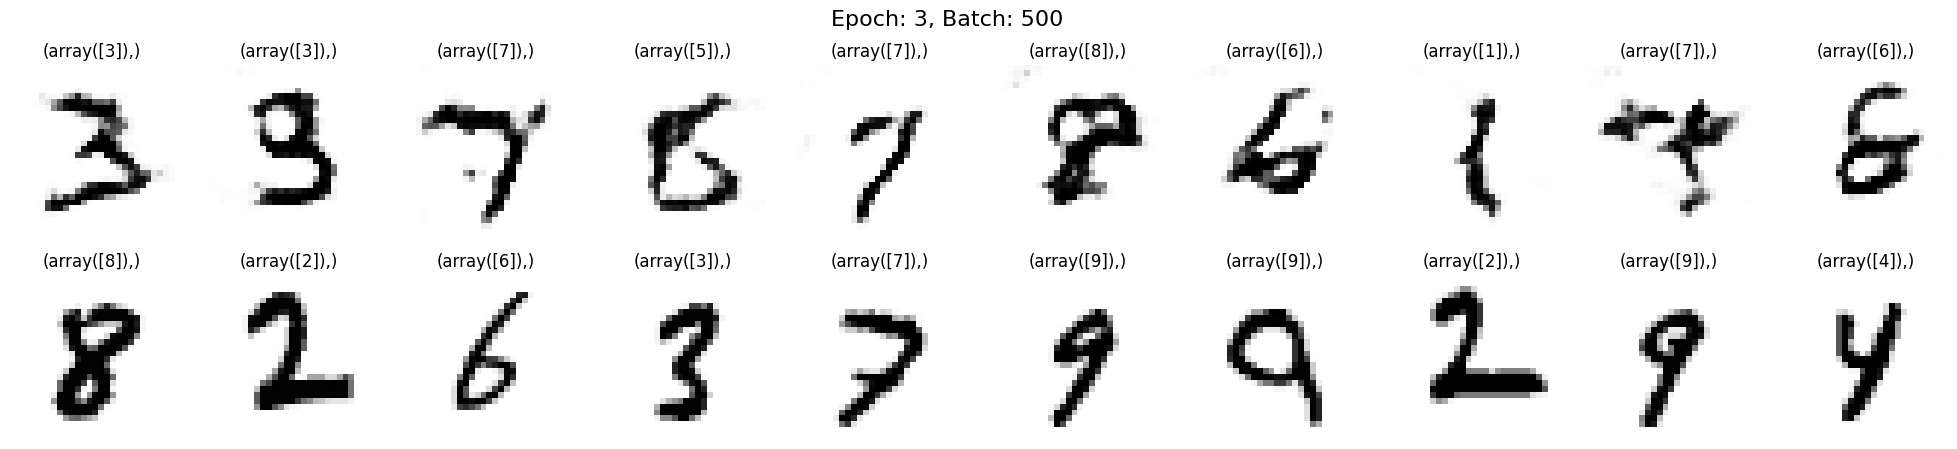

550 [D loss: 0.6662,	 acc.: 70.31%]	[G loss: 0.8305]
600 [D loss: 0.7059,	 acc.: 59.38%]	[G loss: 0.8222]
650 [D loss: 0.7228,	 acc.: 60.94%]	[G loss: 0.8059]
700 [D loss: 0.7226,	 acc.: 54.69%]	[G loss: 0.8390]
750 [D loss: 0.7135,	 acc.: 59.38%]	[G loss: 0.9342]
800 [D loss: 0.7185,	 acc.: 56.25%]	[G loss: 0.8158]
850 [D loss: 0.7252,	 acc.: 59.38%]	[G loss: 0.7581]
900 [D loss: 0.7126,	 acc.: 54.69%]	[G loss: 0.7795]
950 [D loss: 0.7498,	 acc.: 56.25%]	[G loss: 0.7737]
1000 [D loss: 0.7249,	 acc.: 51.56%]	[G loss: 0.7640]


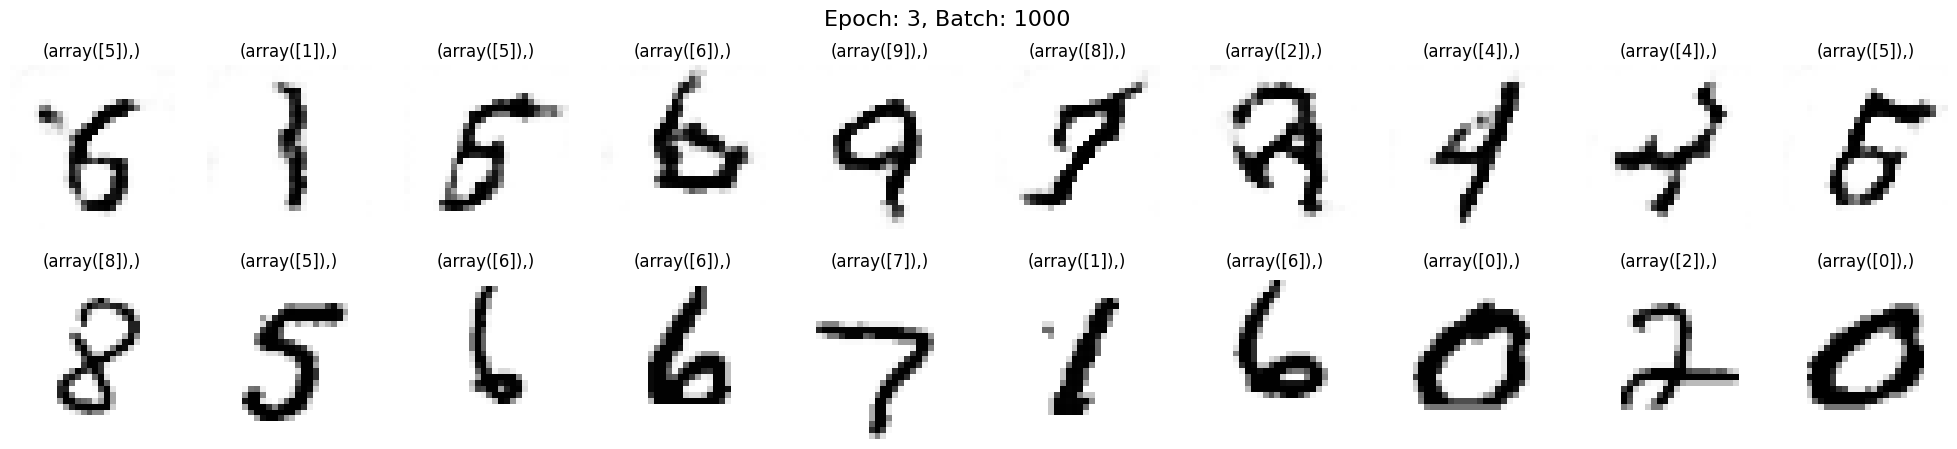

1050 [D loss: 0.7371,	 acc.: 48.44%]	[G loss: 0.7744]
1100 [D loss: 0.6867,	 acc.: 59.38%]	[G loss: 0.8046]
1150 [D loss: 0.7465,	 acc.: 50.00%]	[G loss: 0.7012]
1200 [D loss: 0.6656,	 acc.: 68.75%]	[G loss: 0.8312]
1250 [D loss: 0.6832,	 acc.: 60.94%]	[G loss: 0.8228]
1300 [D loss: 0.7015,	 acc.: 60.94%]	[G loss: 0.8560]
1350 [D loss: 0.7652,	 acc.: 62.50%]	[G loss: 0.8775]
1400 [D loss: 0.7272,	 acc.: 48.44%]	[G loss: 0.8393]
1450 [D loss: 0.7098,	 acc.: 64.06%]	[G loss: 0.8631]
1500 [D loss: 0.7260,	 acc.: 50.00%]	[G loss: 0.8157]


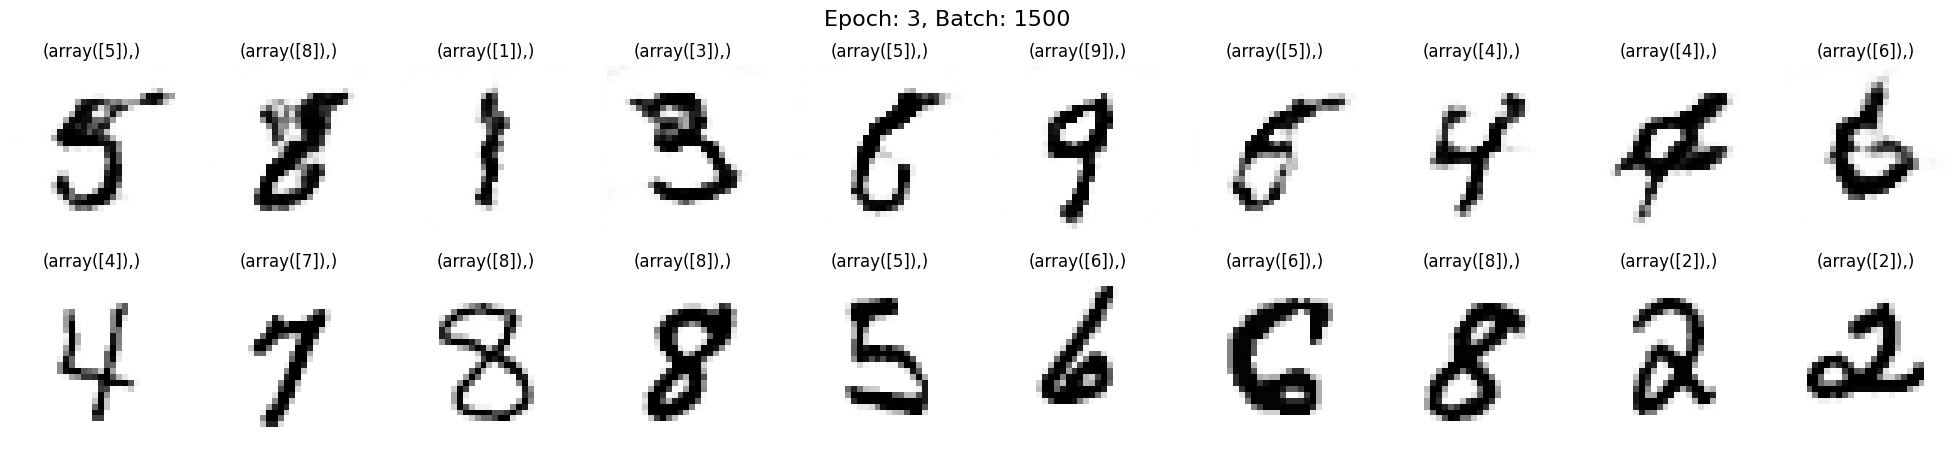

1550 [D loss: 0.7218,	 acc.: 51.56%]	[G loss: 0.8678]
1600 [D loss: 0.7063,	 acc.: 53.12%]	[G loss: 0.7250]
1650 [D loss: 0.6327,	 acc.: 73.44%]	[G loss: 0.8948]
1700 [D loss: 0.7374,	 acc.: 56.25%]	[G loss: 0.7599]
1750 [D loss: 0.7507,	 acc.: 51.56%]	[G loss: 0.7366]
1800 [D loss: 0.6716,	 acc.: 68.75%]	[G loss: 0.8203]
1850 [D loss: 0.6868,	 acc.: 62.50%]	[G loss: 0.7879]


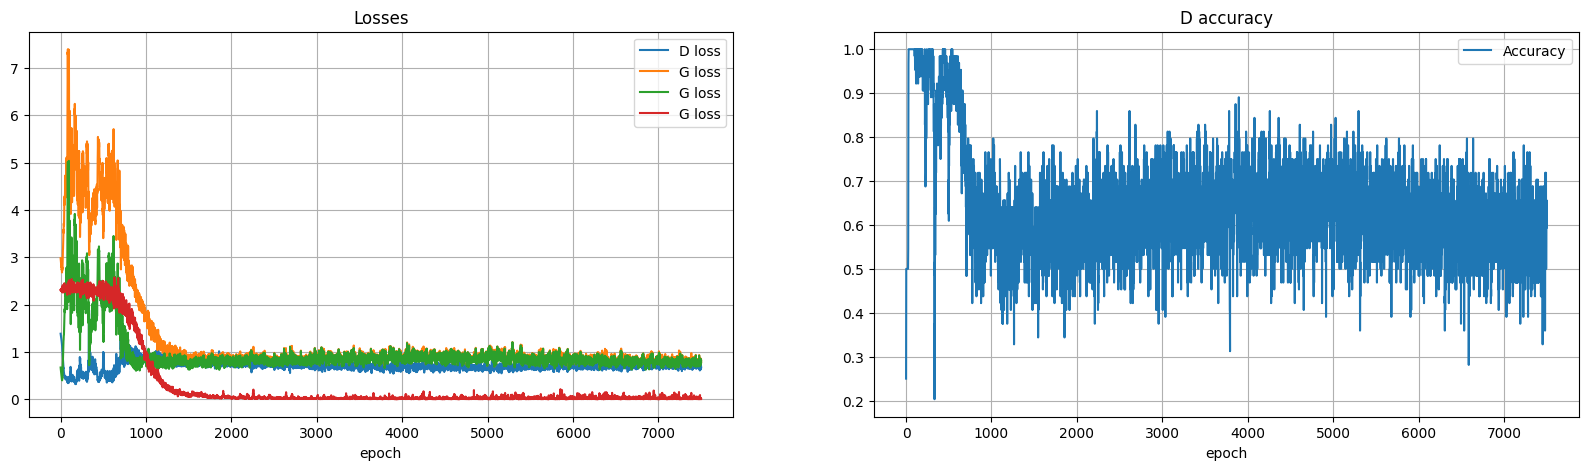

----EPOCH 4-----
0 [D loss: 0.7477,	 acc.: 50.00%]	[G loss: 0.8742]


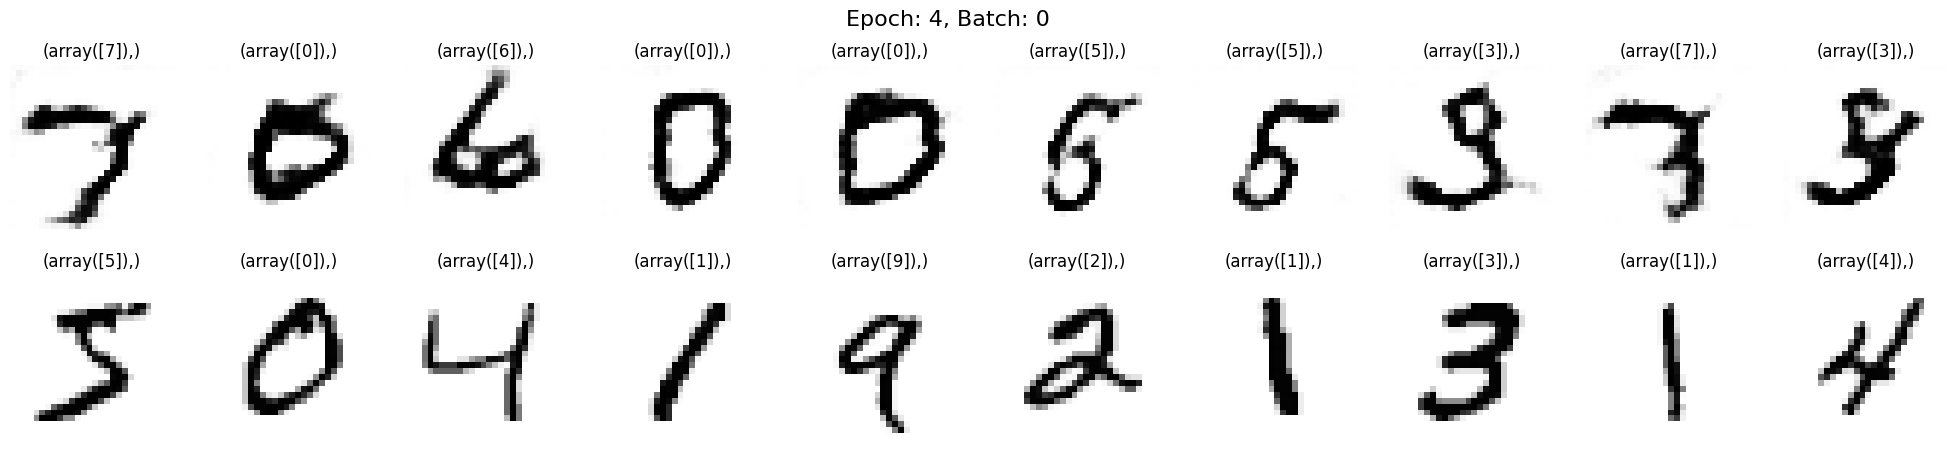

50 [D loss: 0.7203,	 acc.: 60.94%]	[G loss: 0.7509]
100 [D loss: 0.6838,	 acc.: 65.62%]	[G loss: 0.8076]
150 [D loss: 0.6188,	 acc.: 71.88%]	[G loss: 0.8430]
200 [D loss: 0.7050,	 acc.: 59.38%]	[G loss: 0.8278]
250 [D loss: 0.6970,	 acc.: 67.19%]	[G loss: 0.7851]
300 [D loss: 0.6815,	 acc.: 67.19%]	[G loss: 0.8697]
350 [D loss: 0.7053,	 acc.: 62.50%]	[G loss: 0.7715]
400 [D loss: 0.7277,	 acc.: 53.12%]	[G loss: 0.7968]
450 [D loss: 0.7118,	 acc.: 53.12%]	[G loss: 0.7012]
500 [D loss: 0.7016,	 acc.: 62.50%]	[G loss: 0.8741]


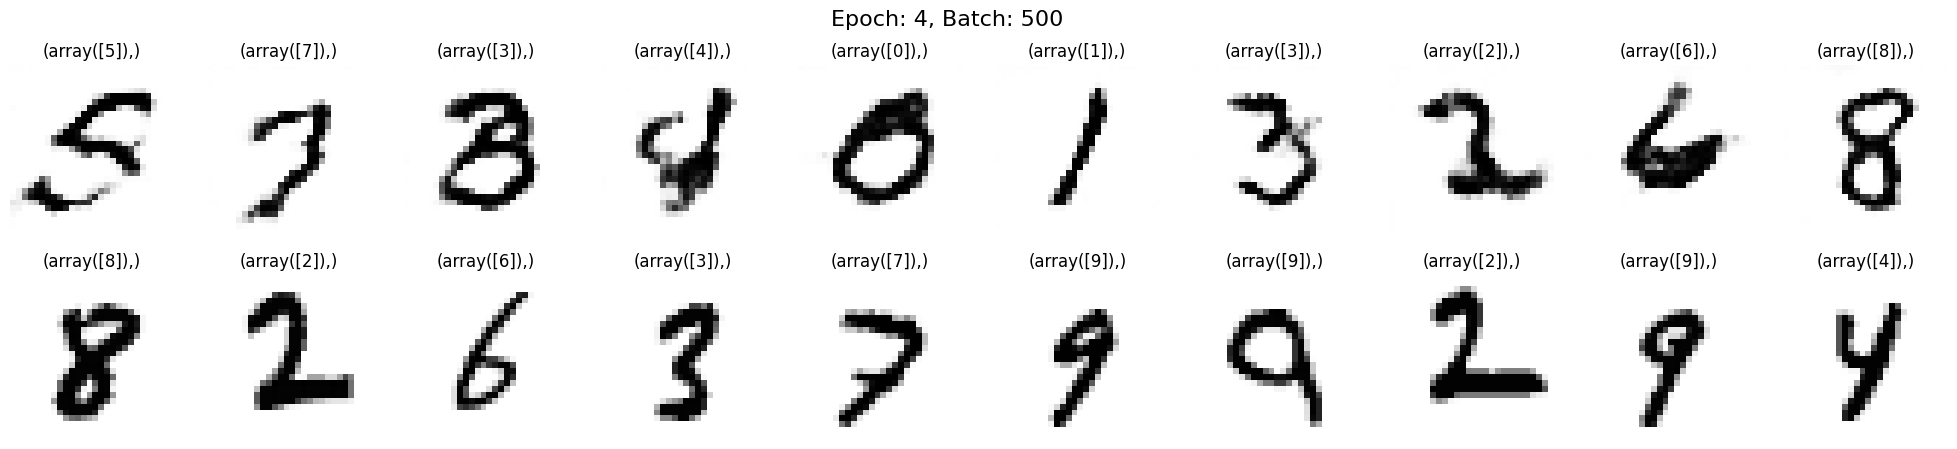

550 [D loss: 0.7237,	 acc.: 57.81%]	[G loss: 0.7321]
600 [D loss: 0.7373,	 acc.: 53.12%]	[G loss: 0.7751]
650 [D loss: 0.6906,	 acc.: 67.19%]	[G loss: 0.7547]
700 [D loss: 0.6750,	 acc.: 59.38%]	[G loss: 0.8275]
750 [D loss: 0.7127,	 acc.: 48.44%]	[G loss: 0.8122]
800 [D loss: 0.7438,	 acc.: 56.25%]	[G loss: 0.7025]
850 [D loss: 0.7714,	 acc.: 50.00%]	[G loss: 0.7454]
900 [D loss: 0.7021,	 acc.: 48.44%]	[G loss: 0.6678]
950 [D loss: 0.7532,	 acc.: 54.69%]	[G loss: 0.7958]
1000 [D loss: 0.7378,	 acc.: 59.38%]	[G loss: 0.6875]


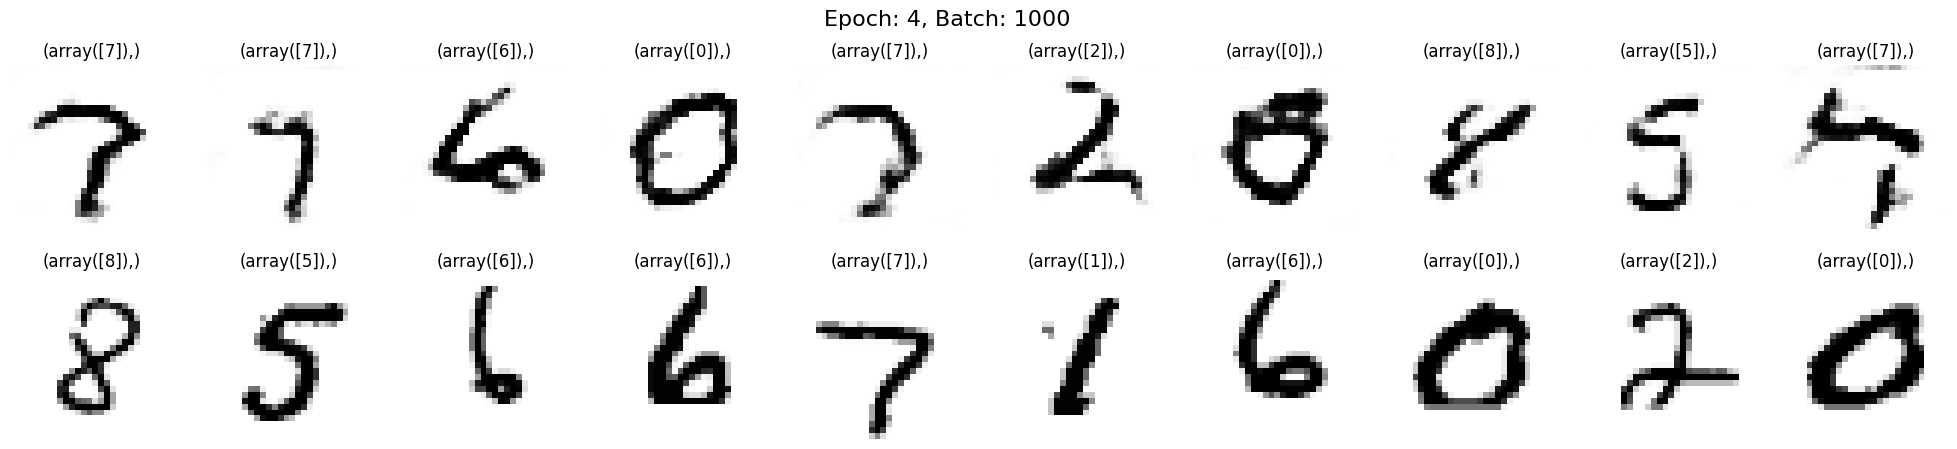

1050 [D loss: 0.6991,	 acc.: 60.94%]	[G loss: 0.8429]
1100 [D loss: 0.7210,	 acc.: 48.44%]	[G loss: 0.7477]
1150 [D loss: 0.7435,	 acc.: 57.81%]	[G loss: 0.7431]
1200 [D loss: 0.7161,	 acc.: 56.25%]	[G loss: 0.7725]
1250 [D loss: 0.7229,	 acc.: 51.56%]	[G loss: 0.7680]
1300 [D loss: 0.6973,	 acc.: 62.50%]	[G loss: 0.8440]
1350 [D loss: 0.7719,	 acc.: 48.44%]	[G loss: 0.8510]
1400 [D loss: 0.7169,	 acc.: 57.81%]	[G loss: 0.7090]
1450 [D loss: 0.7662,	 acc.: 45.31%]	[G loss: 0.7215]
1500 [D loss: 0.7375,	 acc.: 45.31%]	[G loss: 0.7445]


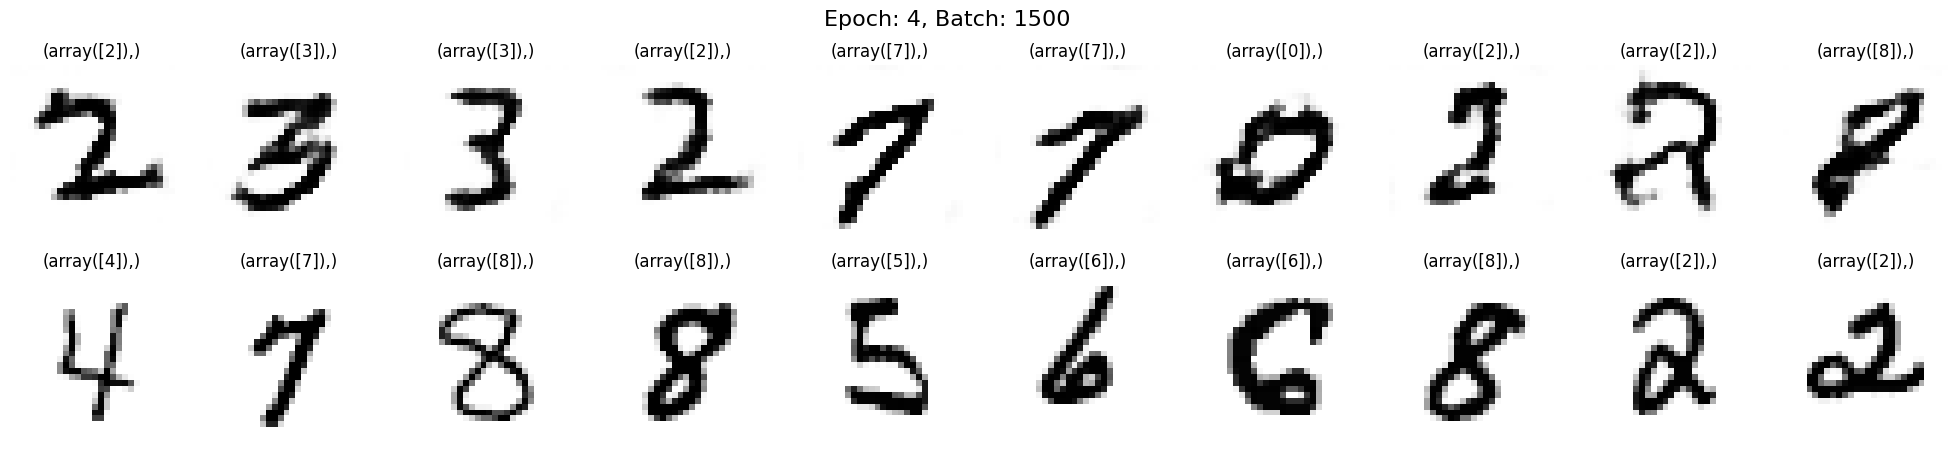

1550 [D loss: 0.7713,	 acc.: 53.12%]	[G loss: 0.7405]
1600 [D loss: 0.7005,	 acc.: 62.50%]	[G loss: 0.7878]
1650 [D loss: 0.6575,	 acc.: 71.88%]	[G loss: 0.8019]
1700 [D loss: 0.6932,	 acc.: 59.38%]	[G loss: 0.7411]
1750 [D loss: 0.7534,	 acc.: 54.69%]	[G loss: 0.7008]
1800 [D loss: 0.7113,	 acc.: 48.44%]	[G loss: 0.6904]
1850 [D loss: 0.6852,	 acc.: 57.81%]	[G loss: 0.7476]


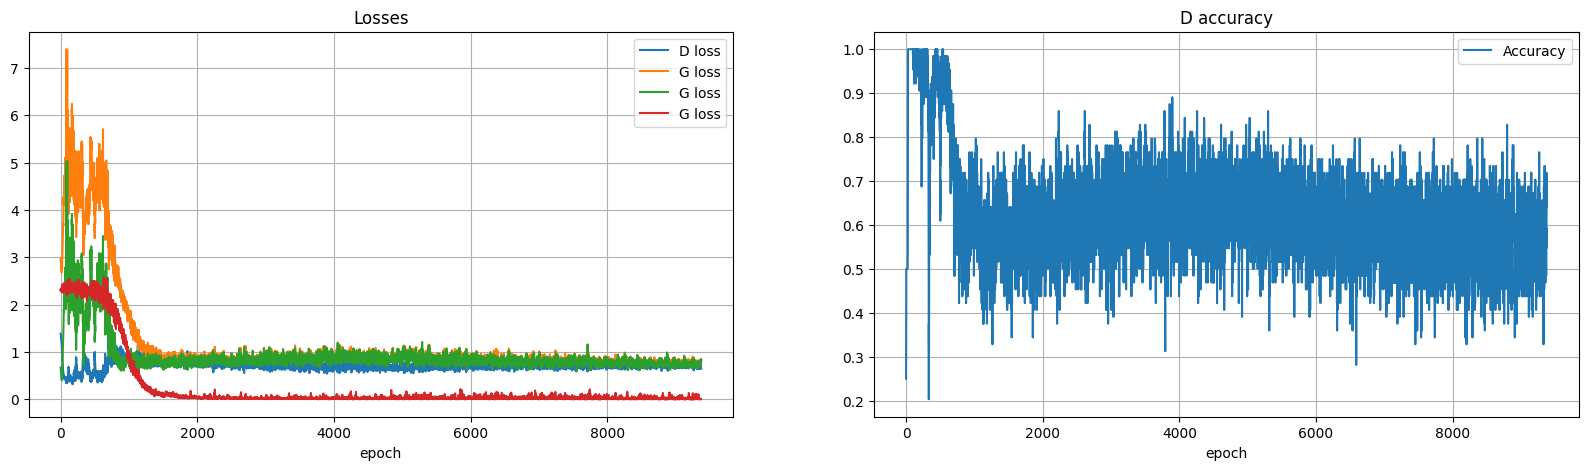

----EPOCH 5-----
0 [D loss: 0.7020,	 acc.: 57.81%]	[G loss: 0.8073]


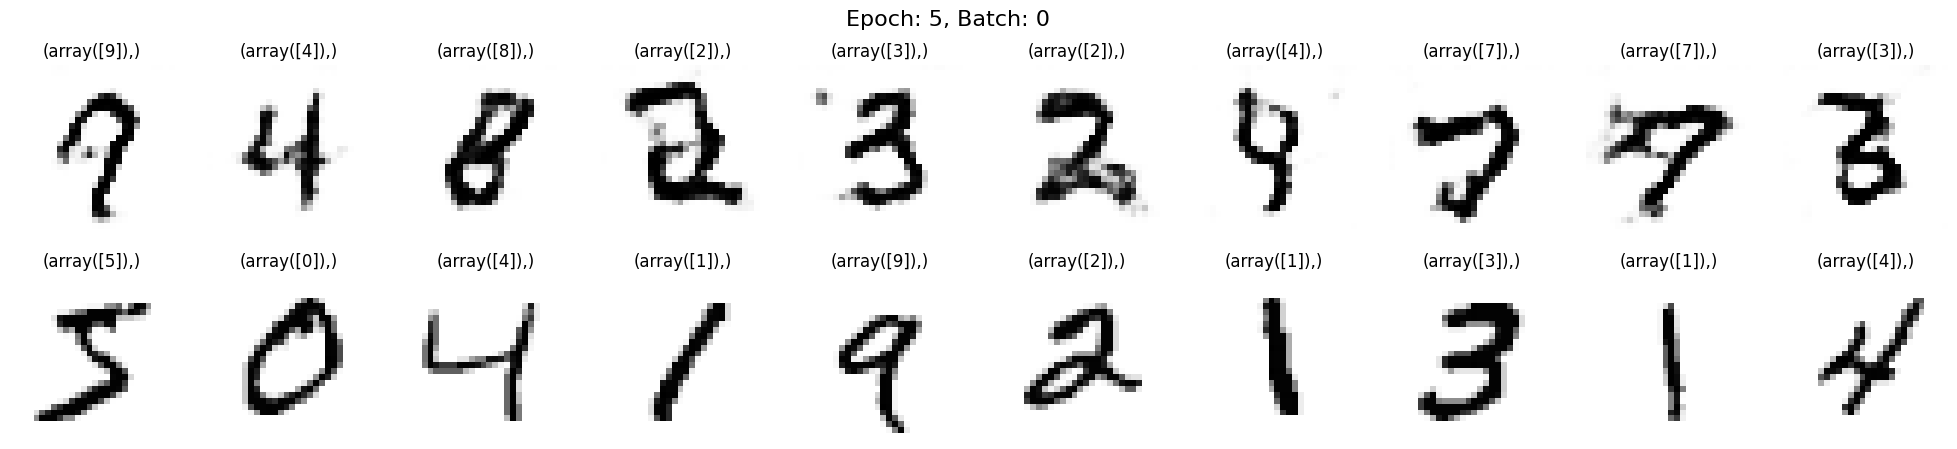

50 [D loss: 0.7411,	 acc.: 53.12%]	[G loss: 0.7837]
100 [D loss: 0.7168,	 acc.: 57.81%]	[G loss: 0.8020]
150 [D loss: 0.6820,	 acc.: 56.25%]	[G loss: 0.6988]
200 [D loss: 0.7804,	 acc.: 45.31%]	[G loss: 0.7648]
250 [D loss: 0.7938,	 acc.: 32.81%]	[G loss: 0.6369]
300 [D loss: 0.7320,	 acc.: 50.00%]	[G loss: 0.7140]
350 [D loss: 0.7184,	 acc.: 56.25%]	[G loss: 0.7865]
400 [D loss: 0.7354,	 acc.: 50.00%]	[G loss: 0.7451]
450 [D loss: 0.6879,	 acc.: 56.25%]	[G loss: 0.8277]
500 [D loss: 0.7062,	 acc.: 70.31%]	[G loss: 0.7287]


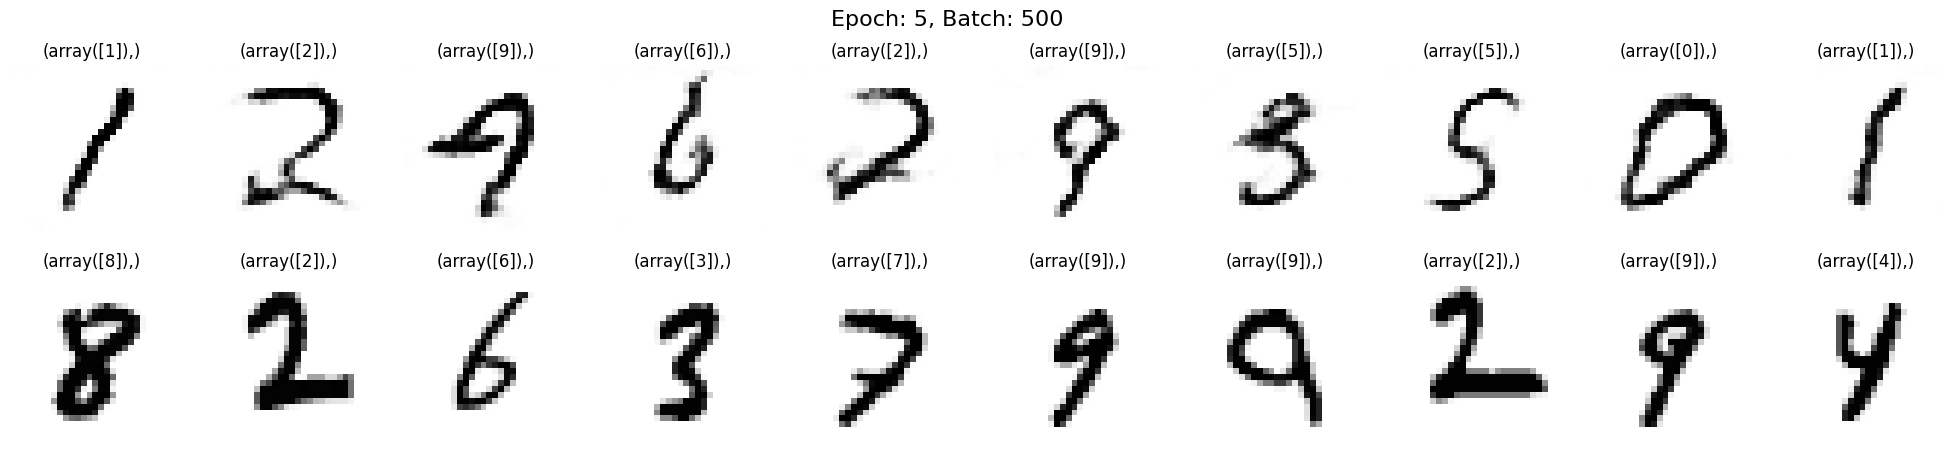

550 [D loss: 0.7298,	 acc.: 50.00%]	[G loss: 0.7312]
600 [D loss: 0.7242,	 acc.: 51.56%]	[G loss: 0.8122]
650 [D loss: 0.6958,	 acc.: 60.94%]	[G loss: 0.7546]
700 [D loss: 0.7534,	 acc.: 42.19%]	[G loss: 0.6982]
750 [D loss: 0.6871,	 acc.: 65.62%]	[G loss: 0.8728]
800 [D loss: 0.7455,	 acc.: 48.44%]	[G loss: 0.6490]
850 [D loss: 0.7126,	 acc.: 57.81%]	[G loss: 0.7351]
900 [D loss: 0.7205,	 acc.: 57.81%]	[G loss: 0.7289]
950 [D loss: 0.7758,	 acc.: 42.19%]	[G loss: 0.7263]
1000 [D loss: 0.7438,	 acc.: 39.06%]	[G loss: 0.8207]


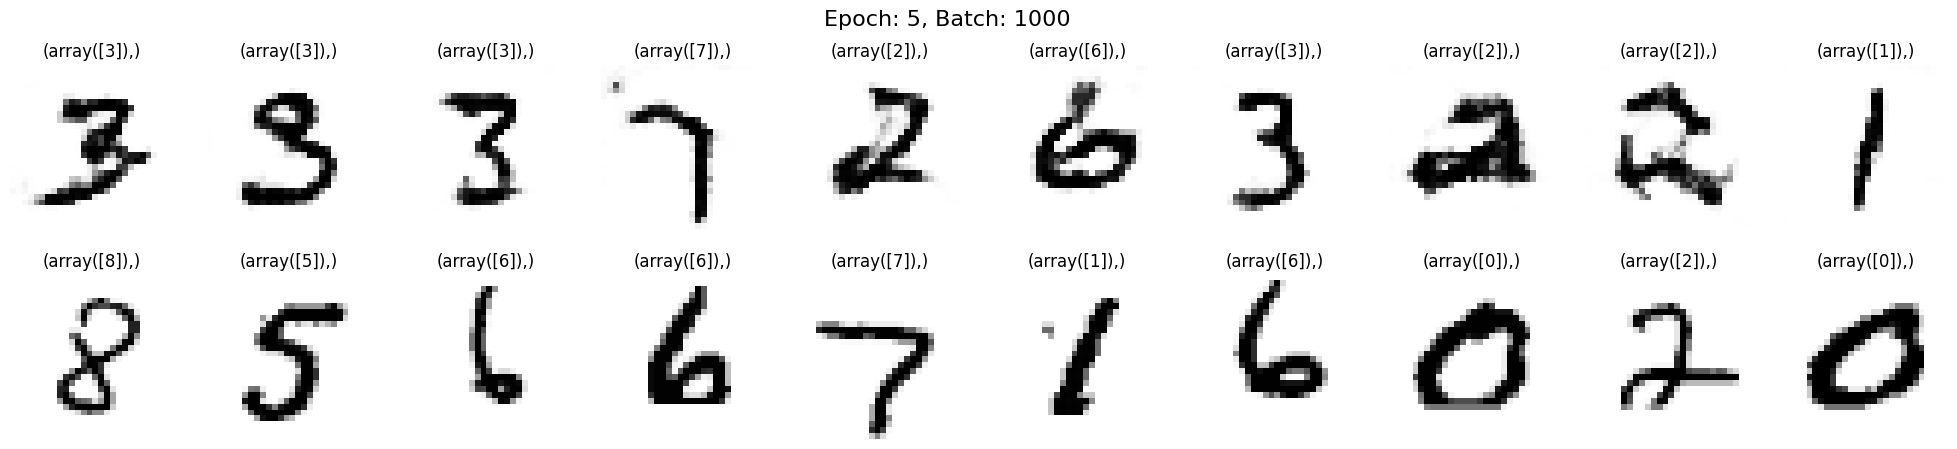

1050 [D loss: 0.7121,	 acc.: 46.88%]	[G loss: 0.7393]
1100 [D loss: 0.6927,	 acc.: 53.12%]	[G loss: 0.7452]
1150 [D loss: 0.6932,	 acc.: 57.81%]	[G loss: 0.7703]
1200 [D loss: 0.6869,	 acc.: 60.94%]	[G loss: 0.7108]
1250 [D loss: 0.7253,	 acc.: 57.81%]	[G loss: 0.7677]
1300 [D loss: 0.7032,	 acc.: 57.81%]	[G loss: 0.7636]
1350 [D loss: 0.7508,	 acc.: 50.00%]	[G loss: 0.6895]
1400 [D loss: 0.6433,	 acc.: 67.19%]	[G loss: 0.7945]
1450 [D loss: 0.7265,	 acc.: 56.25%]	[G loss: 0.7385]
1500 [D loss: 0.7376,	 acc.: 50.00%]	[G loss: 0.7460]


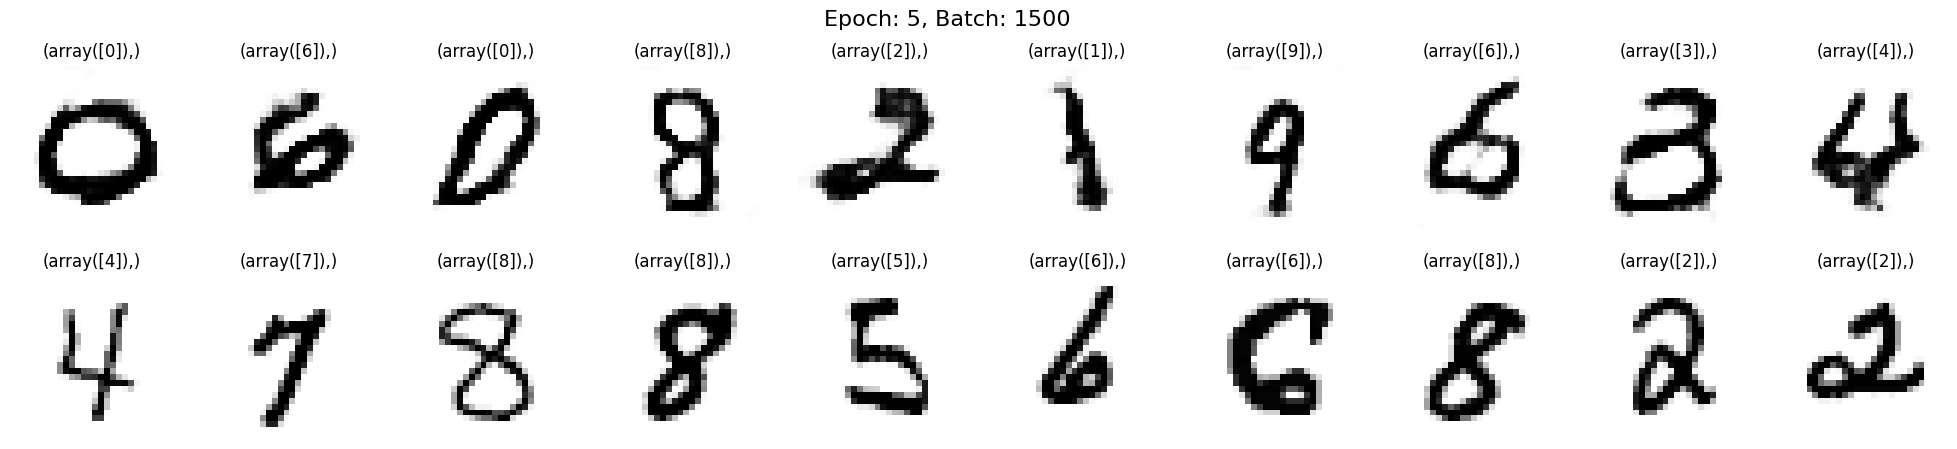

1550 [D loss: 0.6799,	 acc.: 65.62%]	[G loss: 0.8127]
1600 [D loss: 0.7034,	 acc.: 51.56%]	[G loss: 0.7412]
1650 [D loss: 0.6925,	 acc.: 70.31%]	[G loss: 0.8338]
1700 [D loss: 0.7127,	 acc.: 54.69%]	[G loss: 0.7227]
1750 [D loss: 0.7152,	 acc.: 57.81%]	[G loss: 0.7605]
1800 [D loss: 0.7671,	 acc.: 46.88%]	[G loss: 0.6626]
1850 [D loss: 0.7120,	 acc.: 54.69%]	[G loss: 0.7717]


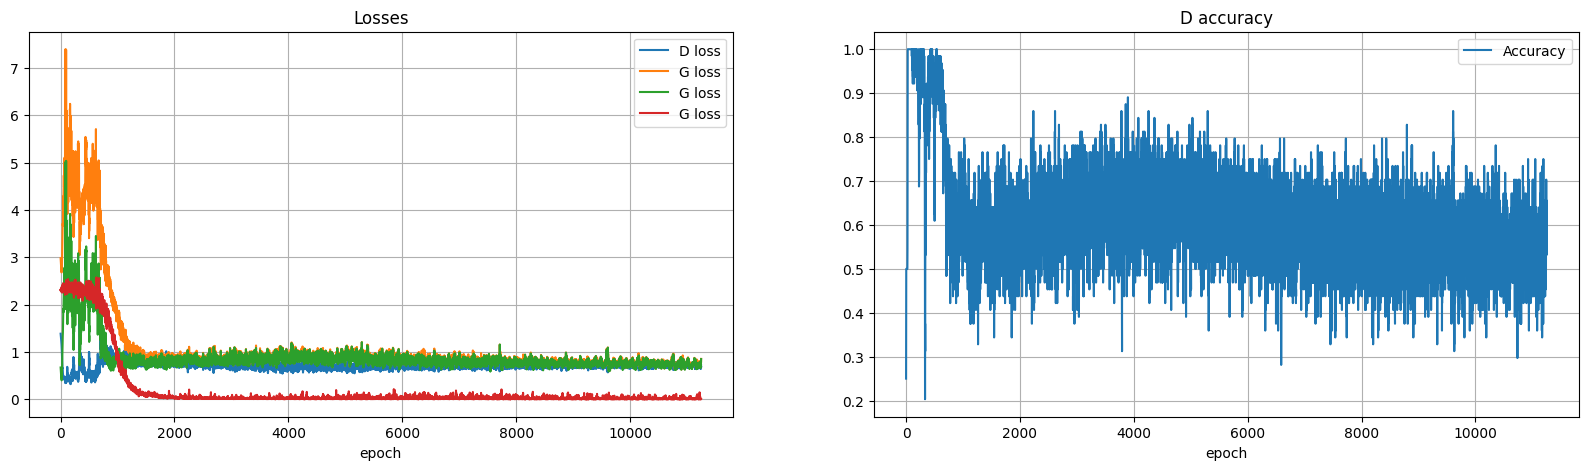

----EPOCH 6-----
0 [D loss: 0.6855,	 acc.: 54.69%]	[G loss: 0.7906]


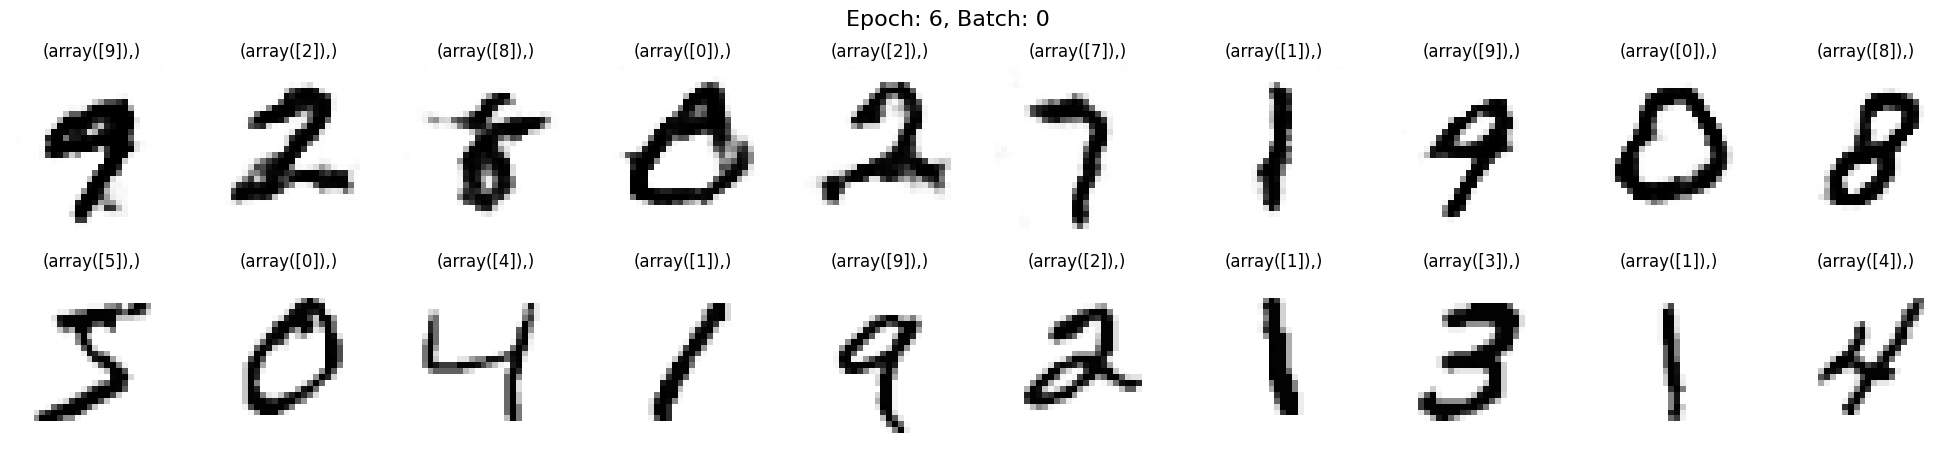

50 [D loss: 0.6835,	 acc.: 70.31%]	[G loss: 0.7311]
100 [D loss: 0.7317,	 acc.: 51.56%]	[G loss: 0.8008]
150 [D loss: 0.6929,	 acc.: 64.06%]	[G loss: 0.7096]
200 [D loss: 0.7177,	 acc.: 57.81%]	[G loss: 0.7788]
250 [D loss: 0.7287,	 acc.: 51.56%]	[G loss: 0.8386]
300 [D loss: 0.6996,	 acc.: 53.12%]	[G loss: 0.8011]
350 [D loss: 0.7046,	 acc.: 60.94%]	[G loss: 0.7778]
400 [D loss: 0.6526,	 acc.: 73.44%]	[G loss: 0.7964]
450 [D loss: 0.7495,	 acc.: 45.31%]	[G loss: 0.7509]
500 [D loss: 0.7277,	 acc.: 56.25%]	[G loss: 0.7869]


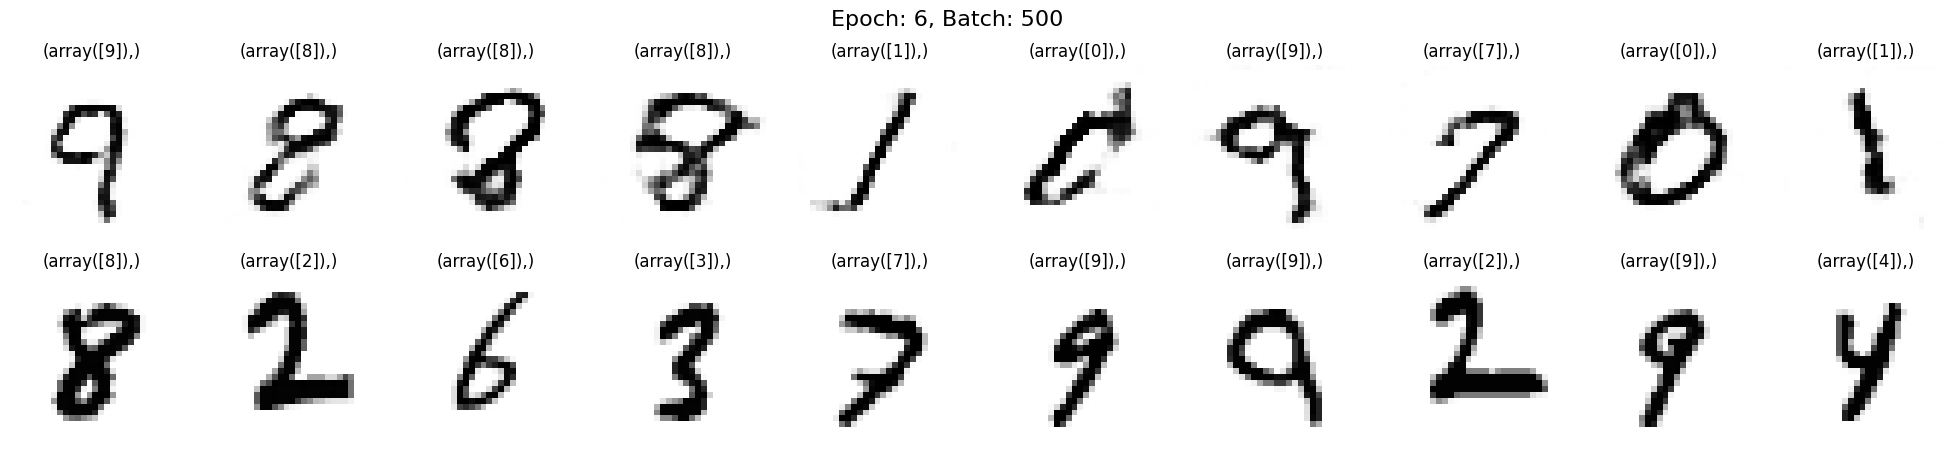

550 [D loss: 0.7200,	 acc.: 46.88%]	[G loss: 0.7670]
600 [D loss: 0.7717,	 acc.: 40.62%]	[G loss: 0.6934]
650 [D loss: 0.7428,	 acc.: 53.12%]	[G loss: 0.8652]
700 [D loss: 0.7069,	 acc.: 53.12%]	[G loss: 0.7431]
750 [D loss: 0.6961,	 acc.: 50.00%]	[G loss: 0.7184]
800 [D loss: 0.7422,	 acc.: 54.69%]	[G loss: 0.7290]
850 [D loss: 0.6651,	 acc.: 65.62%]	[G loss: 0.7071]
900 [D loss: 0.6914,	 acc.: 59.38%]	[G loss: 0.8148]
950 [D loss: 0.6986,	 acc.: 54.69%]	[G loss: 0.8484]
1000 [D loss: 0.7558,	 acc.: 43.75%]	[G loss: 0.6724]


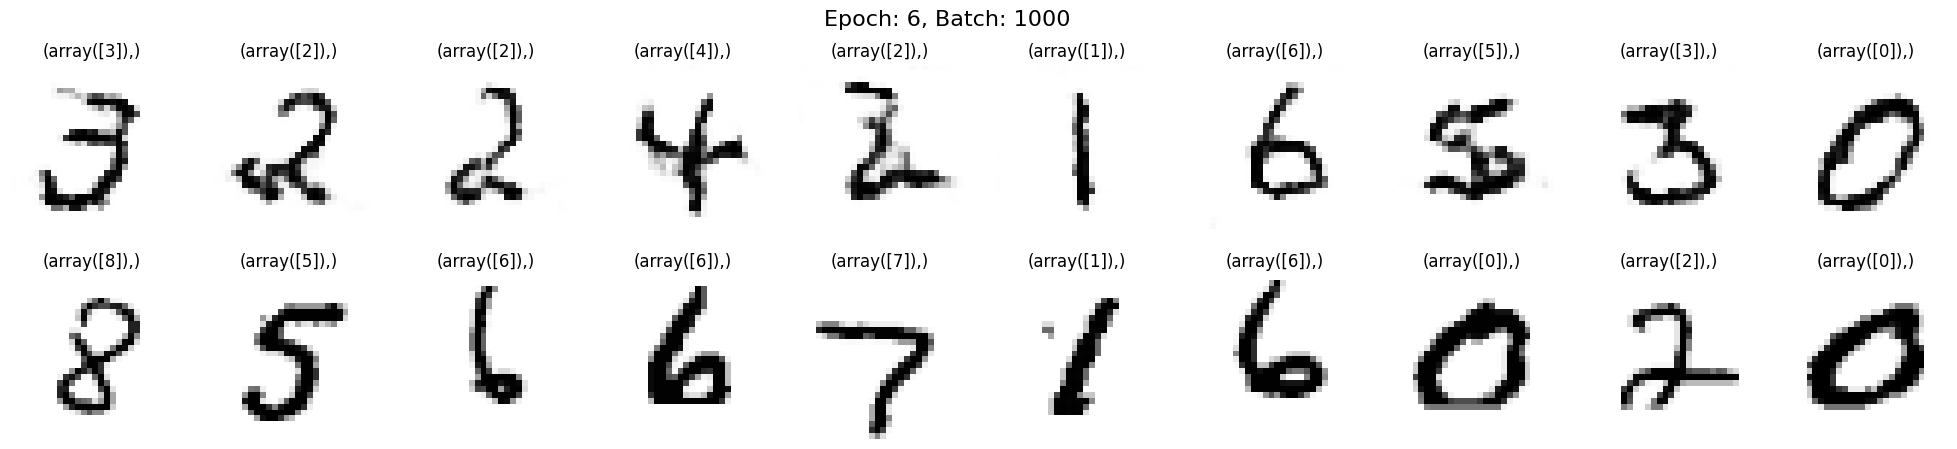

1050 [D loss: 0.7012,	 acc.: 56.25%]	[G loss: 0.8094]
1100 [D loss: 0.7119,	 acc.: 51.56%]	[G loss: 0.6862]
1150 [D loss: 0.6747,	 acc.: 60.94%]	[G loss: 0.7156]
1200 [D loss: 0.6797,	 acc.: 64.06%]	[G loss: 0.7681]
1250 [D loss: 0.6773,	 acc.: 57.81%]	[G loss: 0.7492]
1300 [D loss: 0.6952,	 acc.: 60.94%]	[G loss: 0.8087]
1350 [D loss: 0.6894,	 acc.: 62.50%]	[G loss: 0.6981]
1400 [D loss: 0.7126,	 acc.: 56.25%]	[G loss: 0.7966]
1450 [D loss: 0.7640,	 acc.: 48.44%]	[G loss: 0.7278]
1500 [D loss: 0.7128,	 acc.: 46.88%]	[G loss: 0.7580]


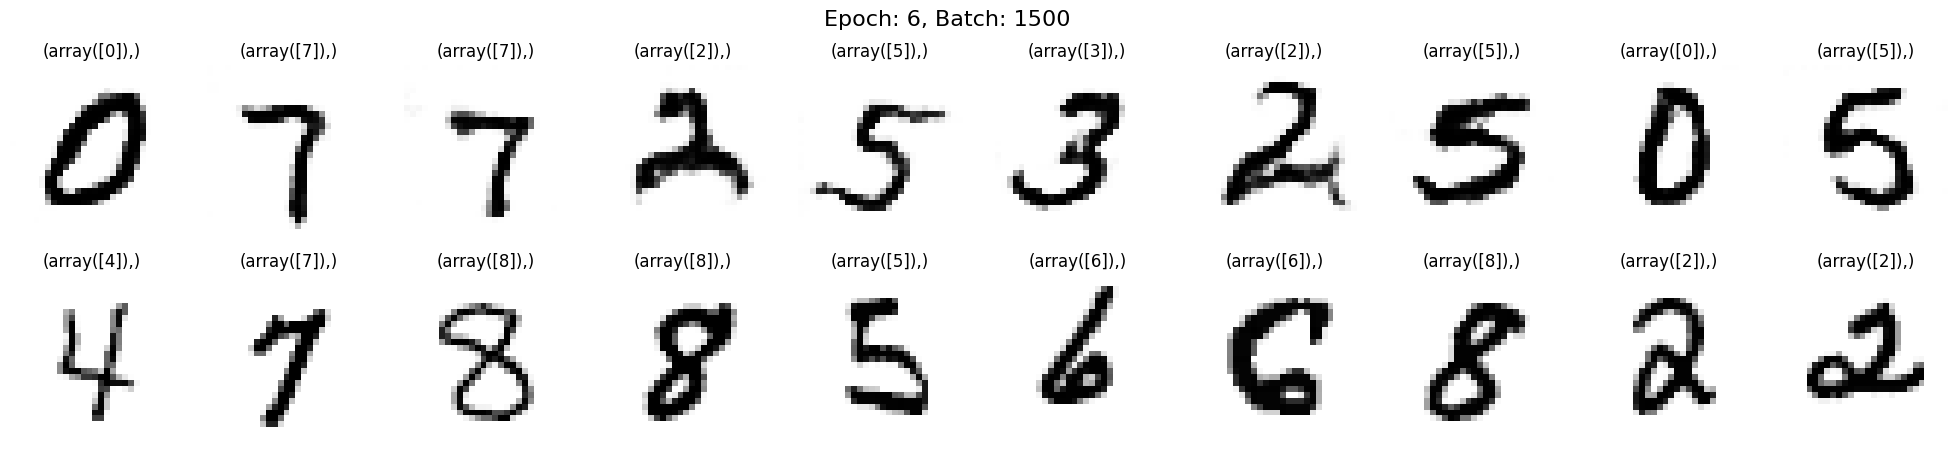

1550 [D loss: 0.6693,	 acc.: 68.75%]	[G loss: 0.8411]
1600 [D loss: 0.7036,	 acc.: 53.12%]	[G loss: 0.6350]
1650 [D loss: 0.6755,	 acc.: 65.62%]	[G loss: 0.8235]
1700 [D loss: 0.7045,	 acc.: 48.44%]	[G loss: 0.6716]
1750 [D loss: 0.6783,	 acc.: 64.06%]	[G loss: 0.8118]
1800 [D loss: 0.7336,	 acc.: 51.56%]	[G loss: 0.6531]
1850 [D loss: 0.7066,	 acc.: 51.56%]	[G loss: 0.7284]


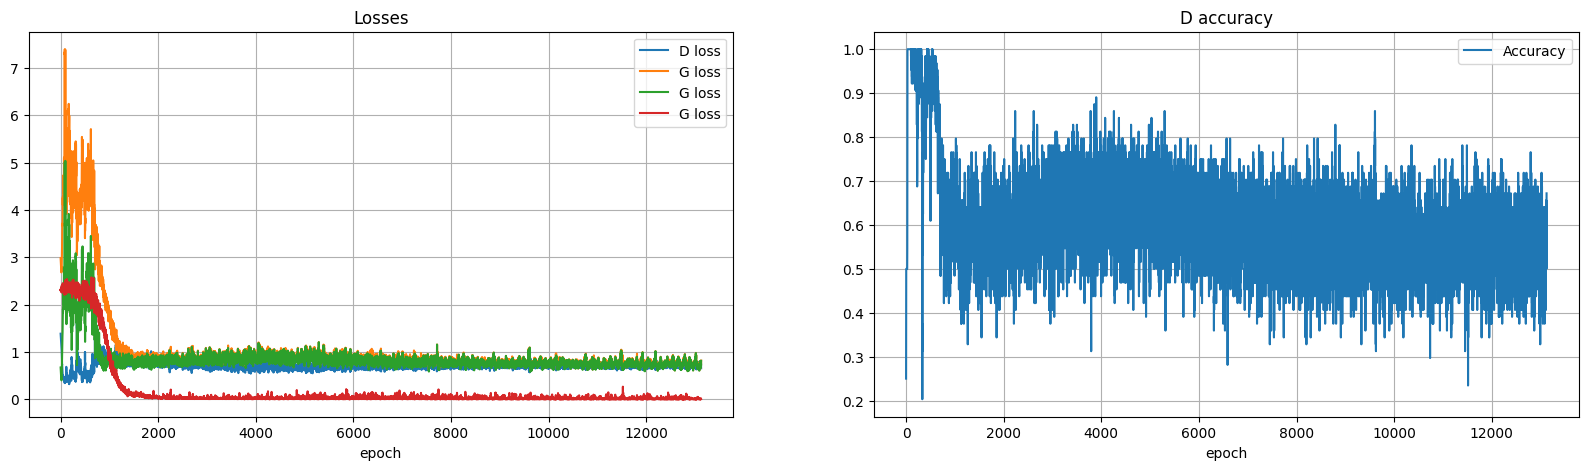

----EPOCH 7-----
0 [D loss: 0.6820,	 acc.: 53.12%]	[G loss: 0.7763]


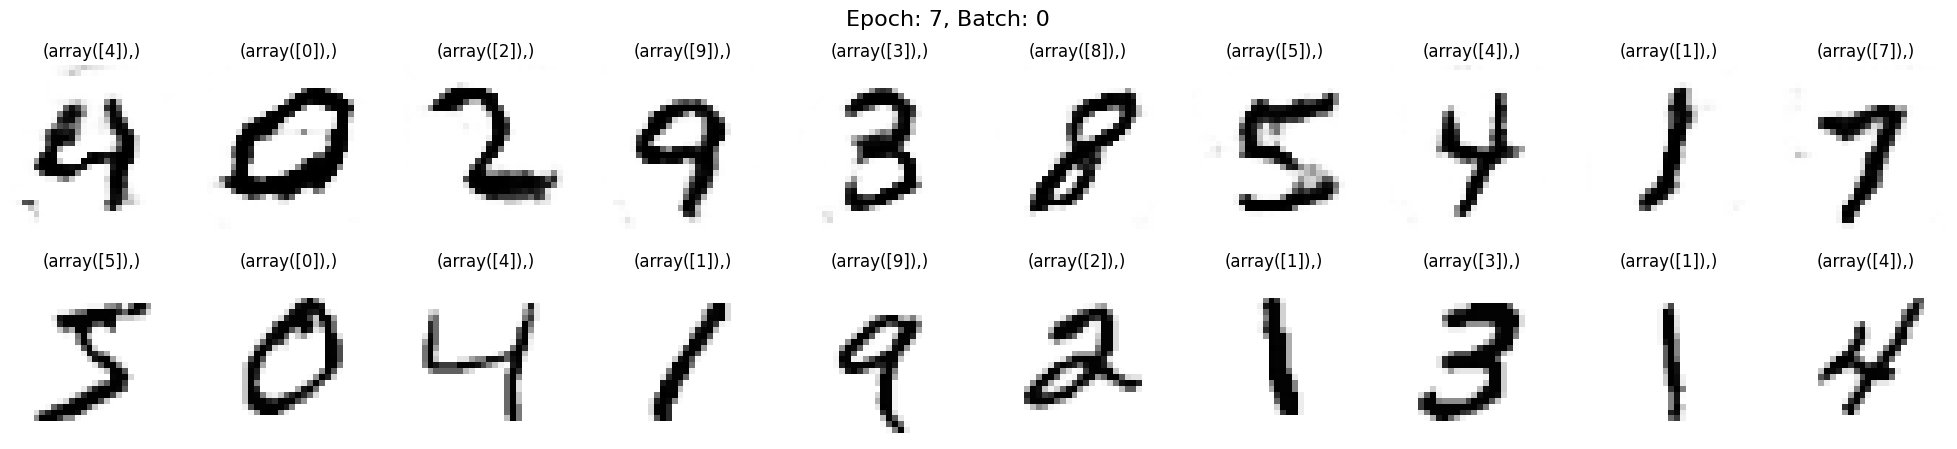

50 [D loss: 0.7101,	 acc.: 59.38%]	[G loss: 0.7112]
100 [D loss: 0.7282,	 acc.: 51.56%]	[G loss: 0.7645]
150 [D loss: 0.7257,	 acc.: 53.12%]	[G loss: 0.7107]
200 [D loss: 0.7326,	 acc.: 43.75%]	[G loss: 0.7128]
250 [D loss: 0.7515,	 acc.: 46.88%]	[G loss: 0.7067]
300 [D loss: 0.7431,	 acc.: 46.88%]	[G loss: 0.6648]
350 [D loss: 0.7207,	 acc.: 56.25%]	[G loss: 0.9215]
400 [D loss: 0.7245,	 acc.: 34.38%]	[G loss: 0.6974]
450 [D loss: 0.7171,	 acc.: 48.44%]	[G loss: 0.8897]
500 [D loss: 0.7897,	 acc.: 37.50%]	[G loss: 0.6848]


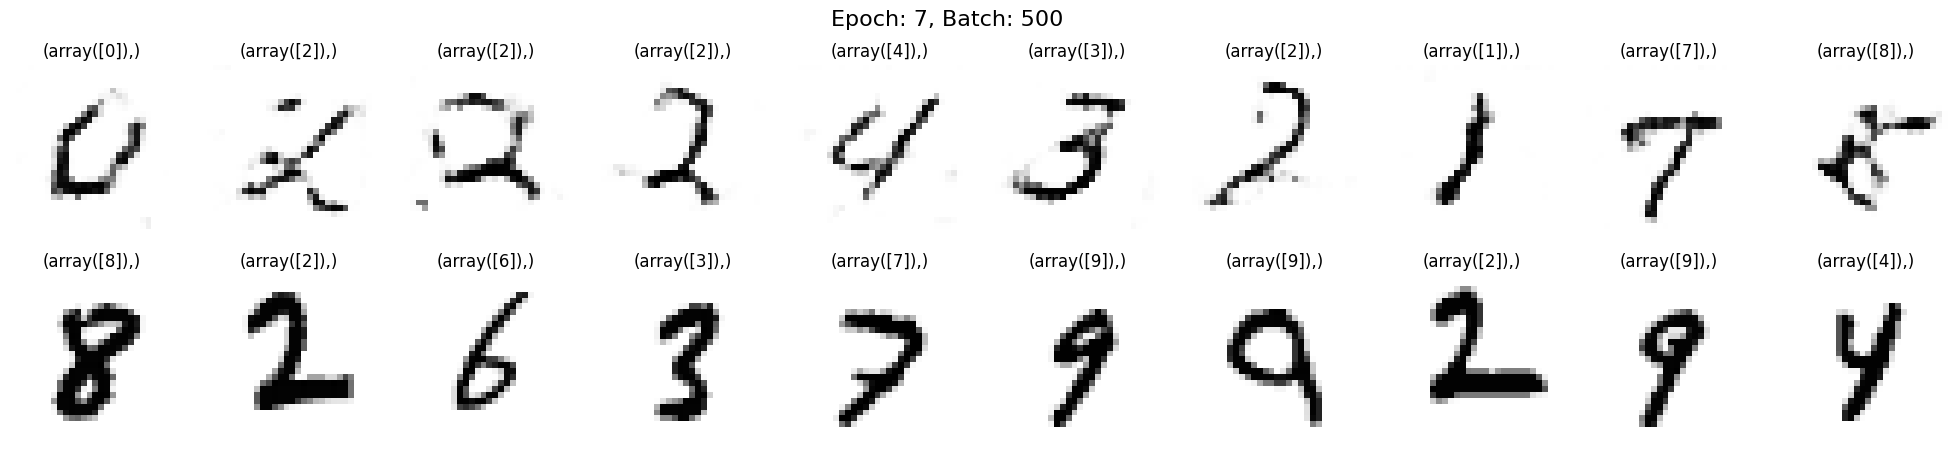

550 [D loss: 0.7090,	 acc.: 59.38%]	[G loss: 0.6999]
600 [D loss: 0.7017,	 acc.: 59.38%]	[G loss: 0.7404]
650 [D loss: 0.6942,	 acc.: 60.94%]	[G loss: 0.7223]
700 [D loss: 0.6865,	 acc.: 59.38%]	[G loss: 0.7777]
750 [D loss: 0.6885,	 acc.: 60.94%]	[G loss: 0.7573]
800 [D loss: 0.7574,	 acc.: 48.44%]	[G loss: 0.6330]
850 [D loss: 0.6974,	 acc.: 65.62%]	[G loss: 0.7110]
900 [D loss: 0.6911,	 acc.: 54.69%]	[G loss: 0.6798]
950 [D loss: 0.6786,	 acc.: 59.38%]	[G loss: 0.9386]
1000 [D loss: 0.7431,	 acc.: 39.06%]	[G loss: 0.6755]


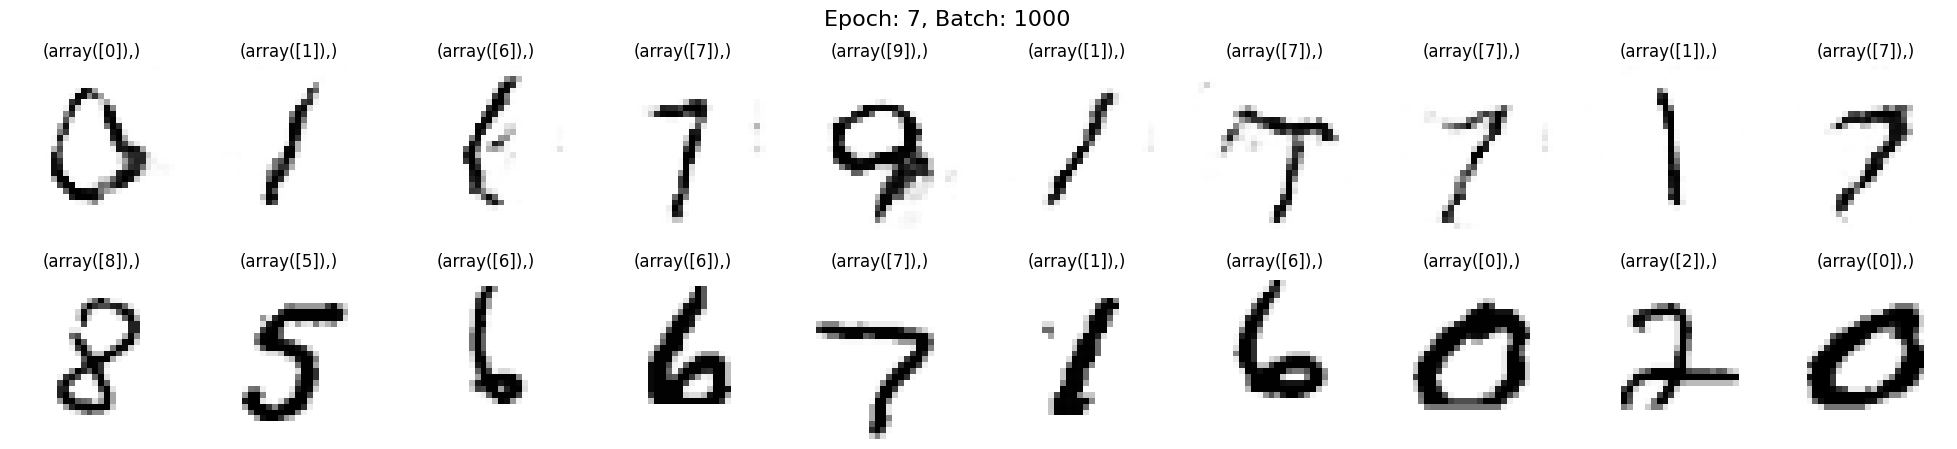

1050 [D loss: 0.6662,	 acc.: 59.38%]	[G loss: 0.8537]
1100 [D loss: 0.6761,	 acc.: 53.12%]	[G loss: 0.7501]
1150 [D loss: 0.6804,	 acc.: 57.81%]	[G loss: 0.6686]
1200 [D loss: 0.6886,	 acc.: 60.94%]	[G loss: 0.9694]
1250 [D loss: 0.6954,	 acc.: 56.25%]	[G loss: 0.6952]
1300 [D loss: 0.6742,	 acc.: 62.50%]	[G loss: 0.8095]
1350 [D loss: 0.6995,	 acc.: 60.94%]	[G loss: 0.7309]
1400 [D loss: 0.6759,	 acc.: 50.00%]	[G loss: 0.6731]
1450 [D loss: 0.7332,	 acc.: 51.56%]	[G loss: 0.8427]
1500 [D loss: 0.7111,	 acc.: 54.69%]	[G loss: 0.6799]


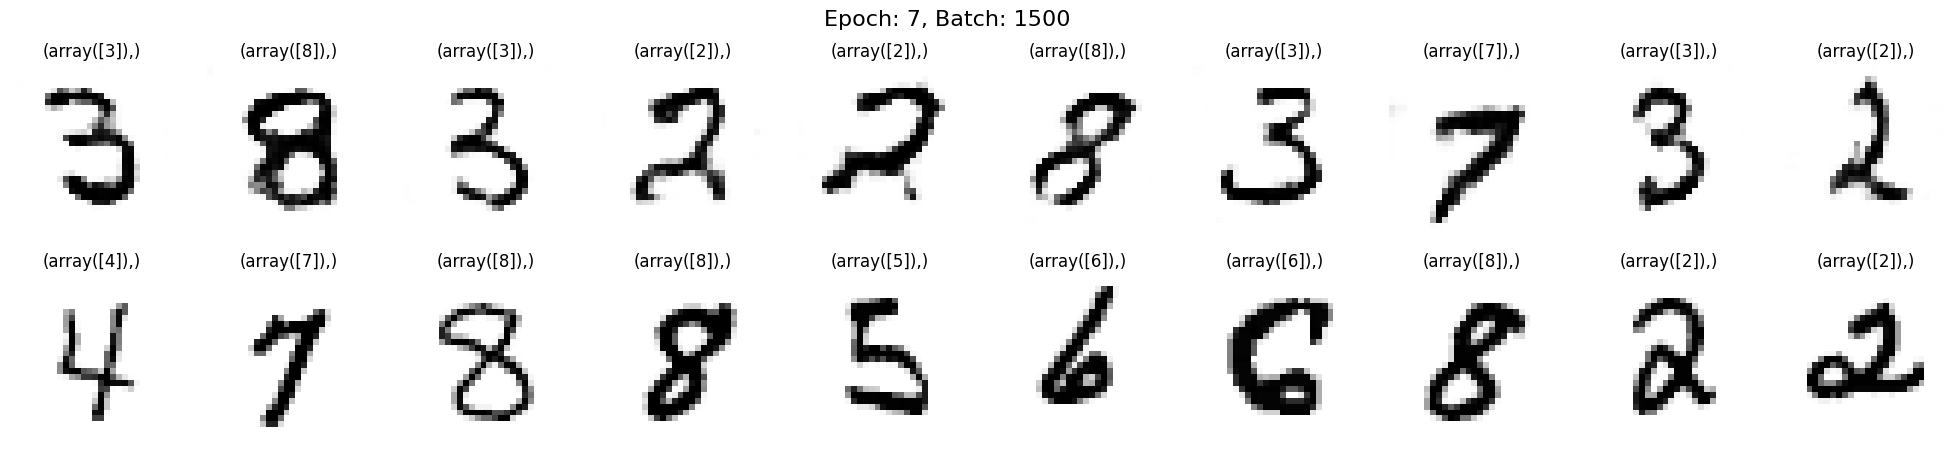

1550 [D loss: 0.6706,	 acc.: 56.25%]	[G loss: 0.9589]
1600 [D loss: 0.7120,	 acc.: 50.00%]	[G loss: 0.6603]
1650 [D loss: 0.7100,	 acc.: 60.94%]	[G loss: 0.7886]
1700 [D loss: 0.7046,	 acc.: 57.81%]	[G loss: 0.7117]
1750 [D loss: 0.6931,	 acc.: 51.56%]	[G loss: 0.6626]
1800 [D loss: 0.7069,	 acc.: 65.62%]	[G loss: 0.8111]
1850 [D loss: 0.6532,	 acc.: 68.75%]	[G loss: 0.7038]


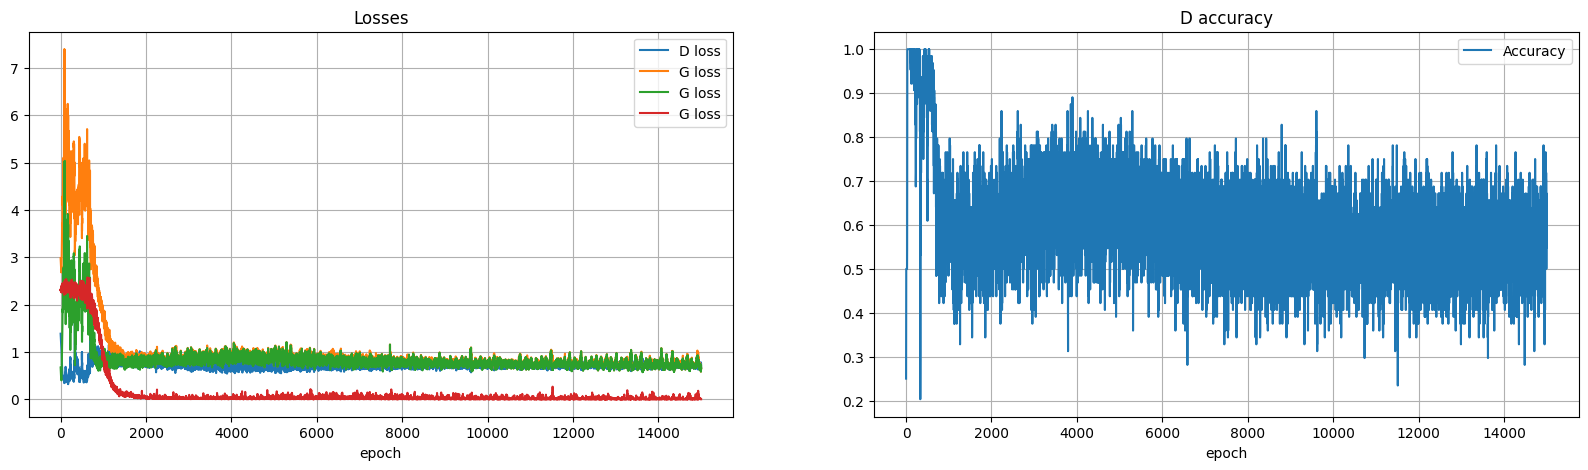

----EPOCH 8-----
0 [D loss: 0.7396,	 acc.: 50.00%]	[G loss: 0.6907]


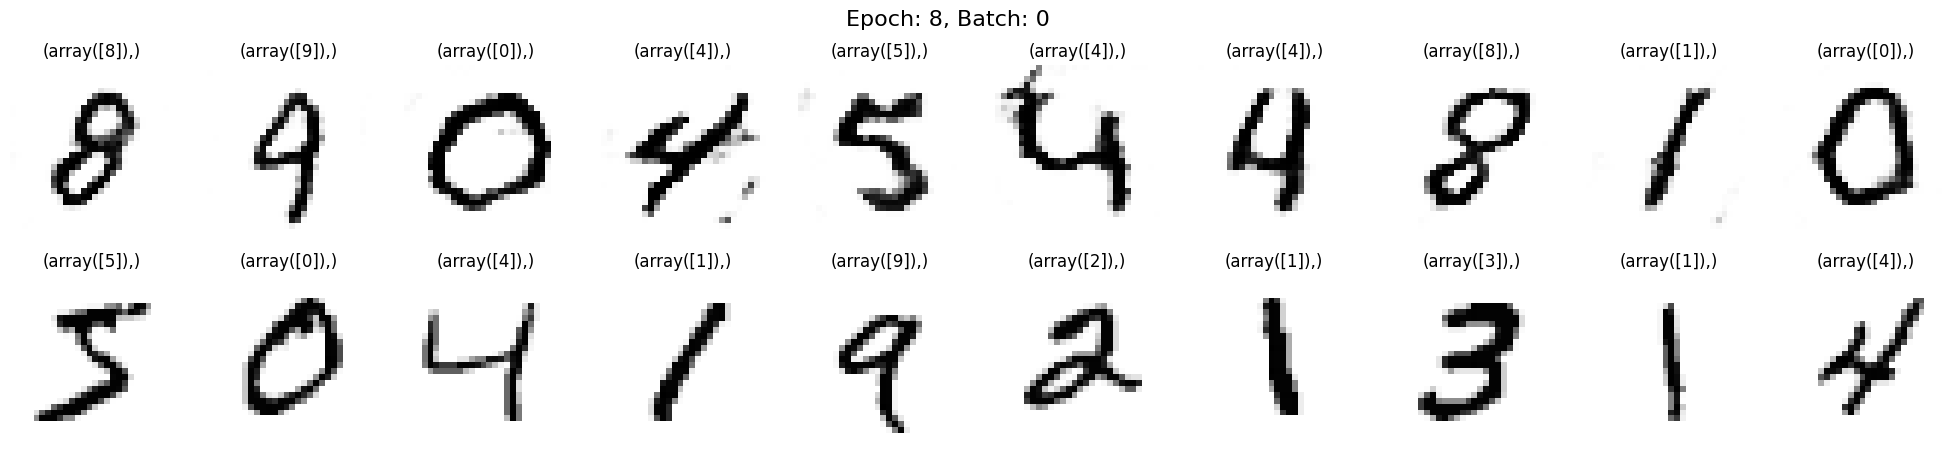

50 [D loss: 0.6969,	 acc.: 60.94%]	[G loss: 0.7712]
100 [D loss: 0.7078,	 acc.: 56.25%]	[G loss: 0.6552]
150 [D loss: 0.6781,	 acc.: 59.38%]	[G loss: 0.7617]
200 [D loss: 0.7322,	 acc.: 51.56%]	[G loss: 0.6772]
250 [D loss: 0.6766,	 acc.: 54.69%]	[G loss: 0.6812]
300 [D loss: 0.7029,	 acc.: 56.25%]	[G loss: 0.8112]
350 [D loss: 0.7013,	 acc.: 62.50%]	[G loss: 0.7611]
400 [D loss: 0.7229,	 acc.: 57.81%]	[G loss: 0.7164]
450 [D loss: 0.7072,	 acc.: 56.25%]	[G loss: 0.8883]
500 [D loss: 0.7460,	 acc.: 39.06%]	[G loss: 0.6172]


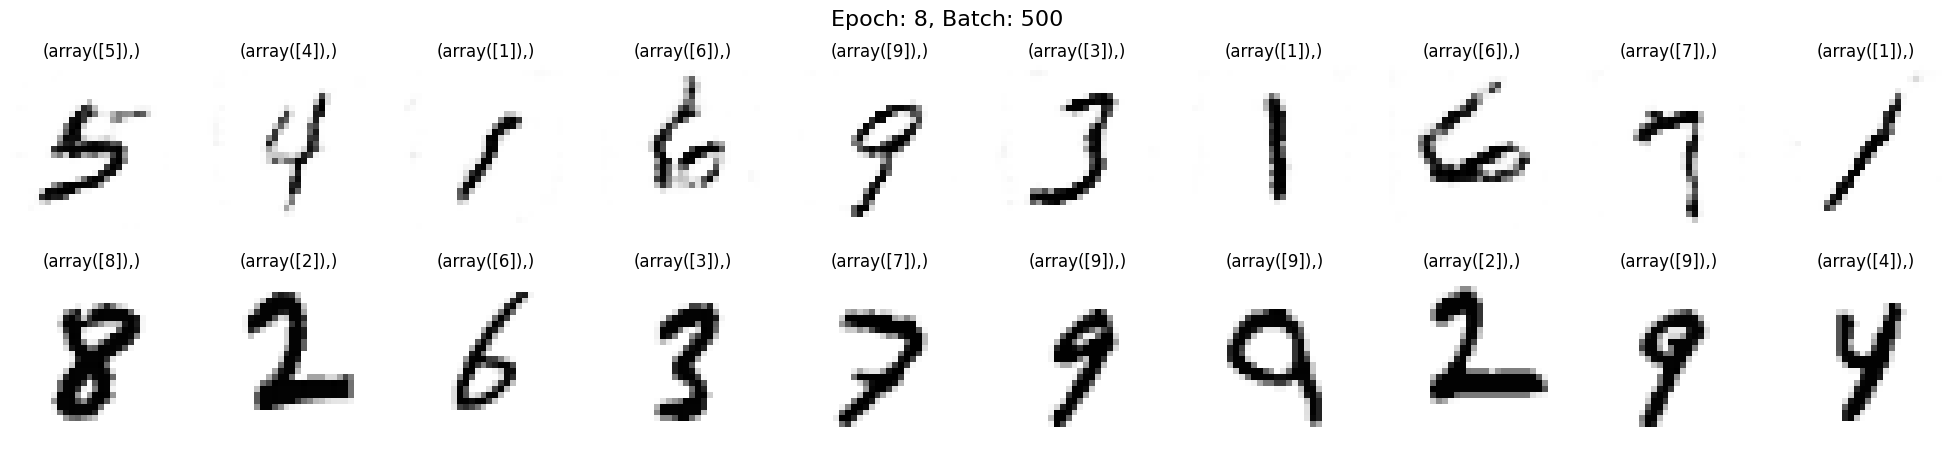

550 [D loss: 0.6796,	 acc.: 60.94%]	[G loss: 0.7322]
600 [D loss: 0.7093,	 acc.: 57.81%]	[G loss: 0.8591]
650 [D loss: 0.7105,	 acc.: 53.12%]	[G loss: 0.6801]
700 [D loss: 0.7072,	 acc.: 57.81%]	[G loss: 0.8468]
750 [D loss: 0.6799,	 acc.: 62.50%]	[G loss: 0.7178]
800 [D loss: 0.7192,	 acc.: 56.25%]	[G loss: 0.6866]
850 [D loss: 0.7119,	 acc.: 57.81%]	[G loss: 0.7656]
900 [D loss: 0.7341,	 acc.: 43.75%]	[G loss: 0.6682]
950 [D loss: 0.6920,	 acc.: 56.25%]	[G loss: 0.9435]
1000 [D loss: 0.7791,	 acc.: 37.50%]	[G loss: 0.6400]


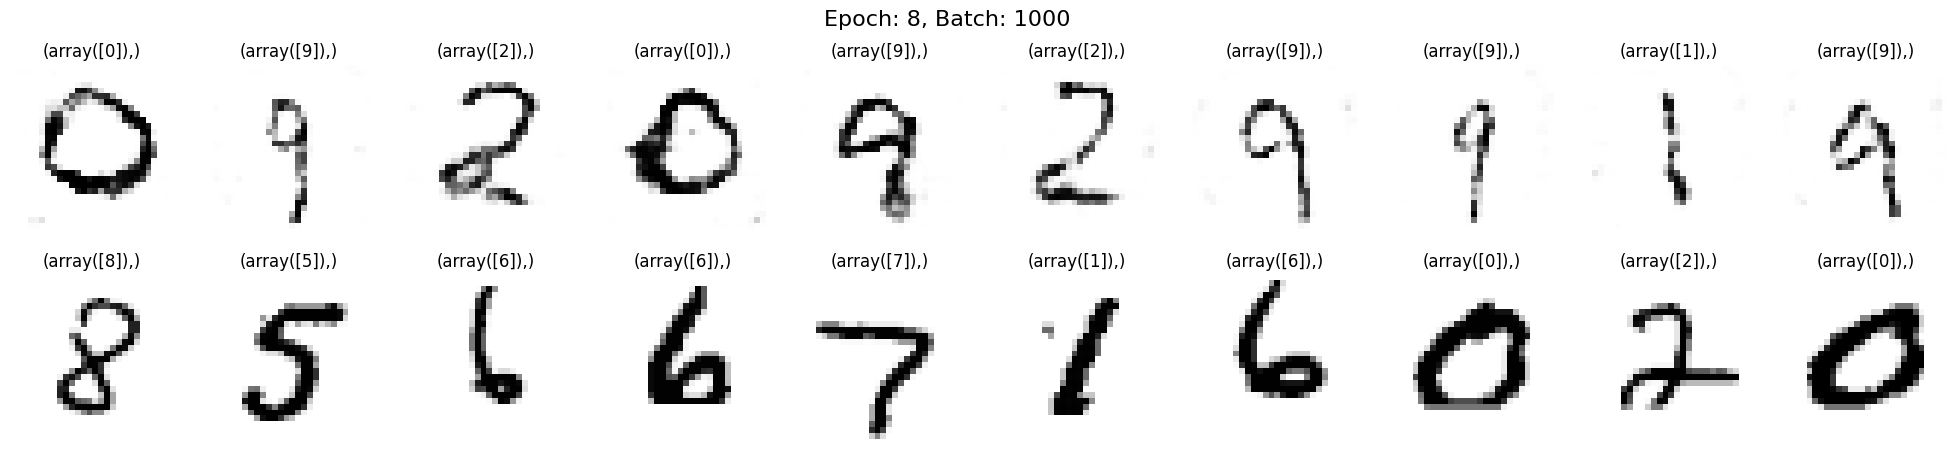

1050 [D loss: 0.7114,	 acc.: 54.69%]	[G loss: 0.7825]
1100 [D loss: 0.6469,	 acc.: 70.31%]	[G loss: 0.7730]
1150 [D loss: 0.6878,	 acc.: 67.19%]	[G loss: 0.6997]
1200 [D loss: 0.7713,	 acc.: 42.19%]	[G loss: 0.7215]
1250 [D loss: 0.6825,	 acc.: 60.94%]	[G loss: 0.9247]
1300 [D loss: 0.6836,	 acc.: 59.38%]	[G loss: 0.7165]
1350 [D loss: 0.7362,	 acc.: 54.69%]	[G loss: 0.7047]
1400 [D loss: 0.7090,	 acc.: 56.25%]	[G loss: 0.8487]
1450 [D loss: 0.7131,	 acc.: 51.56%]	[G loss: 0.6982]
1500 [D loss: 0.7373,	 acc.: 50.00%]	[G loss: 0.6906]


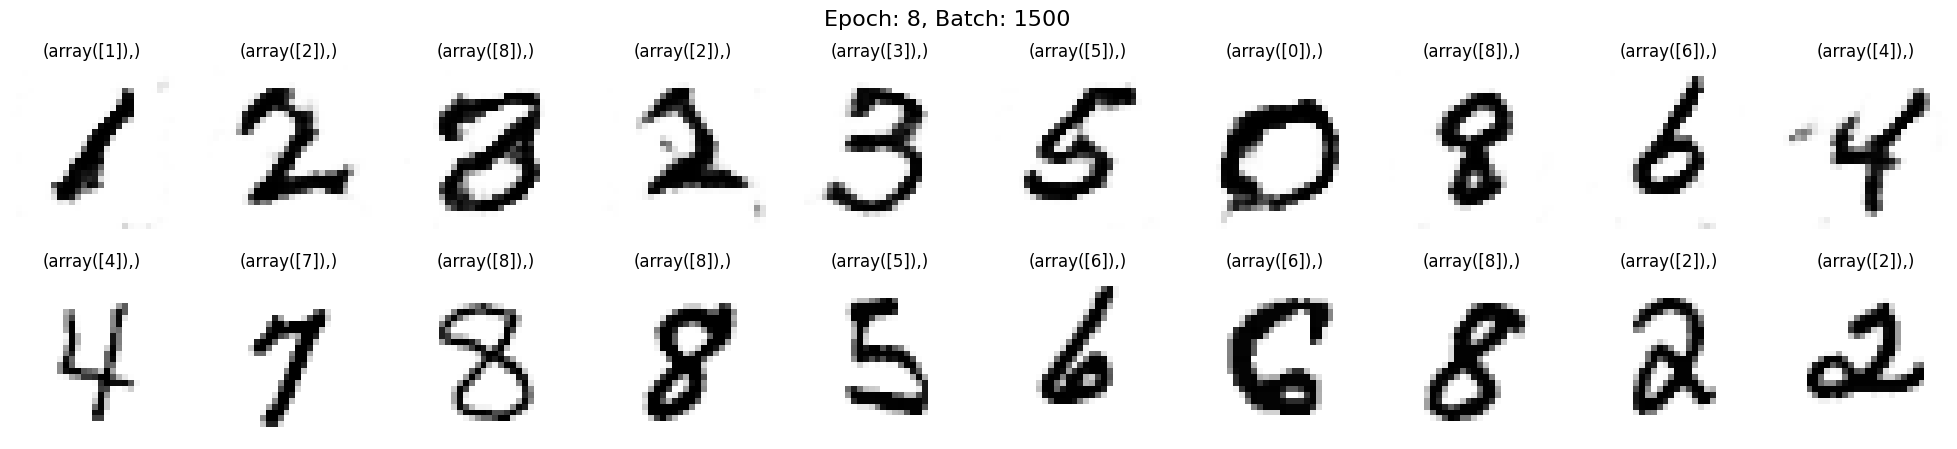

1550 [D loss: 0.6824,	 acc.: 57.81%]	[G loss: 0.8884]
1600 [D loss: 0.6601,	 acc.: 62.50%]	[G loss: 0.7051]
1650 [D loss: 0.6882,	 acc.: 59.38%]	[G loss: 0.7642]
1700 [D loss: 0.7300,	 acc.: 46.88%]	[G loss: 0.6817]
1750 [D loss: 0.6761,	 acc.: 60.94%]	[G loss: 0.7169]
1800 [D loss: 0.6910,	 acc.: 59.38%]	[G loss: 0.7980]
1850 [D loss: 0.7087,	 acc.: 51.56%]	[G loss: 0.6824]


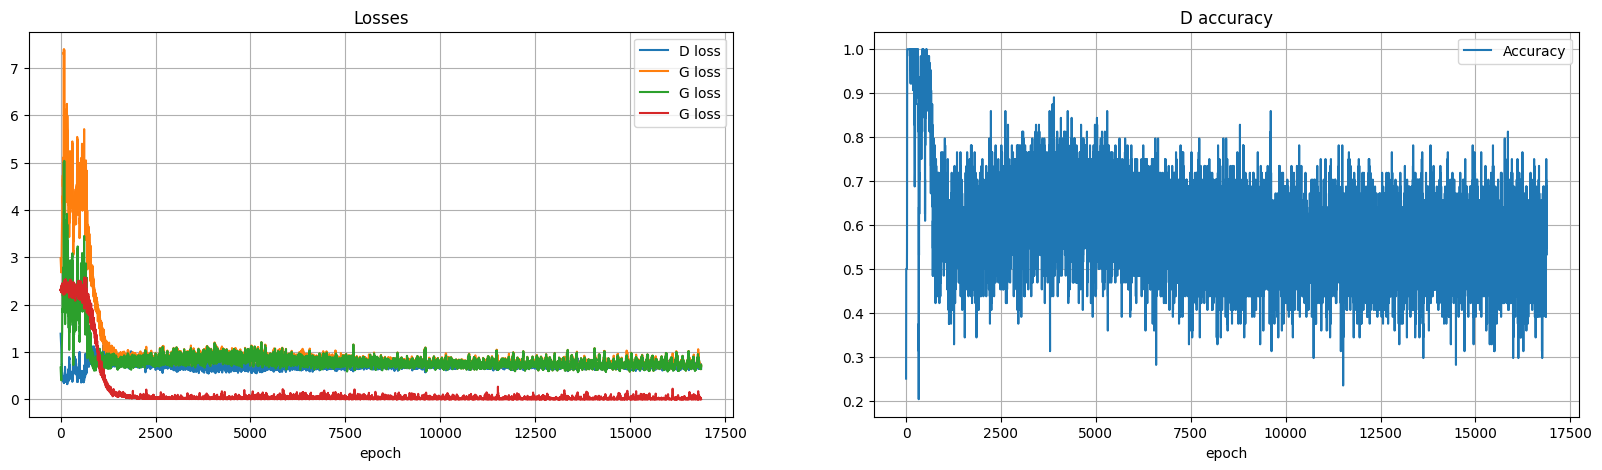

----EPOCH 9-----
0 [D loss: 0.6884,	 acc.: 57.81%]	[G loss: 0.7025]


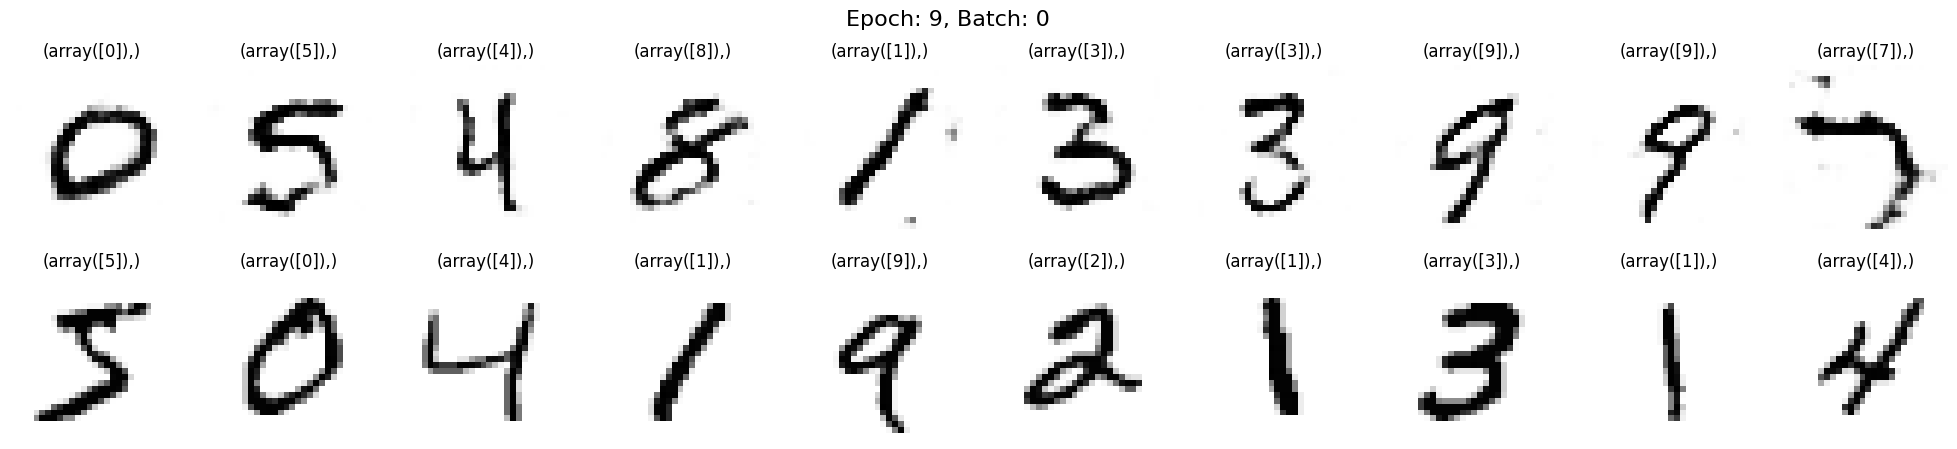

50 [D loss: 0.6959,	 acc.: 59.38%]	[G loss: 0.7907]
100 [D loss: 0.7093,	 acc.: 53.12%]	[G loss: 0.7287]
150 [D loss: 0.6583,	 acc.: 65.62%]	[G loss: 0.6905]
200 [D loss: 0.7332,	 acc.: 46.88%]	[G loss: 0.7929]
250 [D loss: 0.7429,	 acc.: 45.31%]	[G loss: 0.6245]
300 [D loss: 0.6771,	 acc.: 60.94%]	[G loss: 0.7121]
350 [D loss: 0.7419,	 acc.: 53.12%]	[G loss: 0.8280]
400 [D loss: 0.7302,	 acc.: 51.56%]	[G loss: 0.6745]
450 [D loss: 0.6988,	 acc.: 56.25%]	[G loss: 0.6459]
500 [D loss: 0.7177,	 acc.: 45.31%]	[G loss: 0.8249]


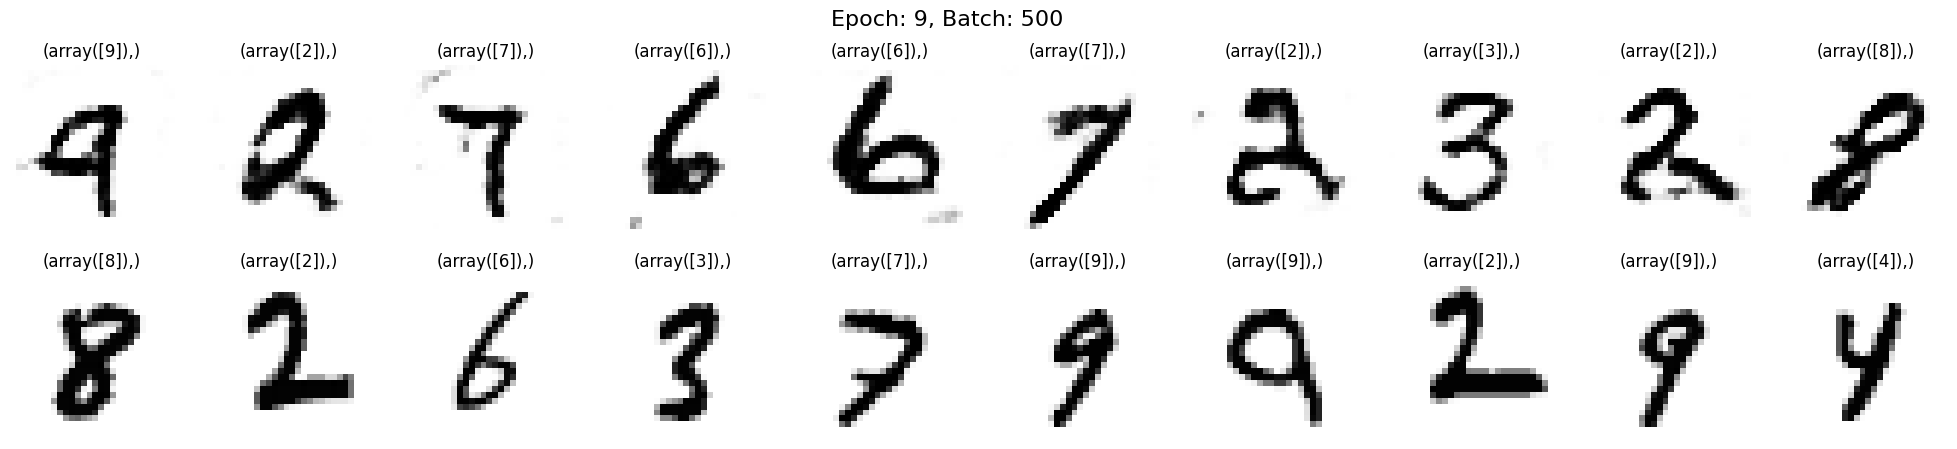

550 [D loss: 0.6943,	 acc.: 59.38%]	[G loss: 0.7371]
600 [D loss: 0.6907,	 acc.: 56.25%]	[G loss: 0.6713]
650 [D loss: 0.7375,	 acc.: 40.62%]	[G loss: 0.7963]
700 [D loss: 0.7317,	 acc.: 43.75%]	[G loss: 0.6901]
750 [D loss: 0.6711,	 acc.: 59.38%]	[G loss: 0.7012]
800 [D loss: 0.6853,	 acc.: 59.38%]	[G loss: 0.8223]
850 [D loss: 0.6982,	 acc.: 54.69%]	[G loss: 0.7215]
900 [D loss: 0.6835,	 acc.: 59.38%]	[G loss: 0.6912]
950 [D loss: 0.7054,	 acc.: 57.81%]	[G loss: 0.9439]
1000 [D loss: 0.7285,	 acc.: 54.69%]	[G loss: 0.6567]


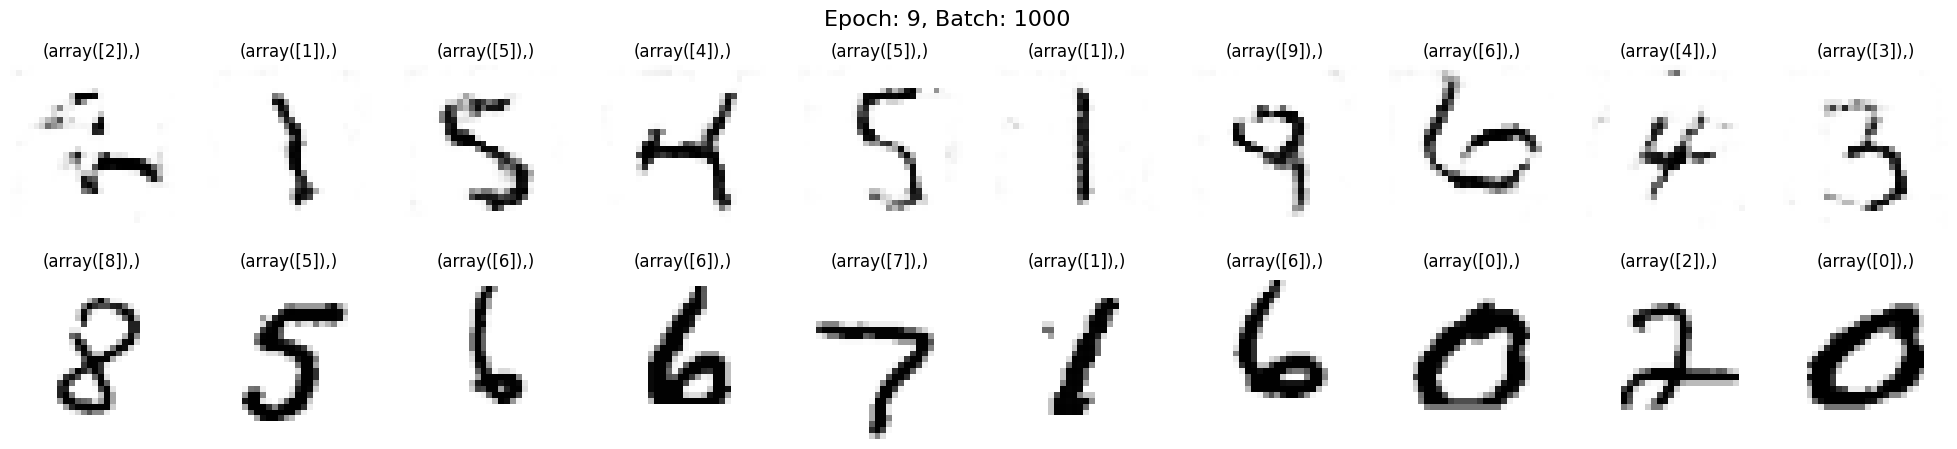

1050 [D loss: 0.7377,	 acc.: 45.31%]	[G loss: 0.7082]
1100 [D loss: 0.6969,	 acc.: 54.69%]	[G loss: 0.7690]
1150 [D loss: 0.7236,	 acc.: 50.00%]	[G loss: 0.6530]
1200 [D loss: 0.7008,	 acc.: 56.25%]	[G loss: 0.7401]
1250 [D loss: 0.7034,	 acc.: 59.38%]	[G loss: 0.8061]
1300 [D loss: 0.6884,	 acc.: 54.69%]	[G loss: 0.7445]
1350 [D loss: 0.6652,	 acc.: 68.75%]	[G loss: 0.7495]
1400 [D loss: 0.6490,	 acc.: 62.50%]	[G loss: 0.8069]
1450 [D loss: 0.6714,	 acc.: 65.62%]	[G loss: 0.6909]
1500 [D loss: 0.7008,	 acc.: 50.00%]	[G loss: 0.6841]


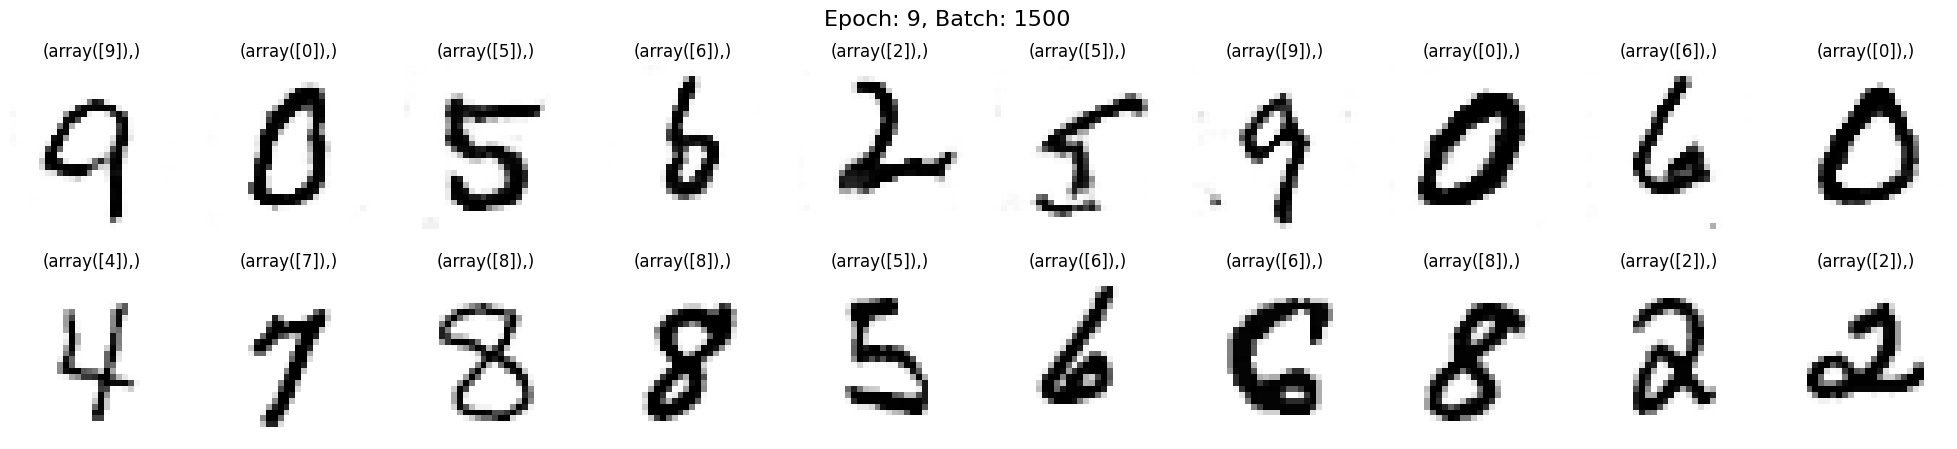

1550 [D loss: 0.6894,	 acc.: 67.19%]	[G loss: 0.8914]
1600 [D loss: 0.7289,	 acc.: 48.44%]	[G loss: 0.6406]
1650 [D loss: 0.7457,	 acc.: 48.44%]	[G loss: 0.6320]
1700 [D loss: 0.7139,	 acc.: 57.81%]	[G loss: 0.7845]
1750 [D loss: 0.6747,	 acc.: 68.75%]	[G loss: 0.6554]
1800 [D loss: 0.6998,	 acc.: 57.81%]	[G loss: 0.8291]
1850 [D loss: 0.6977,	 acc.: 53.12%]	[G loss: 0.7092]


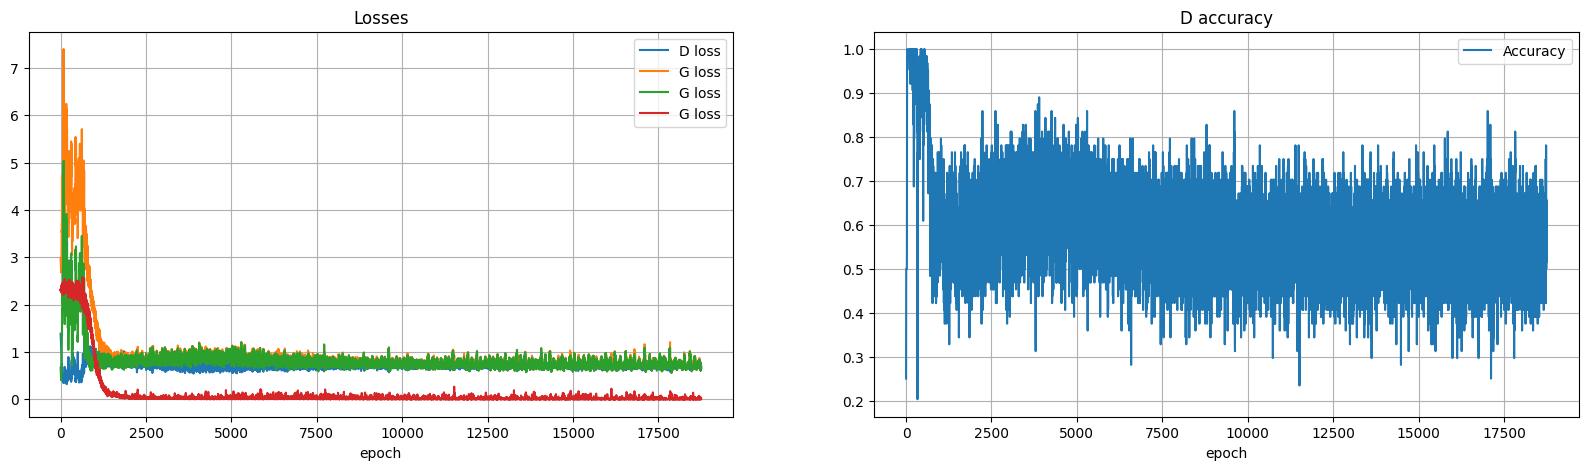

In [ ]:
train(X_train, y_train, generator, discriminator, combined, epochs=10, batch_size=32, sample_interval=100)

> Estoy bastante contento con los resultados, considero que hay una buena variedad de números, en el epoch 9 a pesar de haber un batch (el 1000) con peor calidad creo que puedo asegurar que la ACGAN cumple con las expectativas ya que podemos observar todos los números del mnist, no hay colapso modal o al menos no es tan pronunciado como en los otros entrenamientos de la DCGAN.

> Si comparo el rendimiento de el DCGAN con este, puedo asegurar que mi ACGAN ha superado a mi DCGAN, ya no solo en calidad o en variedad sino también en las propias métricas de accuracy que tanto sufrimiento me dieron en la parte 1, estoy muy contento con los resultados.

> Sin embargo, voy a intentar mejorarlos retocando la arquitectura de la ACGAN de cara a buscar un segundo y último entrenamiento.

# Train 2

## Generator definition

> Voy a añadir una nueva capa convulucional, y varias de dropout que son las que mejor resultados me han dado.

In [ ]:
def create_generator():
    # Introducir una nueva entrada input_label y concatenerla con input_z para formar la entrada de la red
    input_z = Input(shape=(100,))
    input_label = Input(shape=(10,))

    # Cambiar el modelo para que ahora admita las dos entradas

    x = Concatenate(axis=-1)([input_z,input_label])

    x = Dense(256 * 7 * 7, activation="relu", input_dim=100)(x)

    x = Reshape((7, 7, 256))(x)


    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.01)(x)

    x = Dropout(0.2)(x)

    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.01)(x)

    x = Dropout(0.2)(x)

    x = Conv2DTranspose(32, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.01)(x)

    x = Dropout(0.2)(x)

    x = Conv2DTranspose(16, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.01)(x)

    x = Conv2DTranspose(1, kernel_size=3, strides=1, padding="same")(x)
    output = Activation("tanh")(x)



    generator = Model([input_z, input_label], output)

    return generator

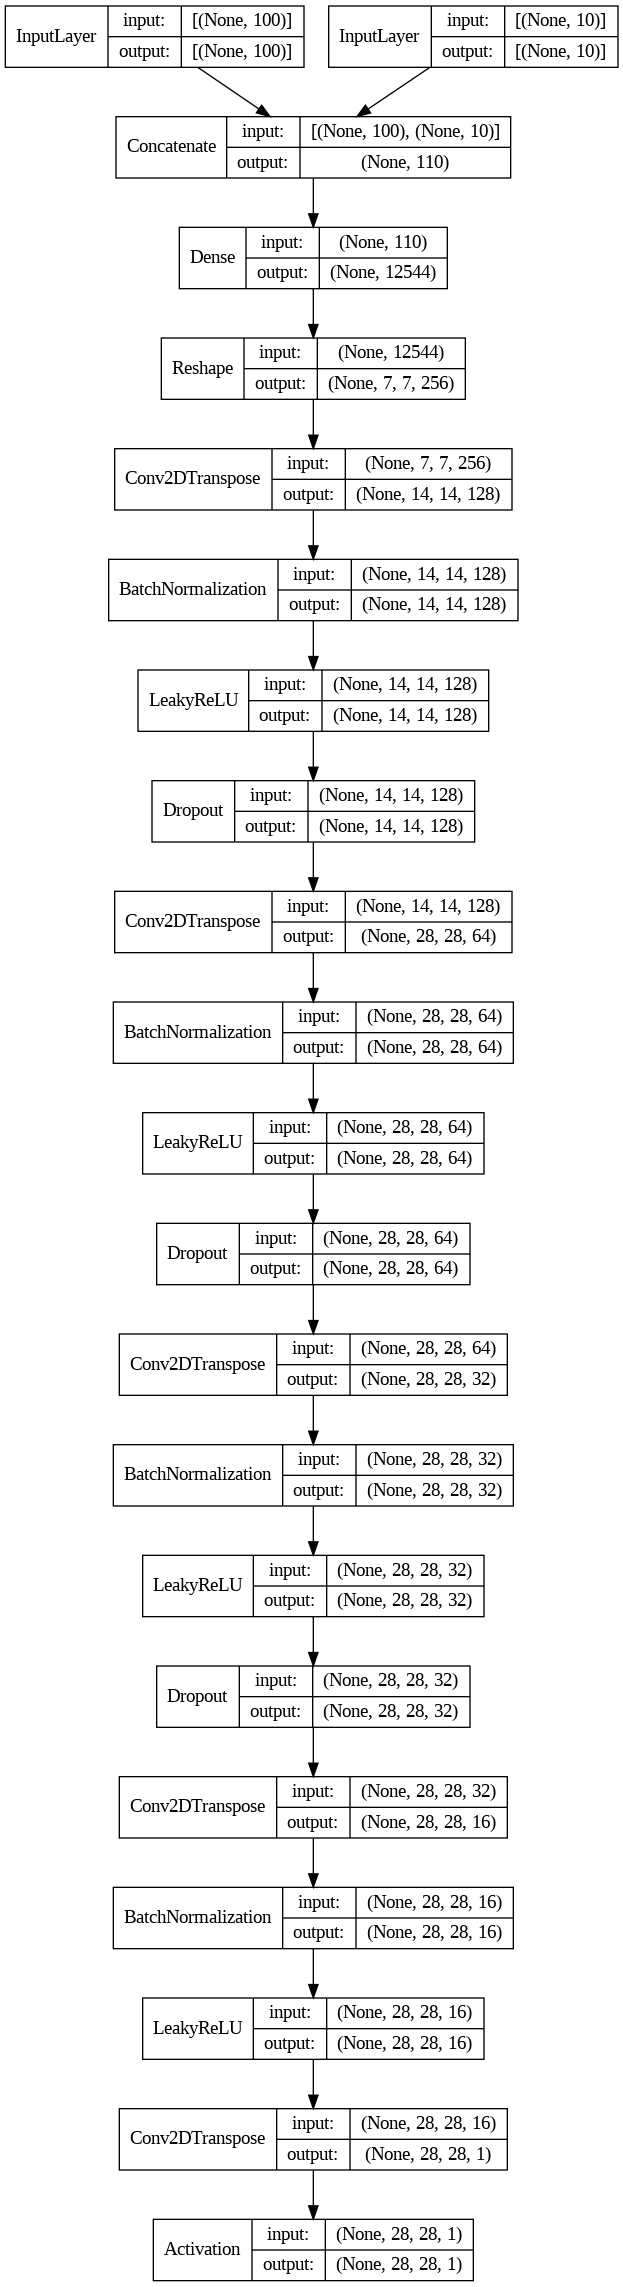

In [ ]:
generator = create_generator()
plot_model(generator, show_shapes=True, show_layer_names=False)

## Discriminator definition

> Voy a mantener la misma configuración del train 1

In [ ]:
def create_discriminator():
    input = Input(shape=(28,28,1))

    x = Conv2D(32, kernel_size=5, strides=2, padding="same")(input)
    x = LeakyReLU(alpha=0.01)(x)

    x = Dropout(0.2)(x)

    x = Conv2D(64, kernel_size=5, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.01)(x)

    x = Dropout(0.2)(x)

    x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)

    x = Dropout(0.2)(x)

    x = Flatten()(x)

    disc_output = Dense(1,activation='sigmoid')(x)
    class_output = Dense(10,activation='softmax')(x)

    discriminator = Model(input, [disc_output,class_output])

    return discriminator

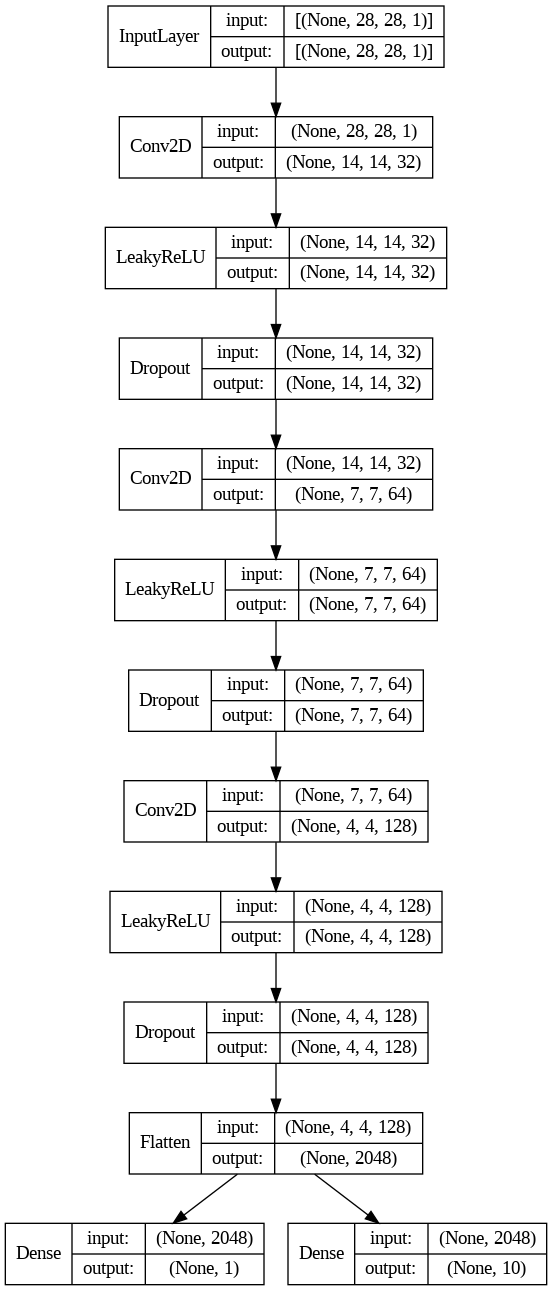

In [ ]:
discriminator = create_discriminator()
plot_model(discriminator, show_shapes=True, show_layer_names=False)

## GAN model definition

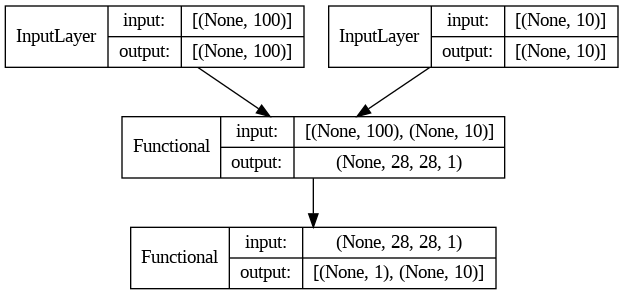

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
discriminator.trainable = False

z = Input(shape=(100,))
# Crear una nueva entrada label que tenga tantas dimensiones como clases
label = Input(shape=(10,))

# Introducir al generador las entradas z y label al mismo tiempo
img = generator([z,label])

# Obtener del discriminador las salidas validity y target_label a la vez
validity, target_label = discriminator(img)


# Modificar combined para que el modelo admita ambas entradas y salidas
combined = Model([z, label], [validity,target_label])
# Compilar el modelo para que ahora tenga 2 funciones de pérdida:
    # binary_crossentropy: para la salida de validez
    # categorical_crossentropy: para la salida de clasificación de etiqueta
combined.compile(loss= ['binary_crossentropy', 'categorical_crossentropy'], optimizer=Adam(learning_rate=0.0001))

plot_model(combined, show_shapes=True, show_layer_names=False)

## Resultados

----EPOCH 0-----
0 [D loss: 1.3941,	 acc.: 18.75%]	[G loss: 2.9778]


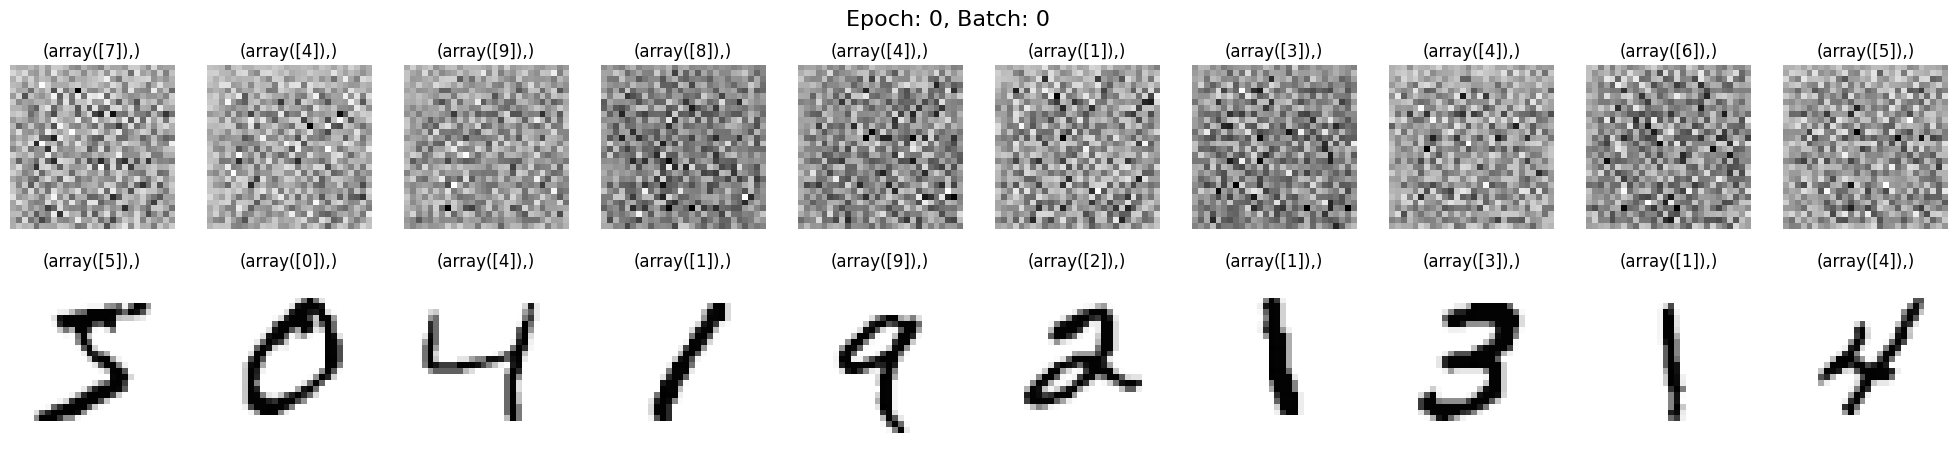

50 [D loss: 0.4529,	 acc.: 100.00%]	[G loss: 4.3191]
100 [D loss: 0.3708,	 acc.: 100.00%]	[G loss: 4.9544]
150 [D loss: 0.8446,	 acc.: 73.44%]	[G loss: 3.6992]
200 [D loss: 1.0431,	 acc.: 51.56%]	[G loss: 3.4475]
250 [D loss: 0.9678,	 acc.: 65.62%]	[G loss: 3.7051]
300 [D loss: 0.6323,	 acc.: 92.19%]	[G loss: 4.2160]
350 [D loss: 0.5576,	 acc.: 96.88%]	[G loss: 4.2376]
400 [D loss: 0.7078,	 acc.: 84.38%]	[G loss: 4.0775]
450 [D loss: 0.6942,	 acc.: 81.25%]	[G loss: 3.5744]
500 [D loss: 0.6890,	 acc.: 82.81%]	[G loss: 3.6133]


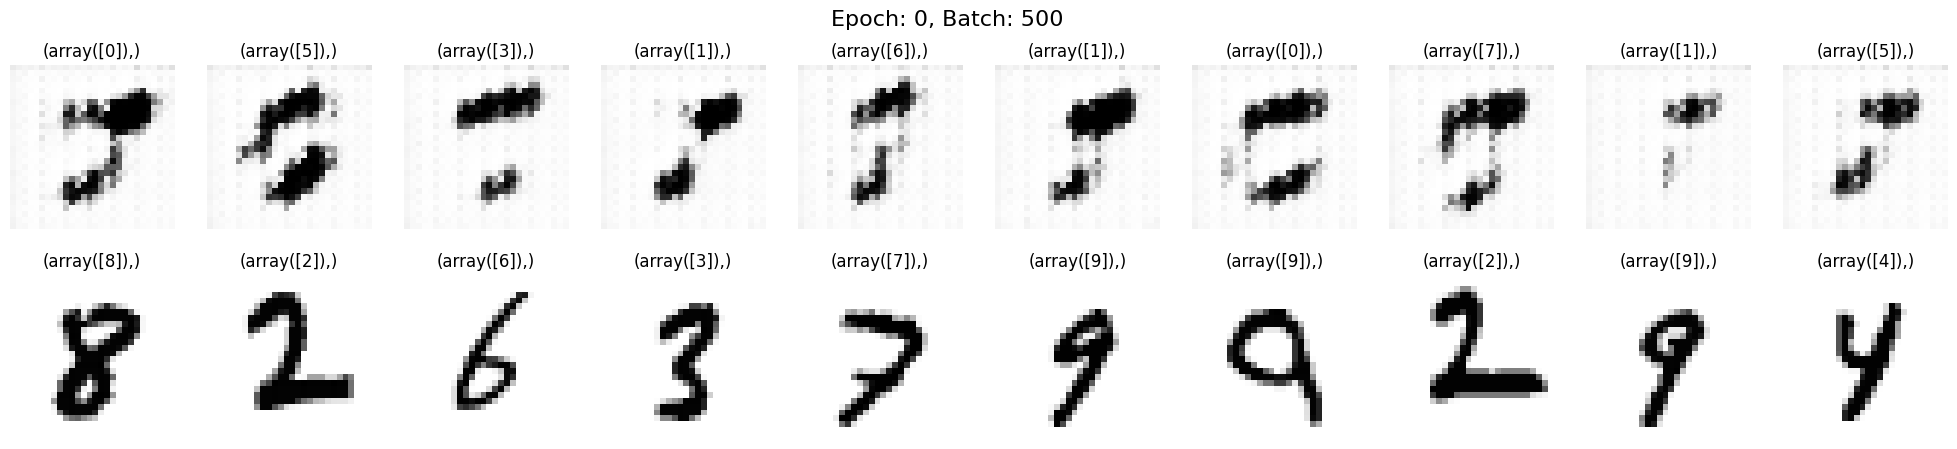

550 [D loss: 1.0030,	 acc.: 65.62%]	[G loss: 2.9266]
600 [D loss: 0.8982,	 acc.: 68.75%]	[G loss: 3.0590]
650 [D loss: 0.7040,	 acc.: 84.38%]	[G loss: 3.1946]
700 [D loss: 0.6740,	 acc.: 79.69%]	[G loss: 2.9926]
750 [D loss: 0.9085,	 acc.: 62.50%]	[G loss: 2.2778]
800 [D loss: 0.8139,	 acc.: 64.06%]	[G loss: 2.3399]
850 [D loss: 0.7855,	 acc.: 65.62%]	[G loss: 1.9866]
900 [D loss: 0.6956,	 acc.: 75.00%]	[G loss: 2.0121]
950 [D loss: 0.7248,	 acc.: 71.88%]	[G loss: 1.8482]
1000 [D loss: 0.8007,	 acc.: 67.19%]	[G loss: 1.6255]


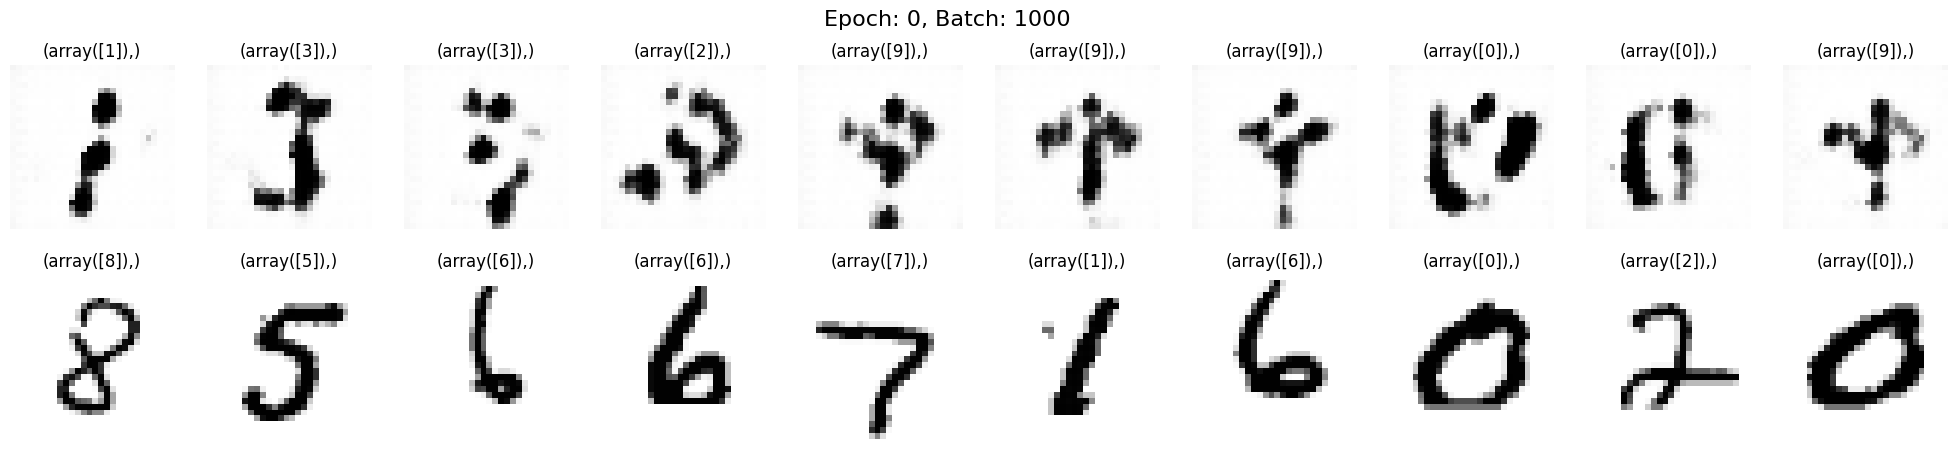

1050 [D loss: 0.7445,	 acc.: 75.00%]	[G loss: 1.2836]
1100 [D loss: 0.6747,	 acc.: 65.62%]	[G loss: 1.3024]
1150 [D loss: 0.8311,	 acc.: 54.69%]	[G loss: 1.1575]
1200 [D loss: 0.7331,	 acc.: 75.00%]	[G loss: 1.1265]
1250 [D loss: 0.7662,	 acc.: 60.94%]	[G loss: 1.1442]
1300 [D loss: 0.8342,	 acc.: 45.31%]	[G loss: 1.0971]
1350 [D loss: 0.7640,	 acc.: 54.69%]	[G loss: 1.0964]
1400 [D loss: 0.7259,	 acc.: 68.75%]	[G loss: 1.1621]
1450 [D loss: 0.8264,	 acc.: 57.81%]	[G loss: 0.9926]
1500 [D loss: 0.6936,	 acc.: 67.19%]	[G loss: 0.9624]


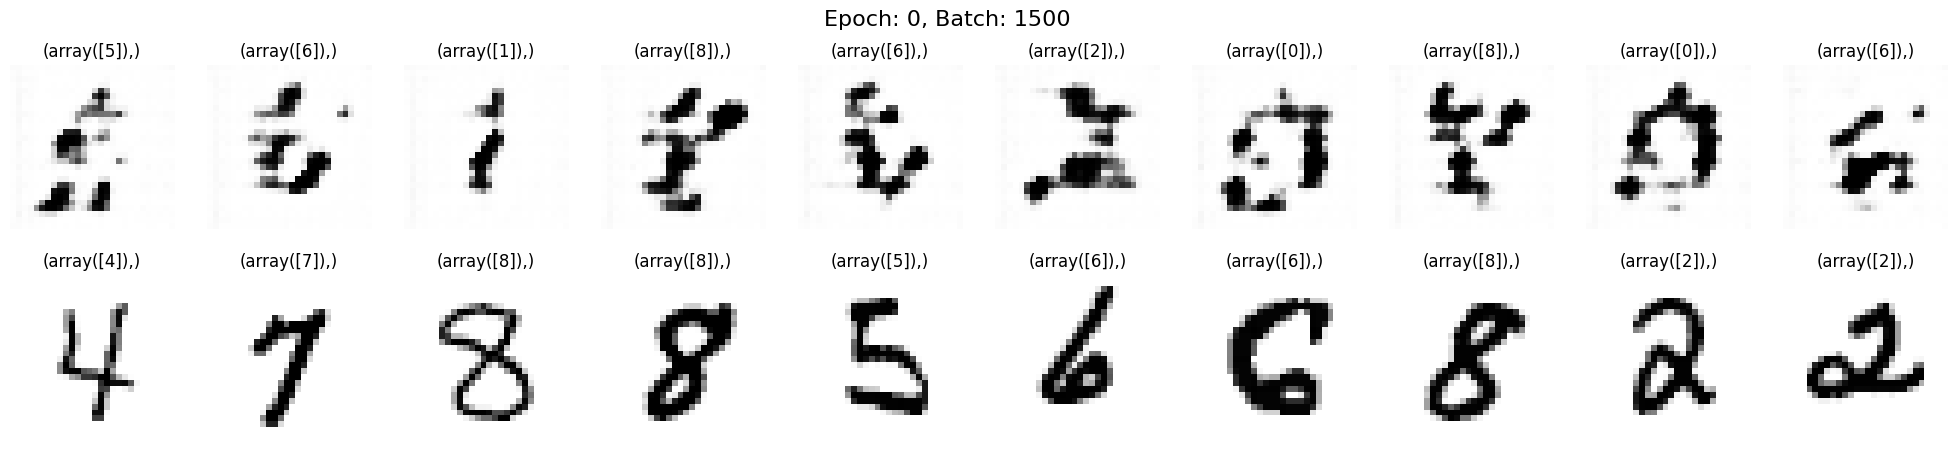

1550 [D loss: 0.6317,	 acc.: 79.69%]	[G loss: 1.0185]
1600 [D loss: 0.7404,	 acc.: 65.62%]	[G loss: 0.9919]
1650 [D loss: 0.7656,	 acc.: 59.38%]	[G loss: 1.0299]
1700 [D loss: 0.7775,	 acc.: 57.81%]	[G loss: 0.9170]
1750 [D loss: 0.7135,	 acc.: 60.94%]	[G loss: 0.9925]
1800 [D loss: 0.7540,	 acc.: 59.38%]	[G loss: 1.0132]
1850 [D loss: 0.6793,	 acc.: 67.19%]	[G loss: 1.1294]


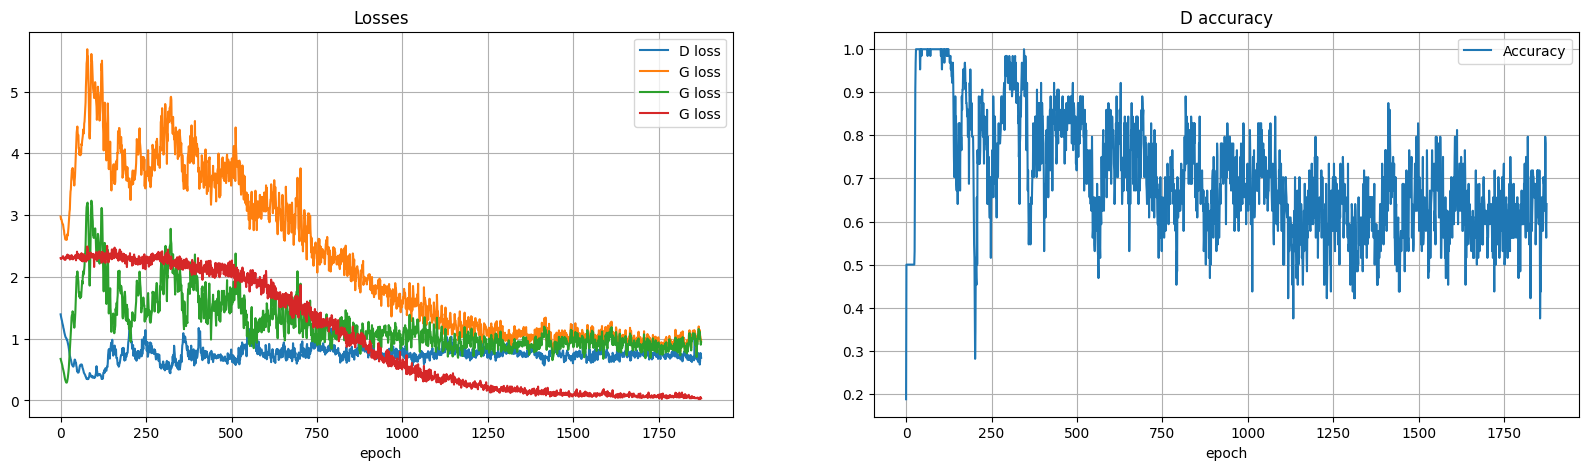

----EPOCH 1-----
0 [D loss: 0.7317,	 acc.: 59.38%]	[G loss: 0.9278]


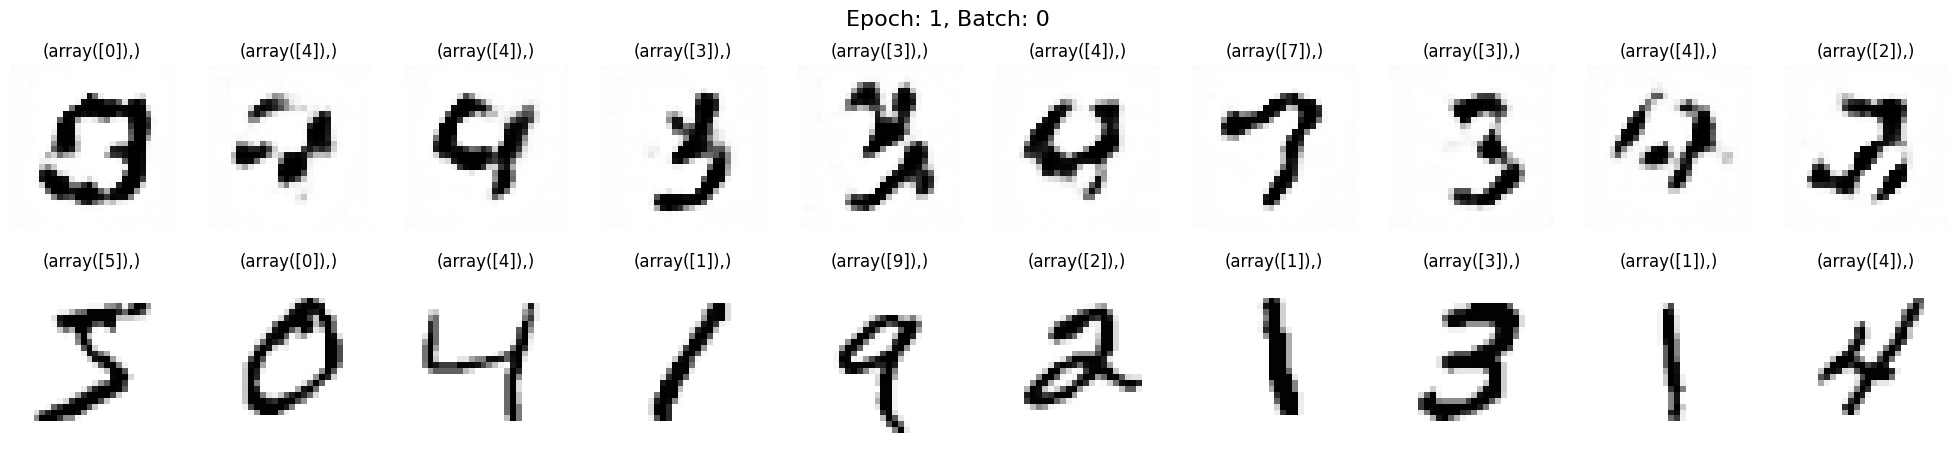

50 [D loss: 0.7500,	 acc.: 64.06%]	[G loss: 0.9640]
100 [D loss: 0.7425,	 acc.: 62.50%]	[G loss: 0.8615]
150 [D loss: 0.7133,	 acc.: 62.50%]	[G loss: 0.8291]
200 [D loss: 0.7162,	 acc.: 73.44%]	[G loss: 0.8987]
250 [D loss: 0.8107,	 acc.: 54.69%]	[G loss: 0.9070]
300 [D loss: 0.7072,	 acc.: 62.50%]	[G loss: 0.8682]
350 [D loss: 0.7510,	 acc.: 59.38%]	[G loss: 0.8778]
400 [D loss: 0.7678,	 acc.: 54.69%]	[G loss: 0.8817]
450 [D loss: 0.7435,	 acc.: 59.38%]	[G loss: 0.9021]
500 [D loss: 0.7136,	 acc.: 62.50%]	[G loss: 0.7829]


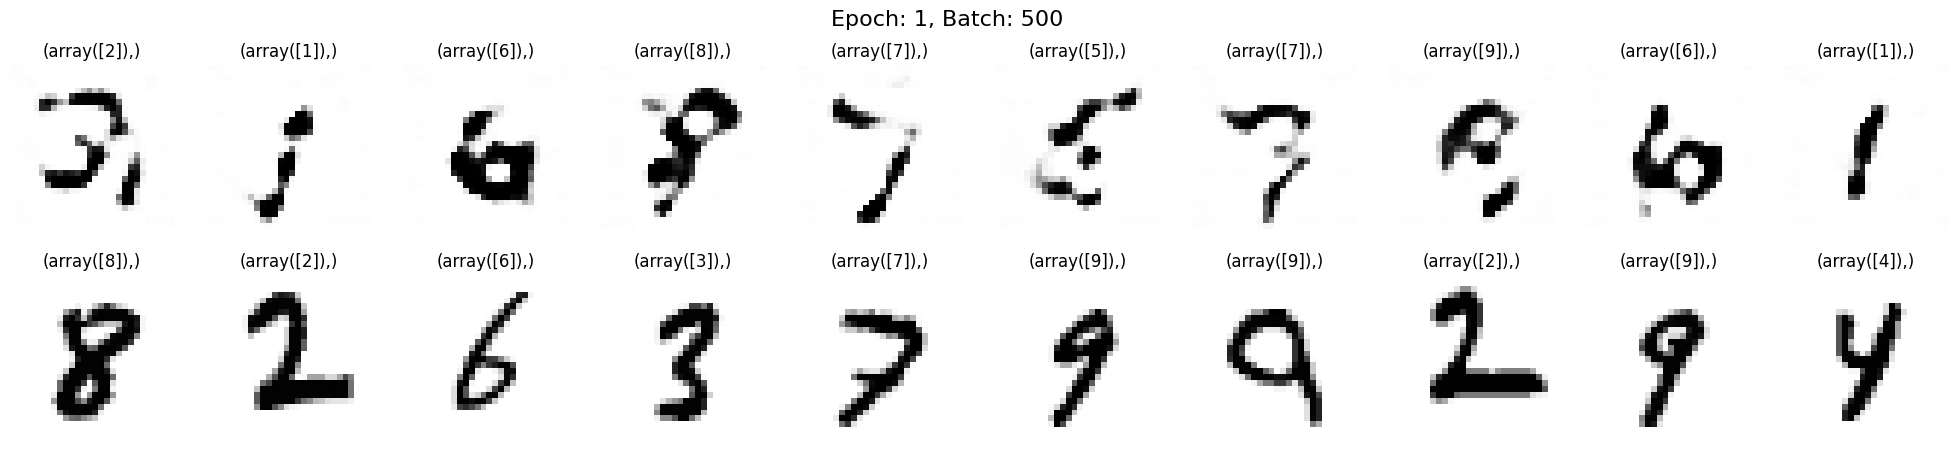

550 [D loss: 0.7394,	 acc.: 59.38%]	[G loss: 0.8017]
600 [D loss: 0.7231,	 acc.: 57.81%]	[G loss: 0.9128]
650 [D loss: 0.7257,	 acc.: 68.75%]	[G loss: 0.7819]
700 [D loss: 0.7307,	 acc.: 57.81%]	[G loss: 0.8287]
750 [D loss: 0.6491,	 acc.: 68.75%]	[G loss: 0.7924]
800 [D loss: 0.7096,	 acc.: 65.62%]	[G loss: 0.8344]
850 [D loss: 0.6590,	 acc.: 73.44%]	[G loss: 0.8743]
900 [D loss: 0.7080,	 acc.: 57.81%]	[G loss: 0.8656]
950 [D loss: 0.7348,	 acc.: 56.25%]	[G loss: 0.8452]
1000 [D loss: 0.7614,	 acc.: 54.69%]	[G loss: 0.9603]


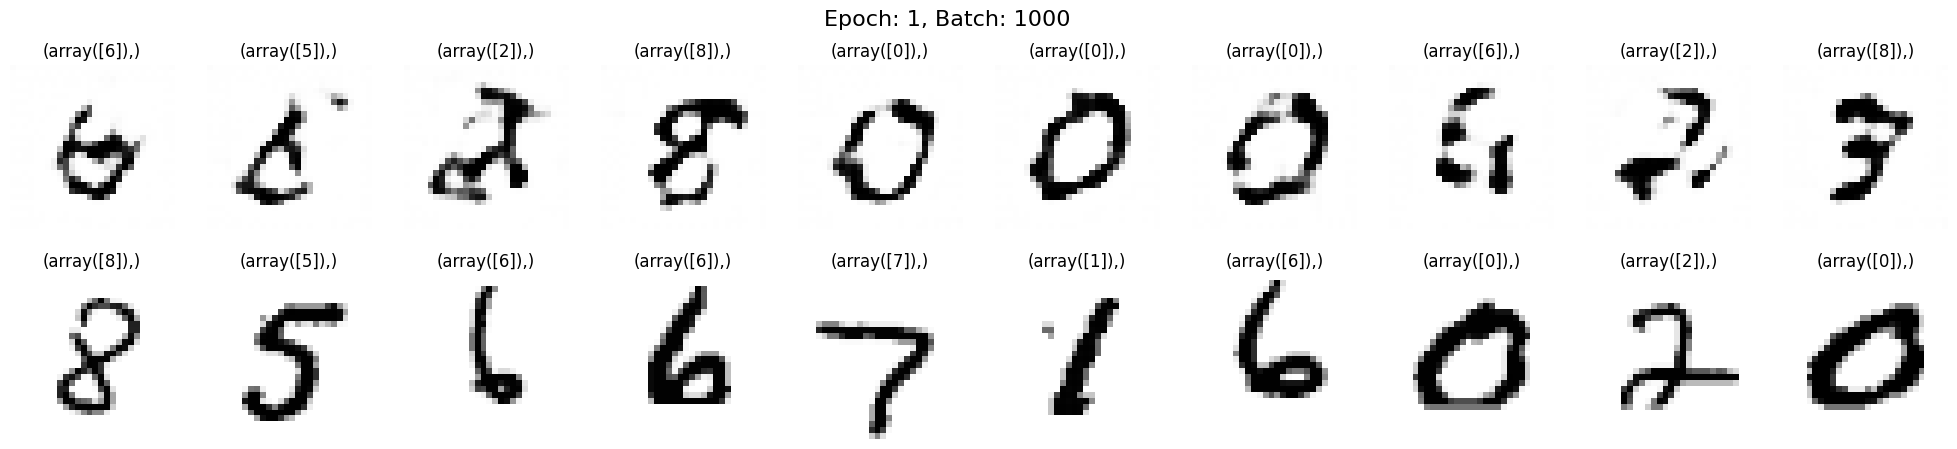

1050 [D loss: 0.5883,	 acc.: 81.25%]	[G loss: 0.9271]
1100 [D loss: 0.7401,	 acc.: 57.81%]	[G loss: 0.8527]
1150 [D loss: 0.6394,	 acc.: 75.00%]	[G loss: 0.9202]
1200 [D loss: 0.7468,	 acc.: 53.12%]	[G loss: 0.8573]
1250 [D loss: 0.6595,	 acc.: 67.19%]	[G loss: 0.9330]
1300 [D loss: 0.6912,	 acc.: 64.06%]	[G loss: 0.9922]
1350 [D loss: 0.6789,	 acc.: 71.88%]	[G loss: 0.8903]
1400 [D loss: 0.7714,	 acc.: 54.69%]	[G loss: 0.9246]
1450 [D loss: 0.7396,	 acc.: 59.38%]	[G loss: 0.9553]
1500 [D loss: 0.6614,	 acc.: 68.75%]	[G loss: 0.7525]


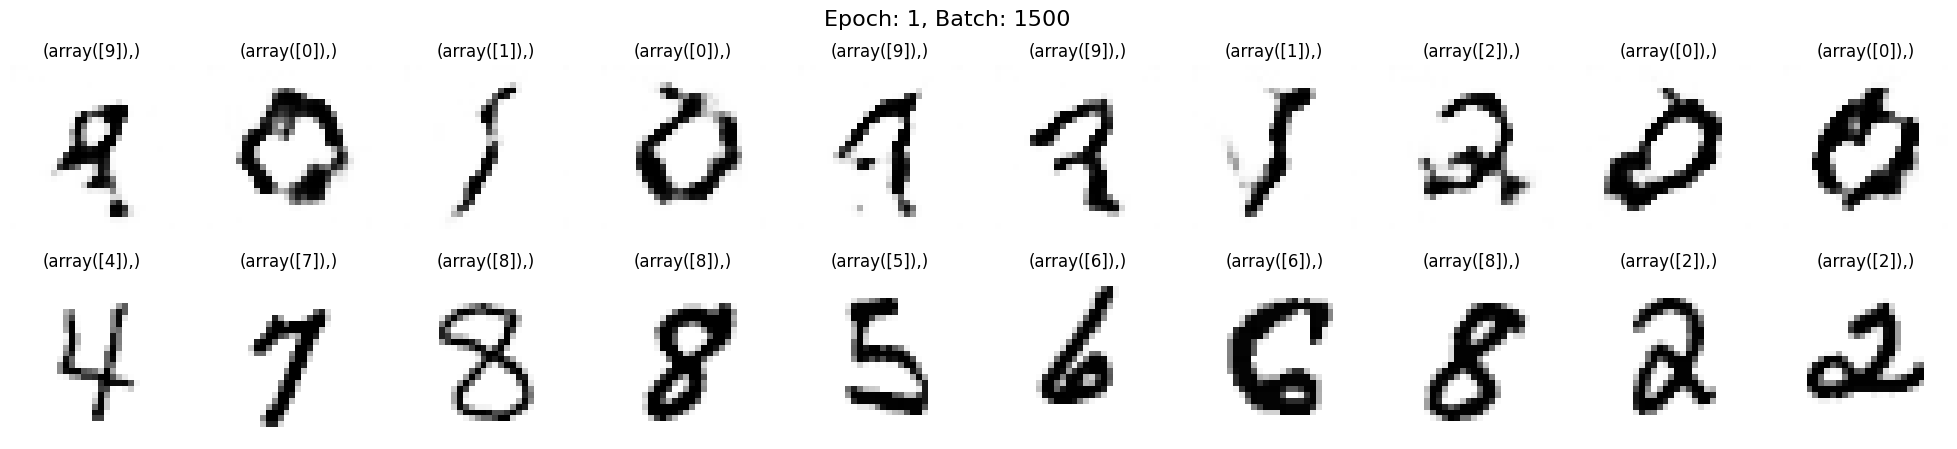

1550 [D loss: 0.6638,	 acc.: 64.06%]	[G loss: 0.9219]
1600 [D loss: 0.6442,	 acc.: 70.31%]	[G loss: 1.1497]
1650 [D loss: 0.6524,	 acc.: 73.44%]	[G loss: 0.9410]
1700 [D loss: 0.6824,	 acc.: 67.19%]	[G loss: 1.0289]
1750 [D loss: 0.6017,	 acc.: 78.12%]	[G loss: 0.9063]
1800 [D loss: 0.7123,	 acc.: 62.50%]	[G loss: 1.0719]
1850 [D loss: 0.5992,	 acc.: 79.69%]	[G loss: 1.0281]


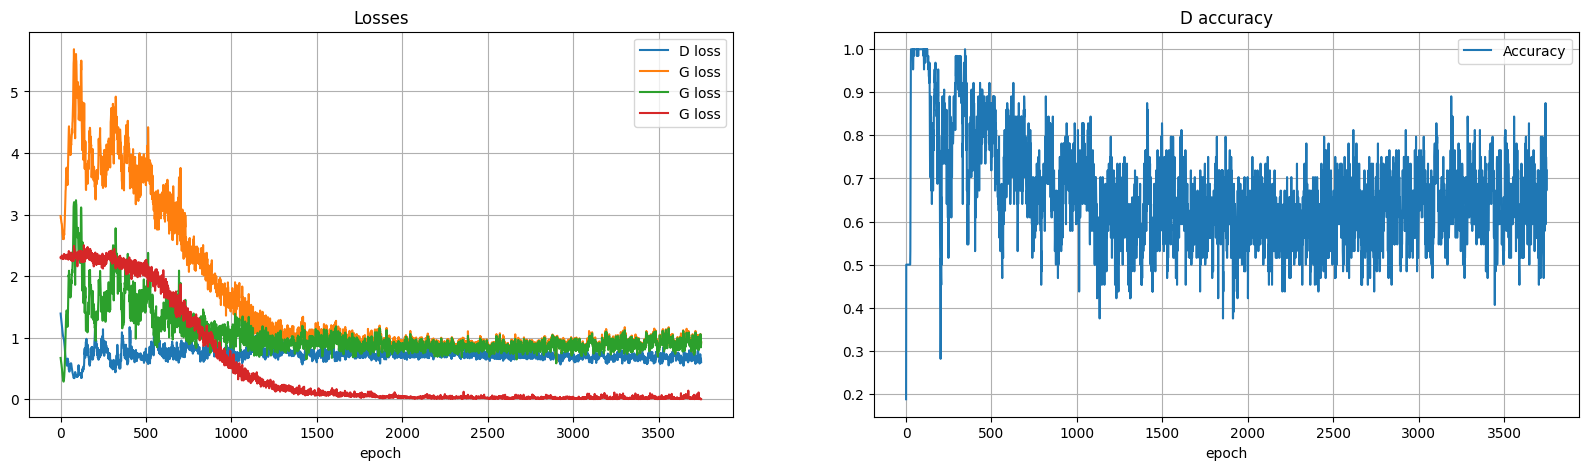

----EPOCH 2-----
0 [D loss: 0.6447,	 acc.: 68.75%]	[G loss: 0.8983]


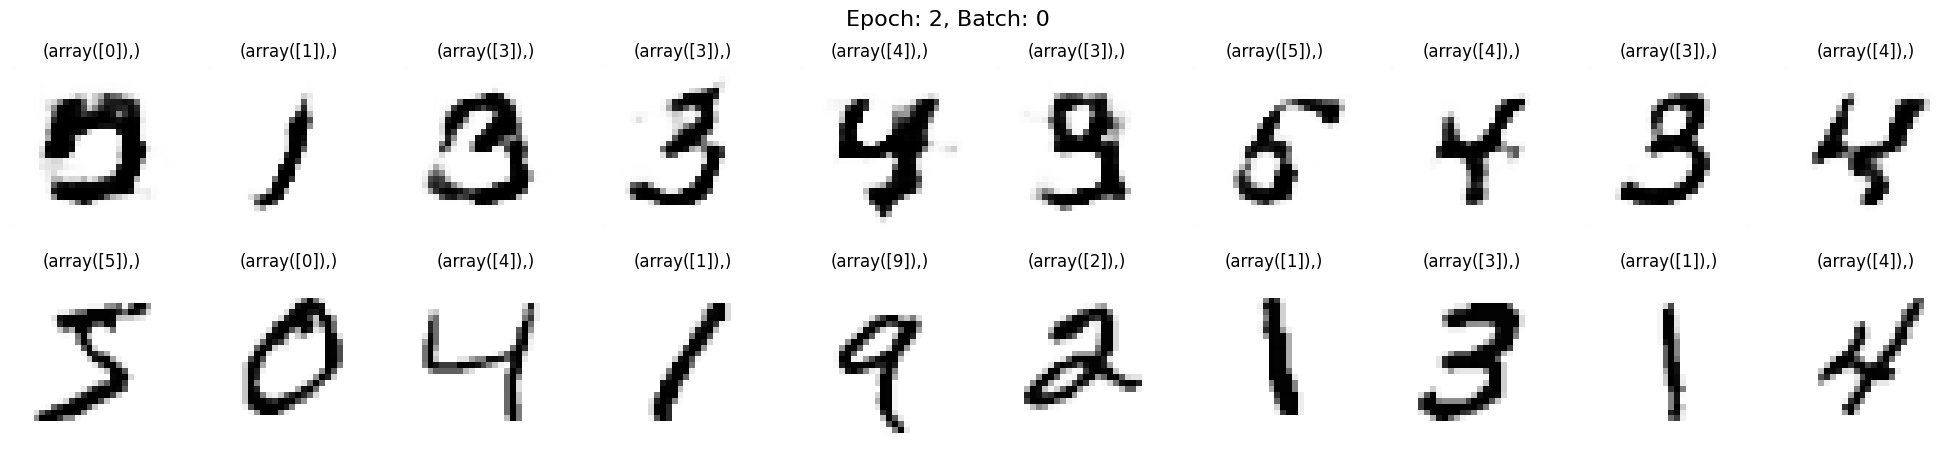

50 [D loss: 0.6992,	 acc.: 71.88%]	[G loss: 1.0781]
100 [D loss: 0.7070,	 acc.: 62.50%]	[G loss: 0.8585]
150 [D loss: 0.5652,	 acc.: 78.12%]	[G loss: 0.9757]
200 [D loss: 0.7056,	 acc.: 67.19%]	[G loss: 0.7133]
250 [D loss: 0.8717,	 acc.: 46.88%]	[G loss: 0.9050]
300 [D loss: 0.6626,	 acc.: 65.62%]	[G loss: 1.0001]
350 [D loss: 0.6370,	 acc.: 75.00%]	[G loss: 0.8042]
400 [D loss: 0.7205,	 acc.: 62.50%]	[G loss: 0.8924]
450 [D loss: 0.6725,	 acc.: 67.19%]	[G loss: 1.0438]
500 [D loss: 0.7701,	 acc.: 57.81%]	[G loss: 0.8167]


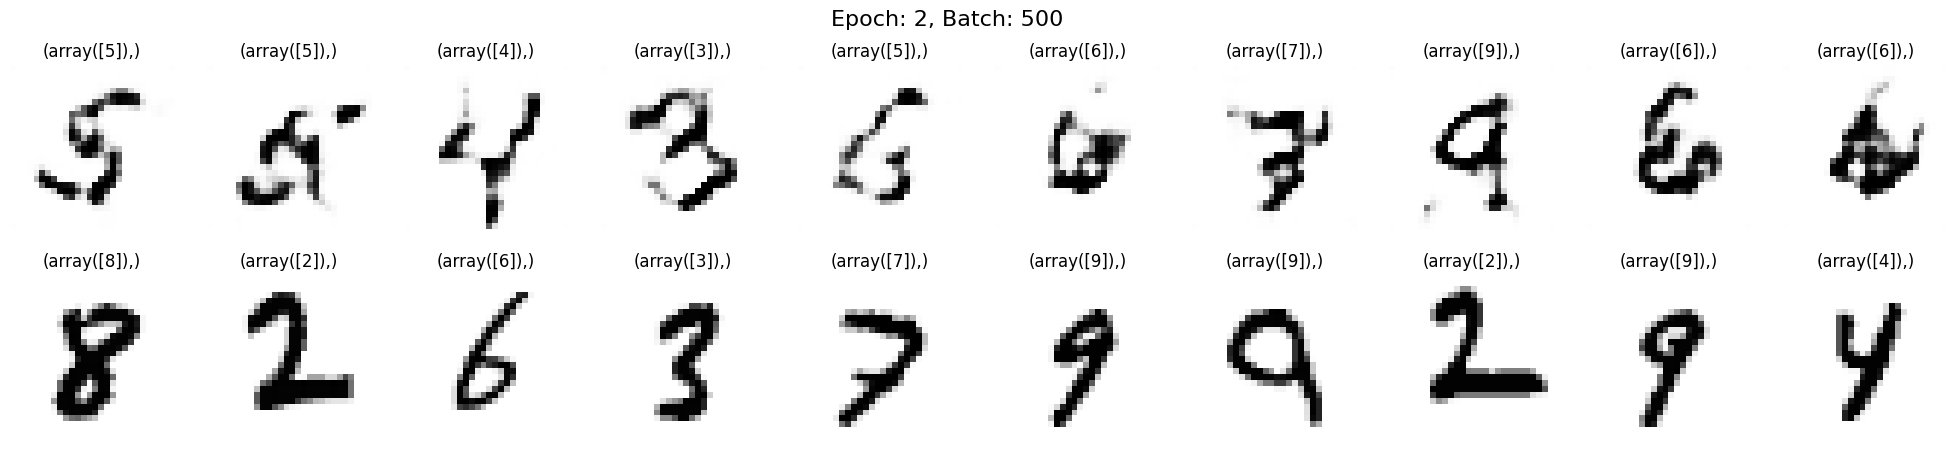

550 [D loss: 0.6709,	 acc.: 67.19%]	[G loss: 0.8291]
600 [D loss: 0.7086,	 acc.: 56.25%]	[G loss: 0.9111]
650 [D loss: 0.6552,	 acc.: 65.62%]	[G loss: 0.9948]
700 [D loss: 0.7326,	 acc.: 50.00%]	[G loss: 0.9257]
750 [D loss: 0.6698,	 acc.: 62.50%]	[G loss: 0.8235]
800 [D loss: 0.6476,	 acc.: 70.31%]	[G loss: 0.8562]
850 [D loss: 0.6393,	 acc.: 73.44%]	[G loss: 0.9745]
900 [D loss: 0.6840,	 acc.: 67.19%]	[G loss: 0.8496]
950 [D loss: 0.7596,	 acc.: 65.62%]	[G loss: 1.0499]
1000 [D loss: 0.6857,	 acc.: 71.88%]	[G loss: 0.9212]


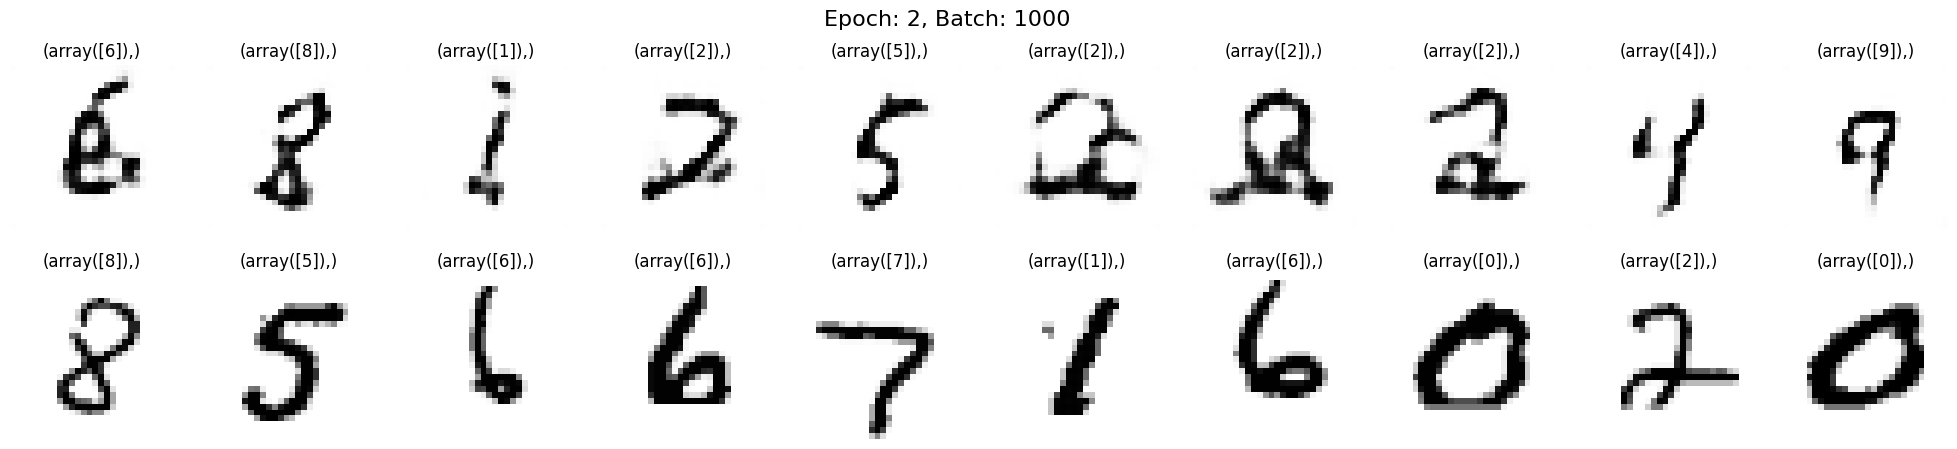

1050 [D loss: 0.6634,	 acc.: 60.94%]	[G loss: 0.8473]
1100 [D loss: 0.6618,	 acc.: 60.94%]	[G loss: 0.8800]
1150 [D loss: 0.6369,	 acc.: 70.31%]	[G loss: 1.1160]
1200 [D loss: 0.5659,	 acc.: 84.38%]	[G loss: 1.0778]
1250 [D loss: 0.6104,	 acc.: 79.69%]	[G loss: 1.0255]
1300 [D loss: 0.6413,	 acc.: 68.75%]	[G loss: 0.8956]
1350 [D loss: 0.7093,	 acc.: 62.50%]	[G loss: 0.8952]
1400 [D loss: 0.7228,	 acc.: 57.81%]	[G loss: 0.9007]
1450 [D loss: 0.7034,	 acc.: 62.50%]	[G loss: 0.8955]
1500 [D loss: 0.6251,	 acc.: 67.19%]	[G loss: 0.8948]


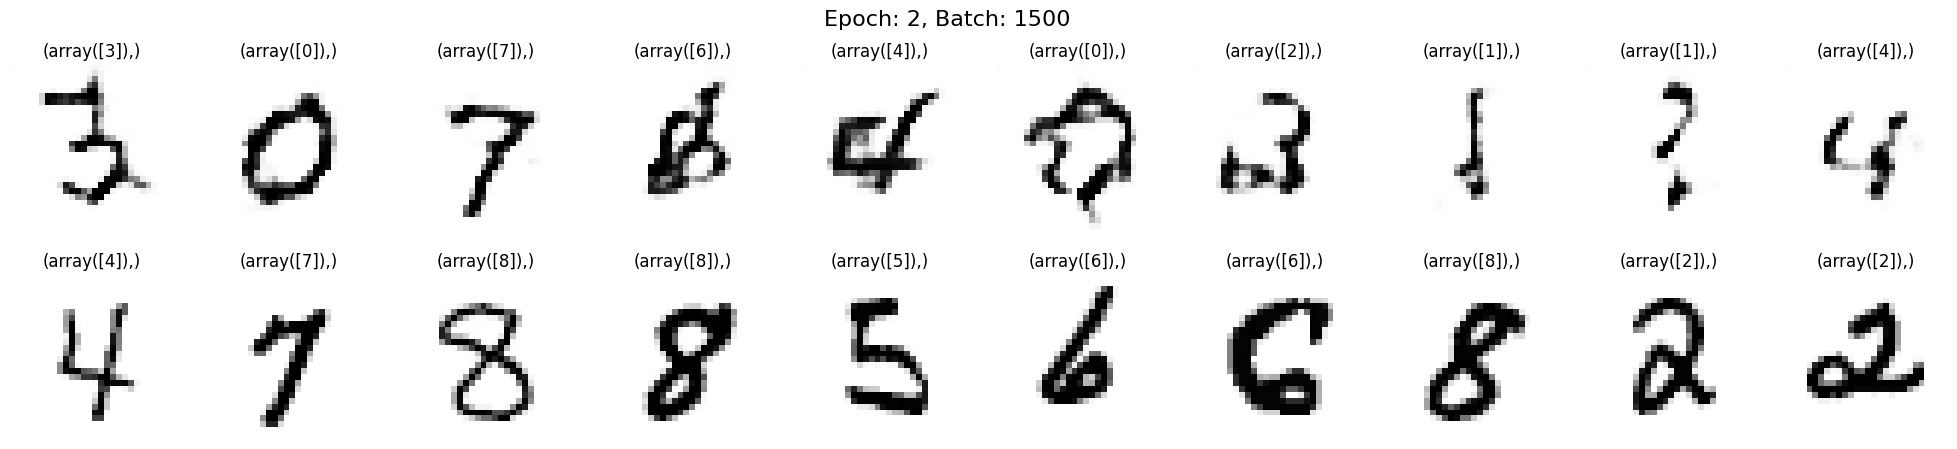

1550 [D loss: 0.6005,	 acc.: 70.31%]	[G loss: 1.0798]
1600 [D loss: 0.6940,	 acc.: 64.06%]	[G loss: 0.9895]
1650 [D loss: 0.7466,	 acc.: 59.38%]	[G loss: 0.7950]
1700 [D loss: 0.6089,	 acc.: 68.75%]	[G loss: 0.8292]
1750 [D loss: 0.7006,	 acc.: 67.19%]	[G loss: 0.8731]
1800 [D loss: 0.6644,	 acc.: 65.62%]	[G loss: 0.8813]
1850 [D loss: 0.7443,	 acc.: 57.81%]	[G loss: 0.9307]


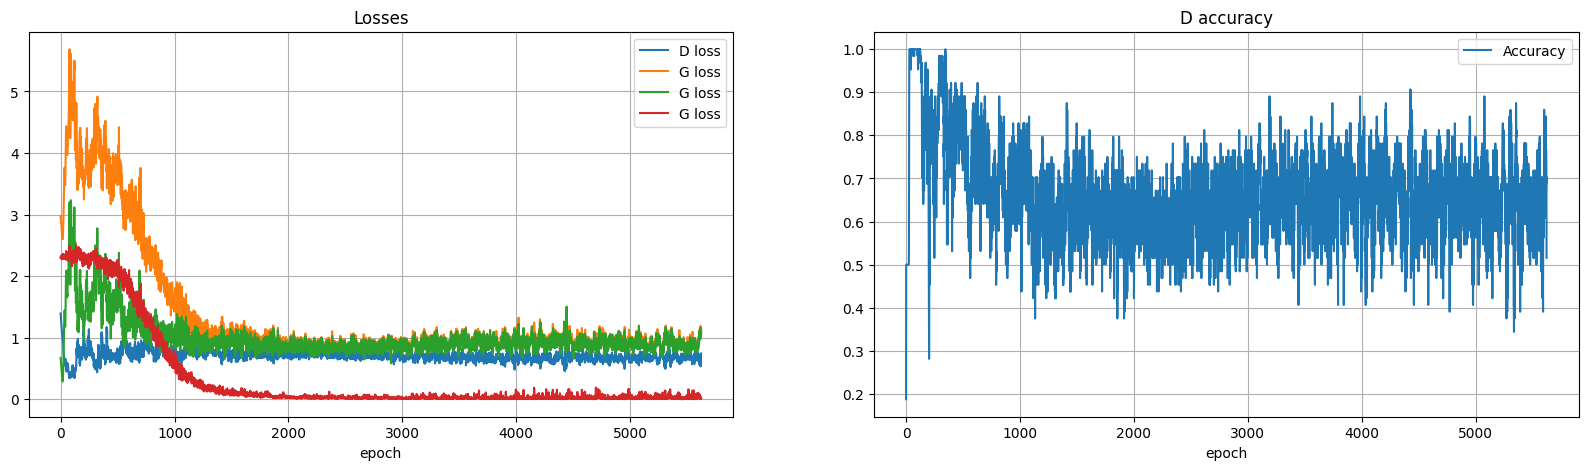

----EPOCH 3-----
0 [D loss: 0.6839,	 acc.: 54.69%]	[G loss: 1.0648]


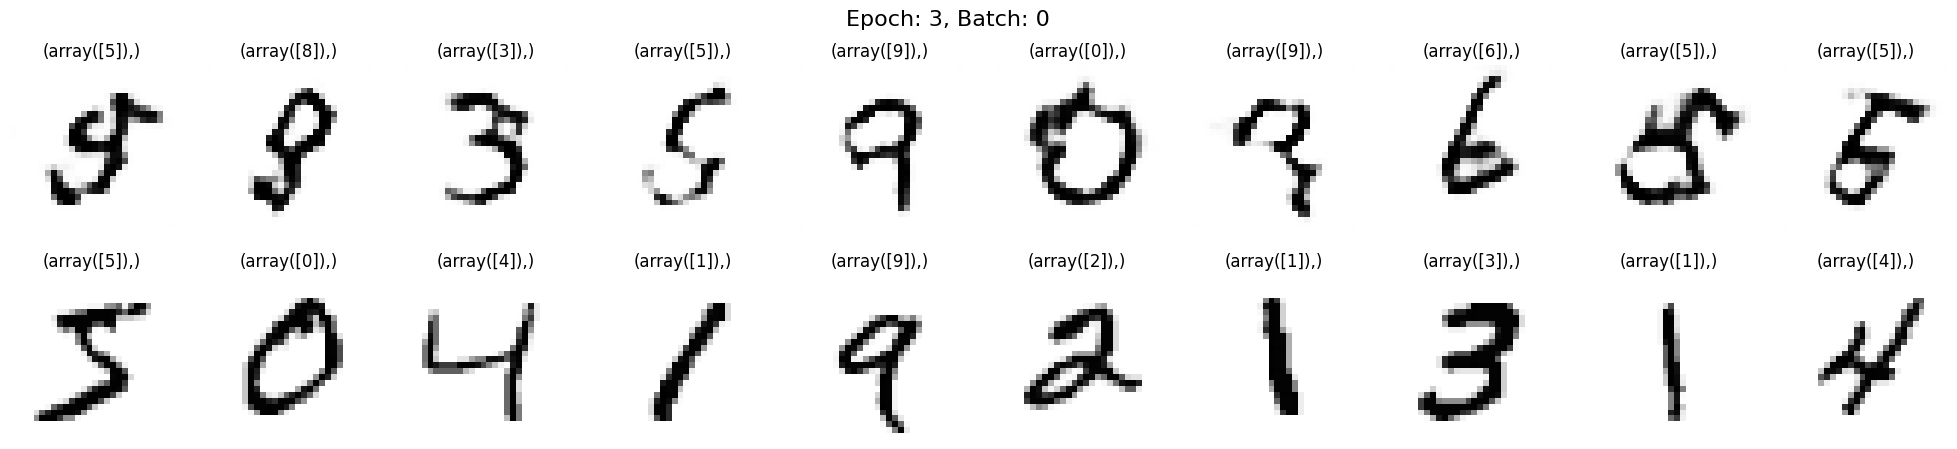

50 [D loss: 0.6988,	 acc.: 57.81%]	[G loss: 0.9164]
100 [D loss: 0.7985,	 acc.: 57.81%]	[G loss: 0.9070]
150 [D loss: 0.6333,	 acc.: 67.19%]	[G loss: 0.9682]
200 [D loss: 0.7587,	 acc.: 59.38%]	[G loss: 0.7980]
250 [D loss: 0.8029,	 acc.: 50.00%]	[G loss: 0.9507]
300 [D loss: 0.6858,	 acc.: 62.50%]	[G loss: 0.9072]
350 [D loss: 0.7320,	 acc.: 59.38%]	[G loss: 0.8398]
400 [D loss: 0.6795,	 acc.: 71.88%]	[G loss: 0.9331]
450 [D loss: 0.6682,	 acc.: 68.75%]	[G loss: 0.9234]
500 [D loss: 0.6163,	 acc.: 71.88%]	[G loss: 0.9405]


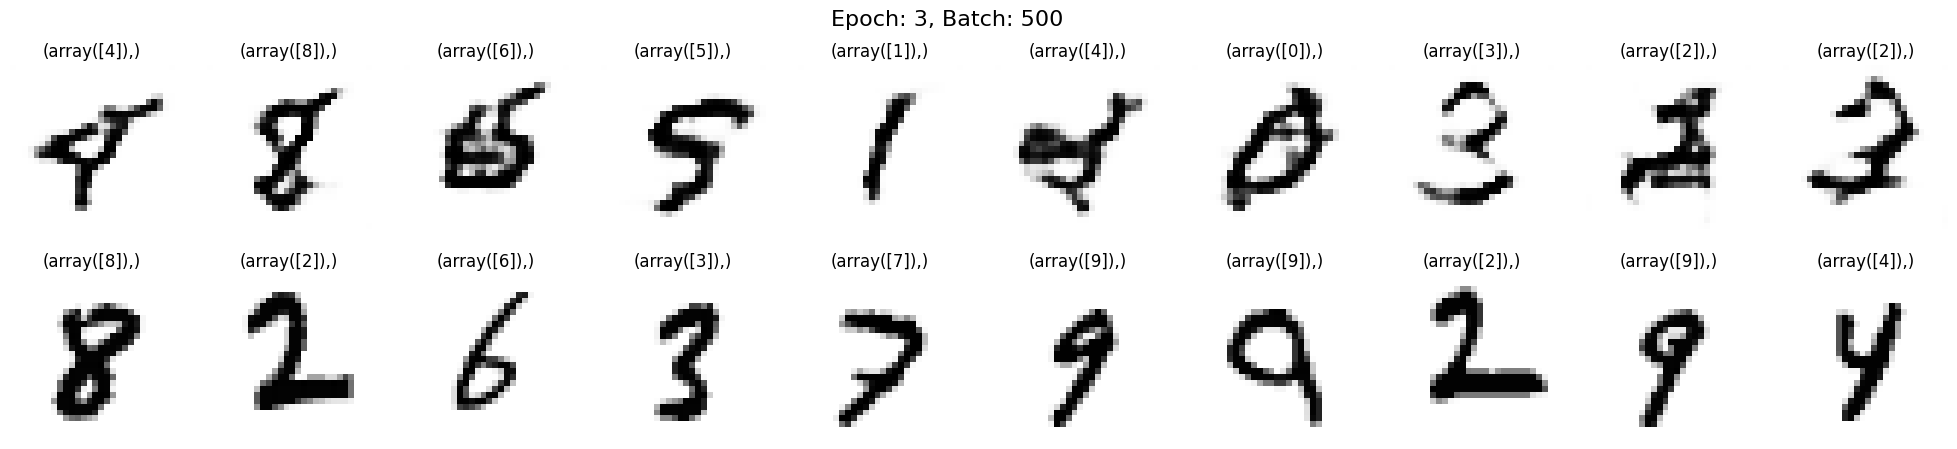

550 [D loss: 0.6413,	 acc.: 65.62%]	[G loss: 0.9002]
600 [D loss: 0.6385,	 acc.: 65.62%]	[G loss: 0.8334]
650 [D loss: 0.6601,	 acc.: 65.62%]	[G loss: 0.8663]
700 [D loss: 0.7099,	 acc.: 59.38%]	[G loss: 0.8346]
750 [D loss: 0.6864,	 acc.: 68.75%]	[G loss: 0.7730]
800 [D loss: 0.6528,	 acc.: 73.44%]	[G loss: 0.9427]
850 [D loss: 0.7152,	 acc.: 54.69%]	[G loss: 0.8840]
900 [D loss: 0.7189,	 acc.: 54.69%]	[G loss: 0.8334]
950 [D loss: 0.7949,	 acc.: 54.69%]	[G loss: 0.8707]
1000 [D loss: 0.6638,	 acc.: 62.50%]	[G loss: 0.9048]


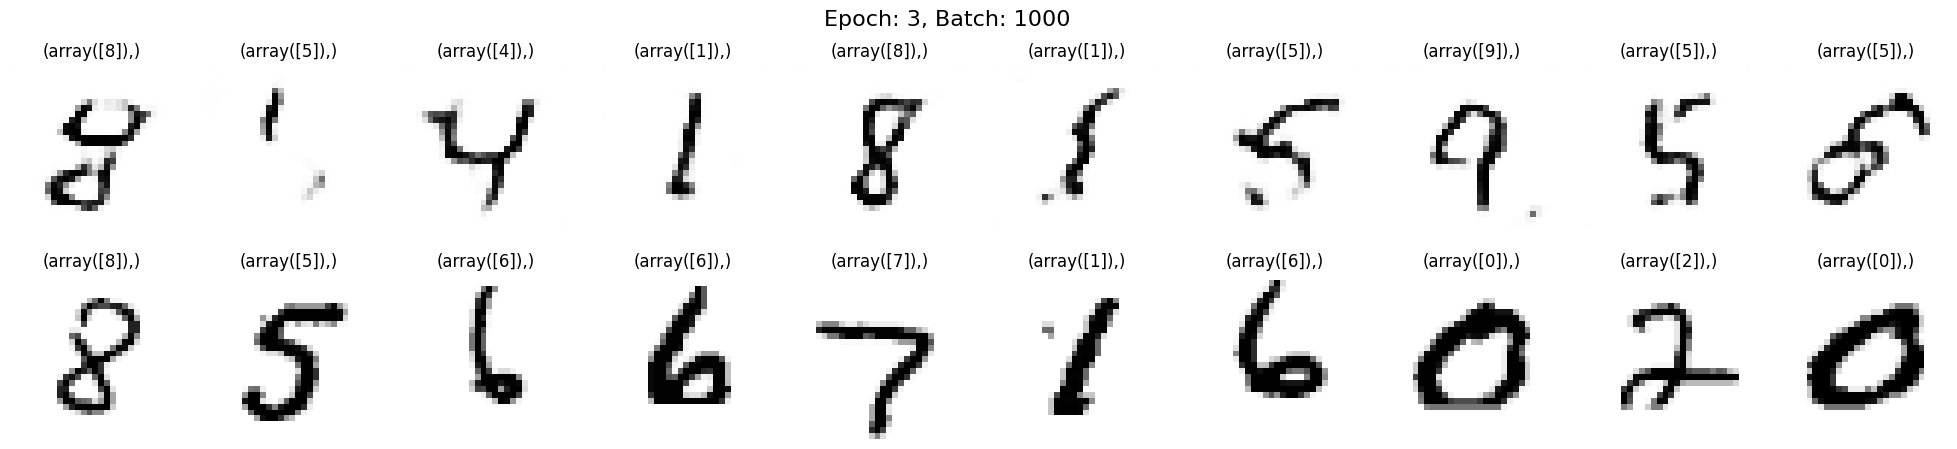

1050 [D loss: 0.7107,	 acc.: 56.25%]	[G loss: 0.8125]
1100 [D loss: 0.6440,	 acc.: 71.88%]	[G loss: 0.9760]
1150 [D loss: 0.6873,	 acc.: 65.62%]	[G loss: 0.9490]
1200 [D loss: 0.7203,	 acc.: 53.12%]	[G loss: 0.7993]
1250 [D loss: 0.6791,	 acc.: 60.94%]	[G loss: 0.9109]
1300 [D loss: 0.6635,	 acc.: 60.94%]	[G loss: 1.0769]
1350 [D loss: 0.7583,	 acc.: 48.44%]	[G loss: 0.8233]
1400 [D loss: 0.6588,	 acc.: 62.50%]	[G loss: 0.8705]
1450 [D loss: 0.6990,	 acc.: 64.06%]	[G loss: 0.8391]
1500 [D loss: 0.7253,	 acc.: 59.38%]	[G loss: 0.8322]


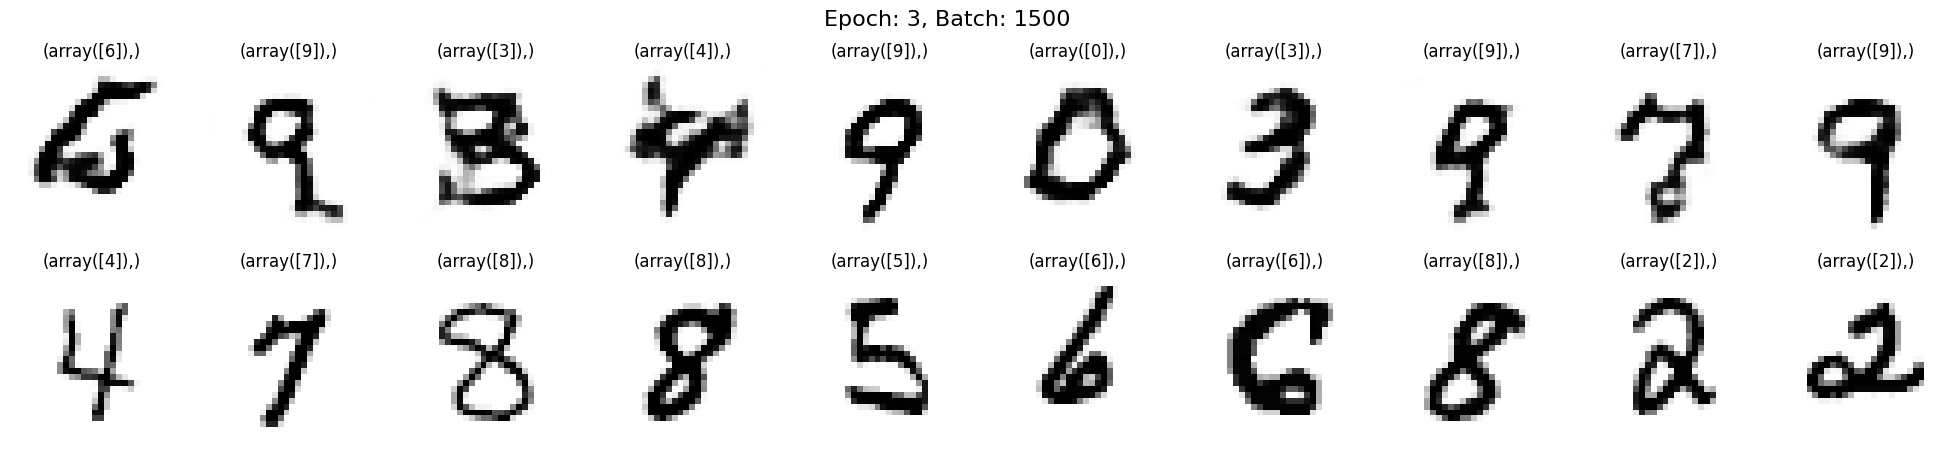

1550 [D loss: 0.6457,	 acc.: 59.38%]	[G loss: 0.9252]
1600 [D loss: 0.7262,	 acc.: 56.25%]	[G loss: 0.9569]
1650 [D loss: 0.6390,	 acc.: 68.75%]	[G loss: 0.9193]
1700 [D loss: 0.6536,	 acc.: 65.62%]	[G loss: 0.8084]
1750 [D loss: 0.6928,	 acc.: 56.25%]	[G loss: 0.7881]
1800 [D loss: 0.6491,	 acc.: 67.19%]	[G loss: 0.8540]
1850 [D loss: 0.6549,	 acc.: 59.38%]	[G loss: 1.0861]


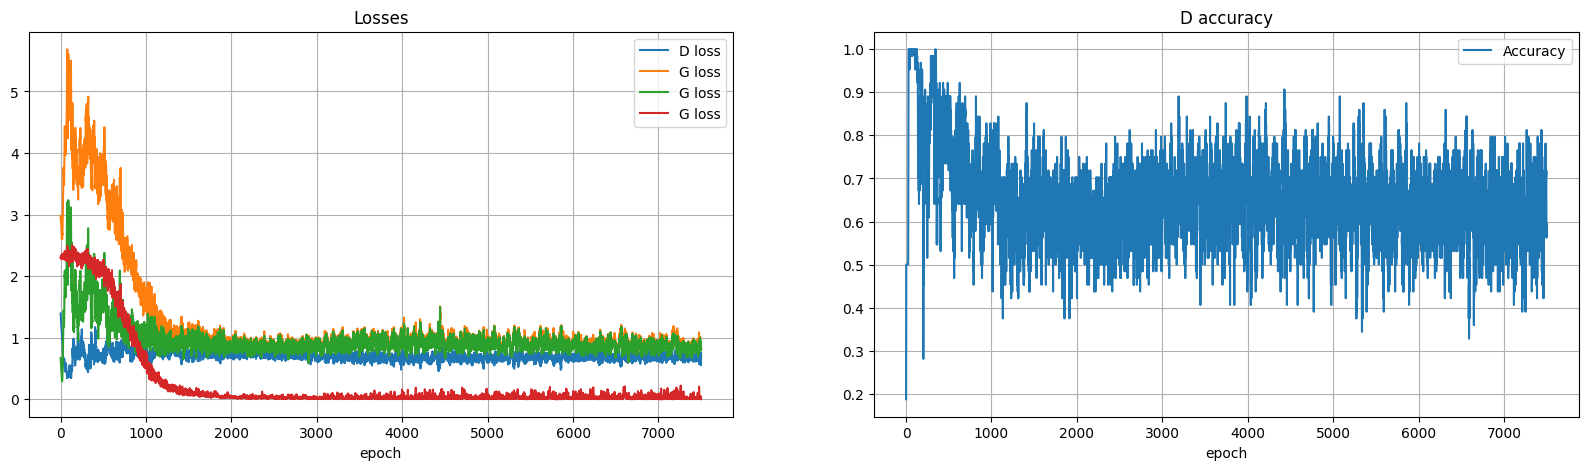

----EPOCH 4-----
0 [D loss: 0.7110,	 acc.: 59.38%]	[G loss: 0.8535]


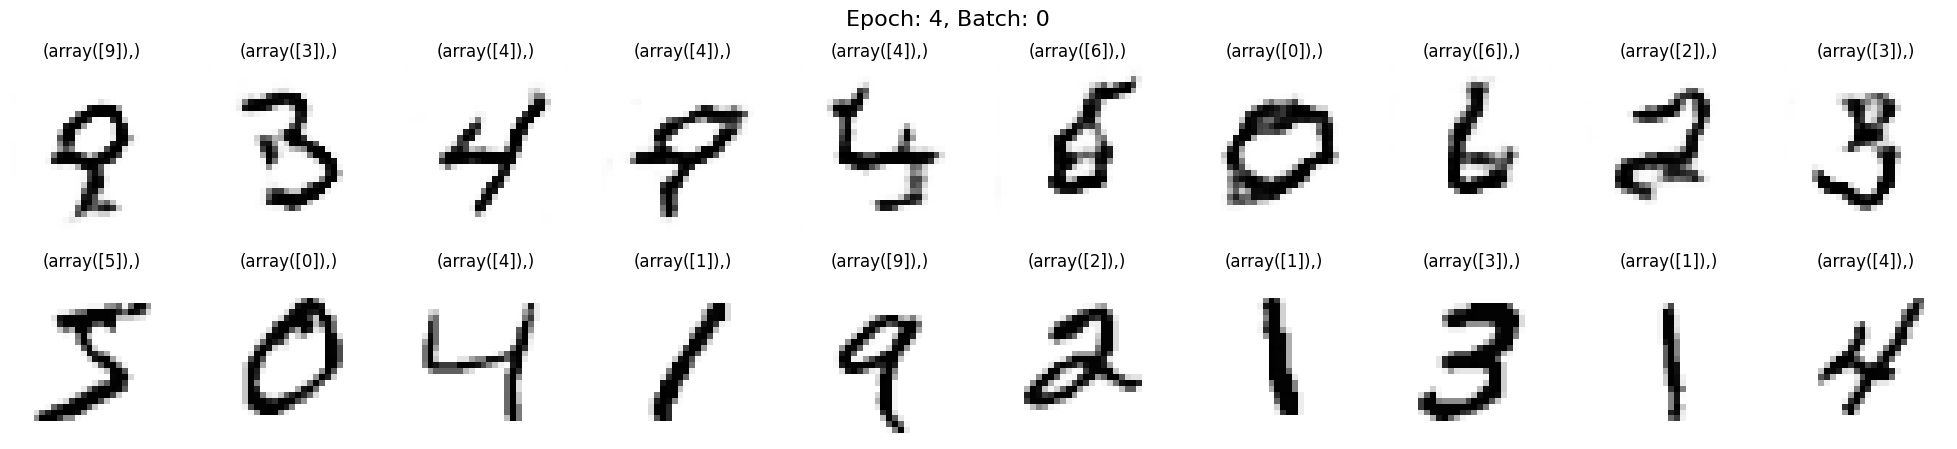

50 [D loss: 0.6954,	 acc.: 64.06%]	[G loss: 0.8793]
100 [D loss: 0.7172,	 acc.: 54.69%]	[G loss: 0.7972]
150 [D loss: 0.6187,	 acc.: 70.31%]	[G loss: 0.8382]
200 [D loss: 0.7227,	 acc.: 54.69%]	[G loss: 0.8766]
250 [D loss: 0.7446,	 acc.: 54.69%]	[G loss: 0.9163]
300 [D loss: 0.6741,	 acc.: 65.62%]	[G loss: 0.8961]
350 [D loss: 0.7457,	 acc.: 51.56%]	[G loss: 0.8098]
400 [D loss: 0.7026,	 acc.: 60.94%]	[G loss: 0.9067]
450 [D loss: 0.7151,	 acc.: 56.25%]	[G loss: 0.8059]
500 [D loss: 0.6807,	 acc.: 62.50%]	[G loss: 0.9080]


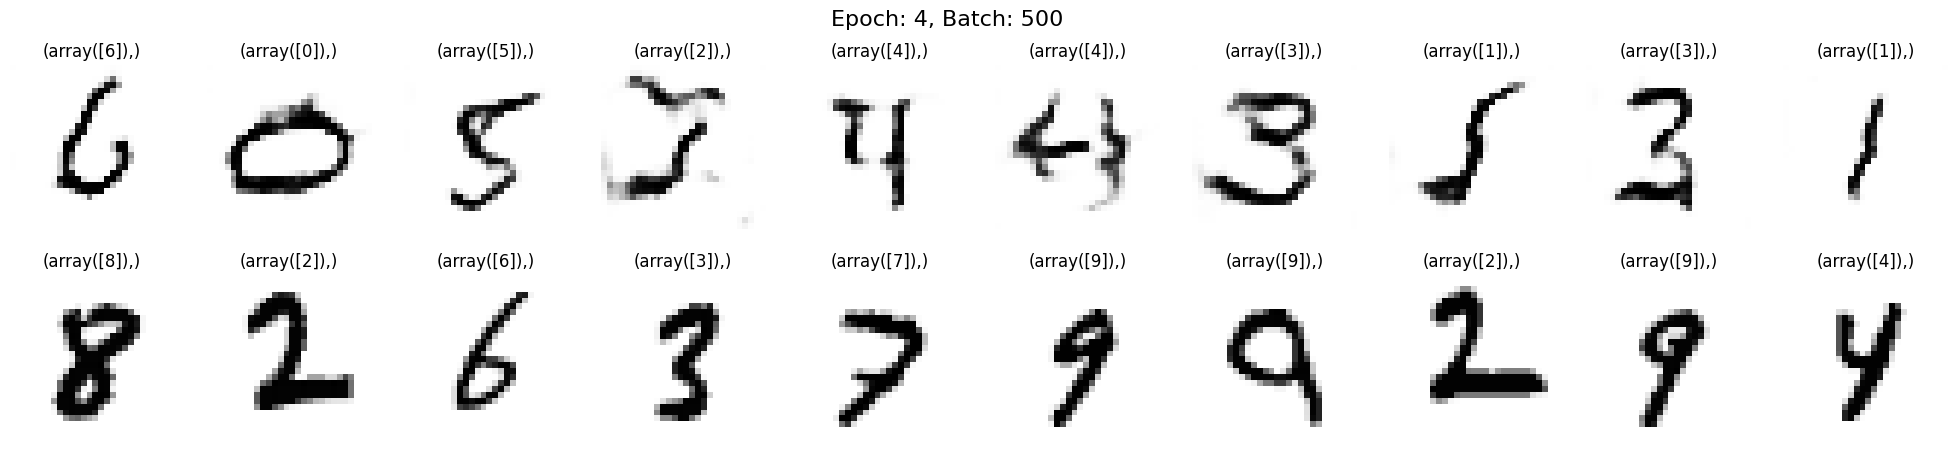

550 [D loss: 0.7182,	 acc.: 59.38%]	[G loss: 0.7967]
600 [D loss: 0.7218,	 acc.: 62.50%]	[G loss: 0.8769]
650 [D loss: 0.7409,	 acc.: 56.25%]	[G loss: 0.7874]
700 [D loss: 0.6888,	 acc.: 57.81%]	[G loss: 0.8227]
750 [D loss: 0.6941,	 acc.: 54.69%]	[G loss: 0.6840]
800 [D loss: 0.6630,	 acc.: 59.38%]	[G loss: 0.7245]
850 [D loss: 0.7011,	 acc.: 60.94%]	[G loss: 0.9041]
900 [D loss: 0.7244,	 acc.: 53.12%]	[G loss: 0.7288]
950 [D loss: 0.7199,	 acc.: 54.69%]	[G loss: 0.8468]
1000 [D loss: 0.8266,	 acc.: 45.31%]	[G loss: 0.7103]


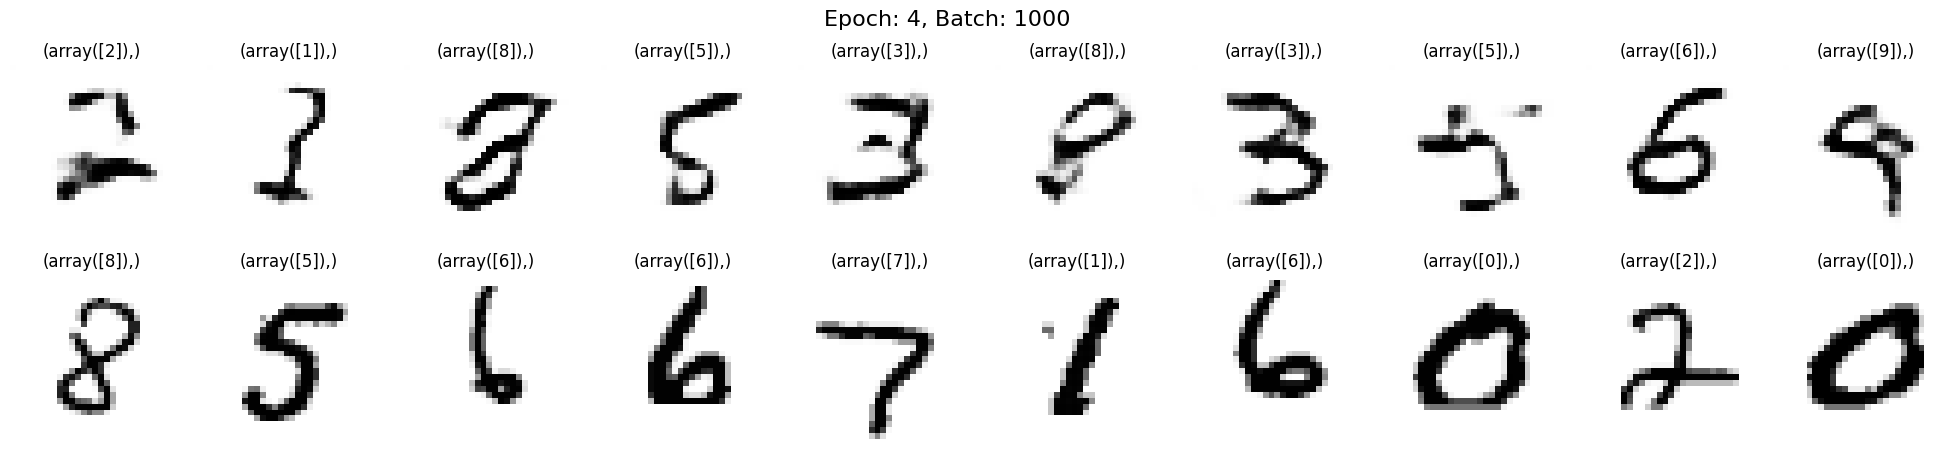

1050 [D loss: 0.7307,	 acc.: 56.25%]	[G loss: 0.8367]
1100 [D loss: 0.7019,	 acc.: 67.19%]	[G loss: 0.8272]
1150 [D loss: 0.7014,	 acc.: 64.06%]	[G loss: 0.8395]
1200 [D loss: 0.7179,	 acc.: 57.81%]	[G loss: 0.8351]
1250 [D loss: 0.7260,	 acc.: 54.69%]	[G loss: 0.8032]
1300 [D loss: 0.6652,	 acc.: 67.19%]	[G loss: 0.8468]
1350 [D loss: 0.7567,	 acc.: 57.81%]	[G loss: 0.8511]
1400 [D loss: 0.7060,	 acc.: 53.12%]	[G loss: 0.8037]
1450 [D loss: 0.7134,	 acc.: 54.69%]	[G loss: 0.8113]
1500 [D loss: 0.7076,	 acc.: 51.56%]	[G loss: 0.9000]


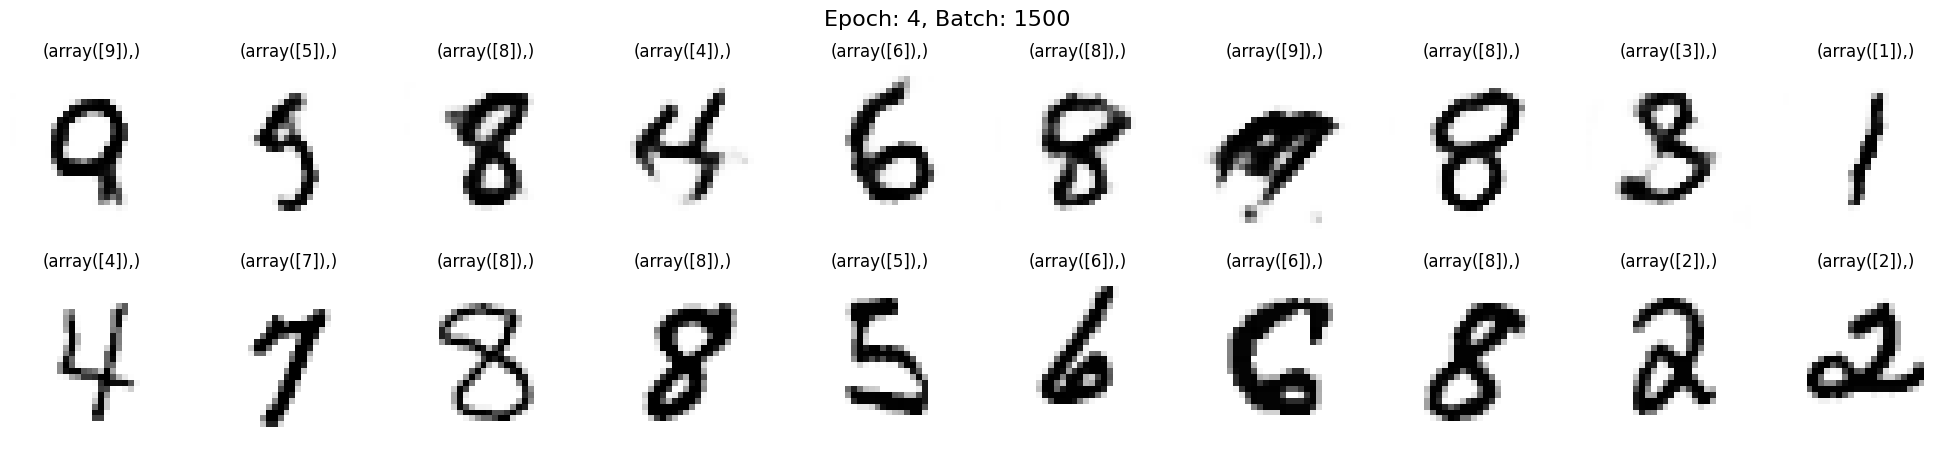

1550 [D loss: 0.6595,	 acc.: 60.94%]	[G loss: 0.8312]
1600 [D loss: 0.7819,	 acc.: 45.31%]	[G loss: 0.8535]
1650 [D loss: 0.6409,	 acc.: 70.31%]	[G loss: 0.8438]
1700 [D loss: 0.6924,	 acc.: 59.38%]	[G loss: 0.7462]
1750 [D loss: 0.6981,	 acc.: 59.38%]	[G loss: 0.6960]
1800 [D loss: 0.7136,	 acc.: 53.12%]	[G loss: 0.8042]
1850 [D loss: 0.6404,	 acc.: 64.06%]	[G loss: 0.8112]


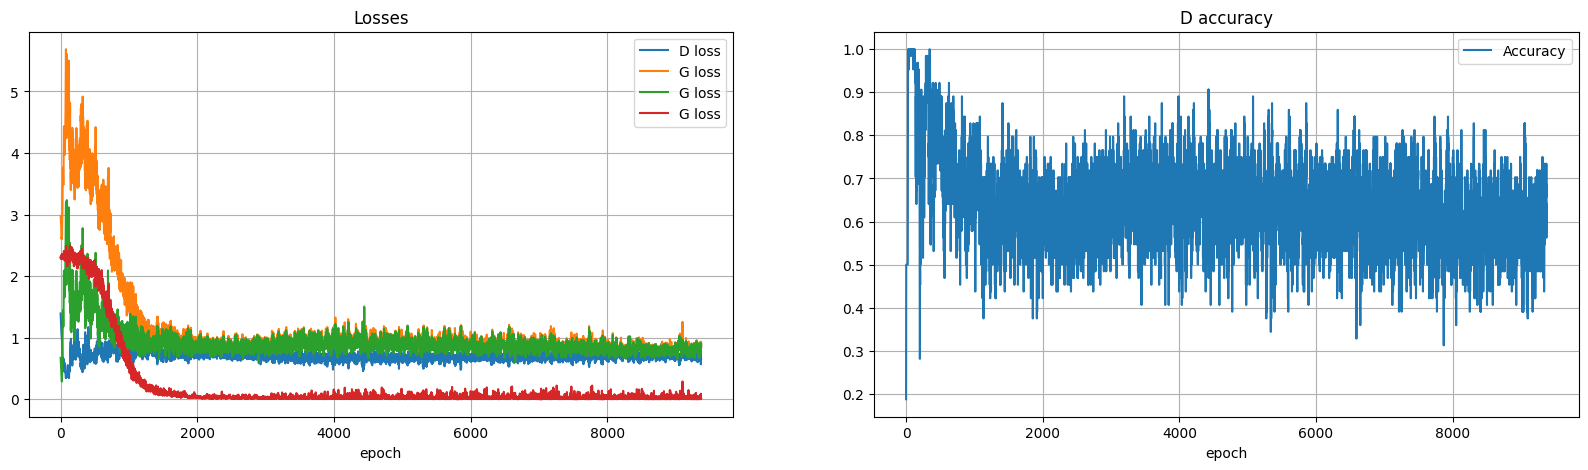

----EPOCH 5-----
0 [D loss: 0.6497,	 acc.: 67.19%]	[G loss: 0.9480]


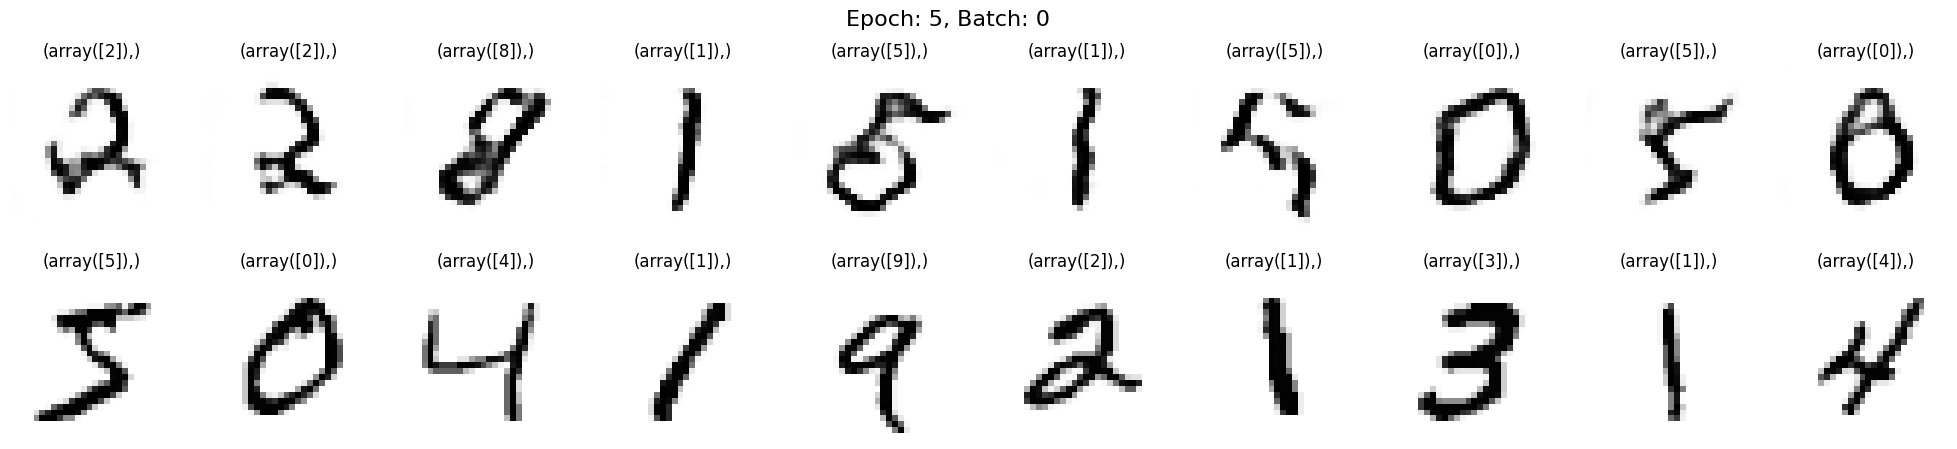

50 [D loss: 0.7285,	 acc.: 51.56%]	[G loss: 0.8743]
100 [D loss: 0.7300,	 acc.: 56.25%]	[G loss: 0.8106]
150 [D loss: 0.6660,	 acc.: 60.94%]	[G loss: 0.8297]
200 [D loss: 0.7377,	 acc.: 54.69%]	[G loss: 0.7435]
250 [D loss: 0.6615,	 acc.: 67.19%]	[G loss: 0.7894]
300 [D loss: 0.7022,	 acc.: 59.38%]	[G loss: 0.7311]
350 [D loss: 0.6881,	 acc.: 62.50%]	[G loss: 0.8089]
400 [D loss: 0.7880,	 acc.: 37.50%]	[G loss: 0.7664]
450 [D loss: 0.6804,	 acc.: 62.50%]	[G loss: 0.8097]
500 [D loss: 0.7872,	 acc.: 42.19%]	[G loss: 0.7102]


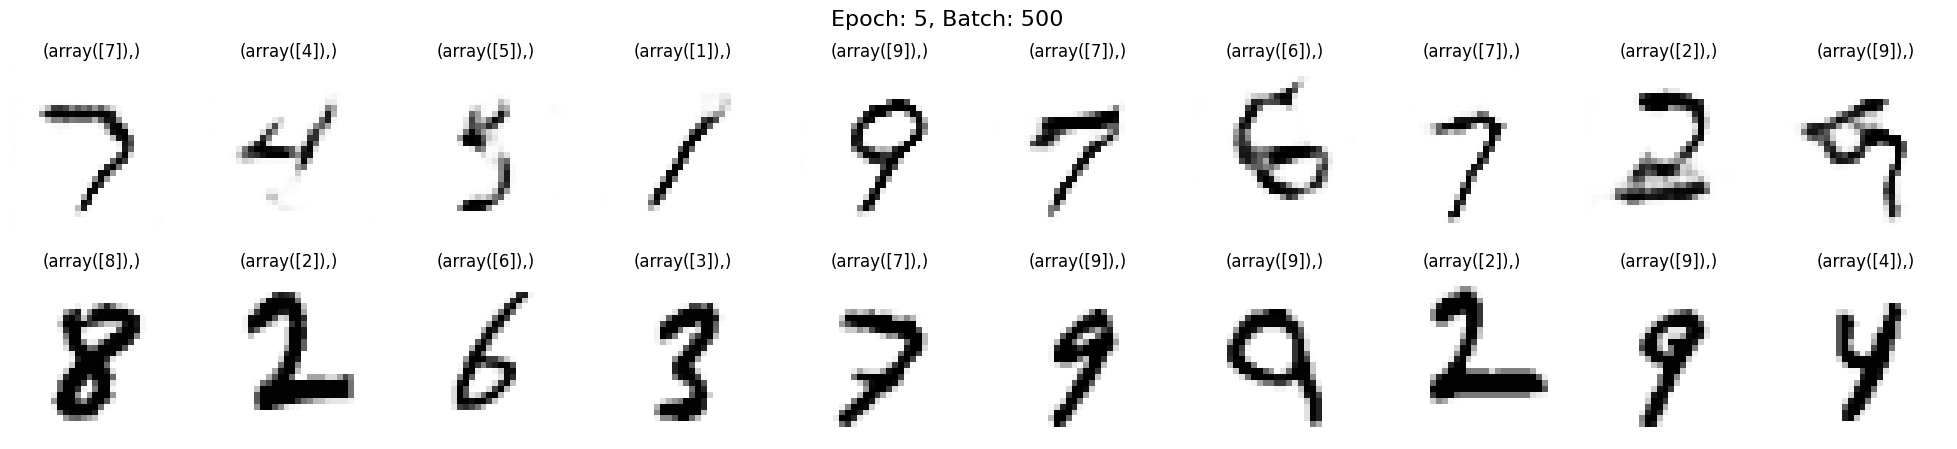

550 [D loss: 0.7629,	 acc.: 50.00%]	[G loss: 0.7715]
600 [D loss: 0.7345,	 acc.: 56.25%]	[G loss: 0.8564]
650 [D loss: 0.6817,	 acc.: 64.06%]	[G loss: 0.7173]
700 [D loss: 0.6611,	 acc.: 62.50%]	[G loss: 0.8219]
750 [D loss: 0.6869,	 acc.: 65.62%]	[G loss: 0.8720]
800 [D loss: 0.6731,	 acc.: 59.38%]	[G loss: 0.8653]
850 [D loss: 0.7137,	 acc.: 50.00%]	[G loss: 0.7412]
900 [D loss: 0.6734,	 acc.: 56.25%]	[G loss: 0.9411]
950 [D loss: 0.6934,	 acc.: 57.81%]	[G loss: 0.8656]
1000 [D loss: 0.7655,	 acc.: 51.56%]	[G loss: 0.7719]


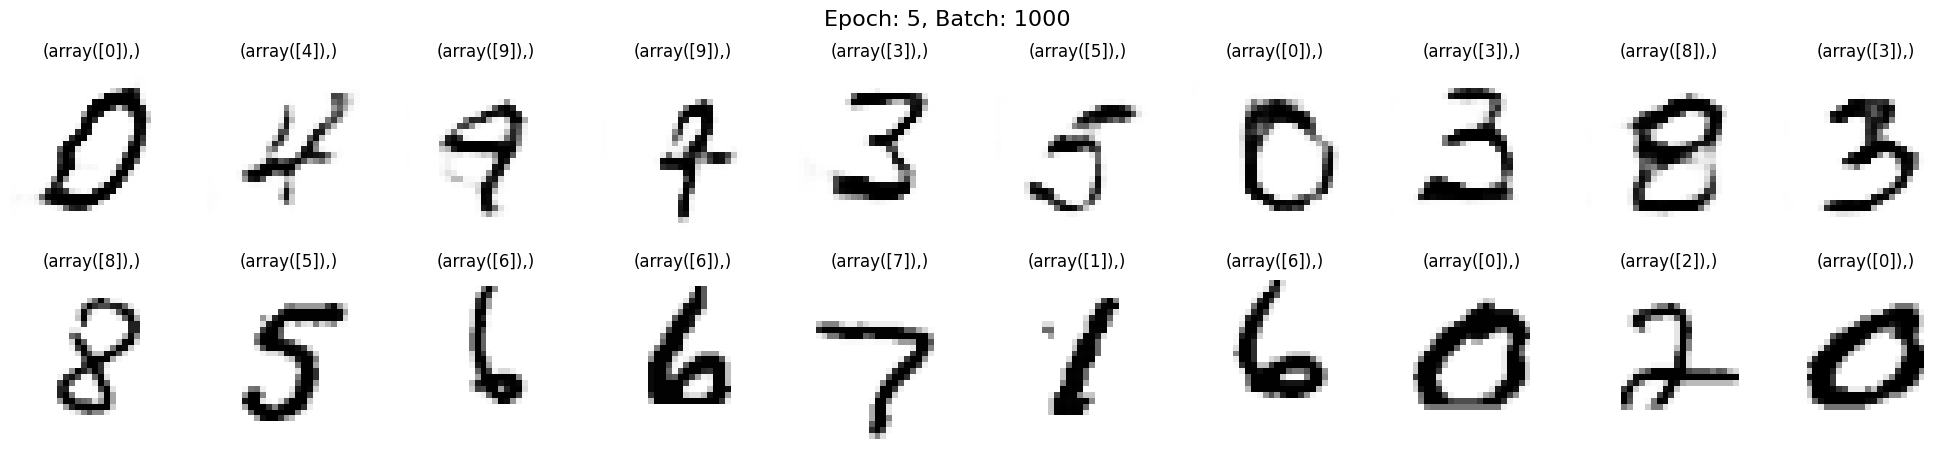

1050 [D loss: 0.7611,	 acc.: 51.56%]	[G loss: 0.7116]
1100 [D loss: 0.6465,	 acc.: 75.00%]	[G loss: 0.8108]
1150 [D loss: 0.6699,	 acc.: 64.06%]	[G loss: 0.7370]
1200 [D loss: 0.6763,	 acc.: 67.19%]	[G loss: 0.8427]
1250 [D loss: 0.7236,	 acc.: 54.69%]	[G loss: 0.8524]
1300 [D loss: 0.6555,	 acc.: 75.00%]	[G loss: 0.8790]
1350 [D loss: 0.7235,	 acc.: 53.12%]	[G loss: 0.7806]
1400 [D loss: 0.6929,	 acc.: 62.50%]	[G loss: 0.7258]
1450 [D loss: 0.7803,	 acc.: 46.88%]	[G loss: 0.8695]
1500 [D loss: 0.7022,	 acc.: 53.12%]	[G loss: 0.8005]


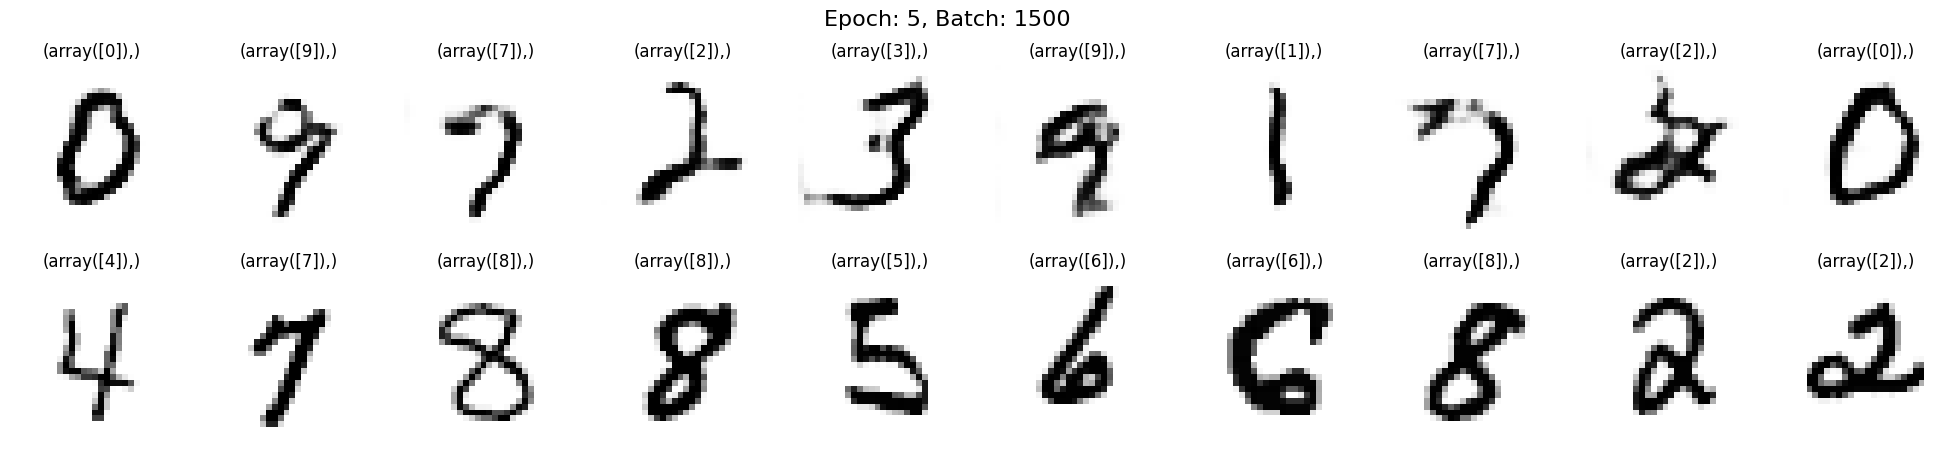

1550 [D loss: 0.7107,	 acc.: 50.00%]	[G loss: 0.7509]
1600 [D loss: 0.7750,	 acc.: 46.88%]	[G loss: 0.7624]
1650 [D loss: 0.7544,	 acc.: 45.31%]	[G loss: 0.7327]
1700 [D loss: 0.7061,	 acc.: 56.25%]	[G loss: 0.9022]
1750 [D loss: 0.7015,	 acc.: 54.69%]	[G loss: 0.7590]
1800 [D loss: 0.7227,	 acc.: 53.12%]	[G loss: 0.7561]
1850 [D loss: 0.6902,	 acc.: 60.94%]	[G loss: 0.7987]


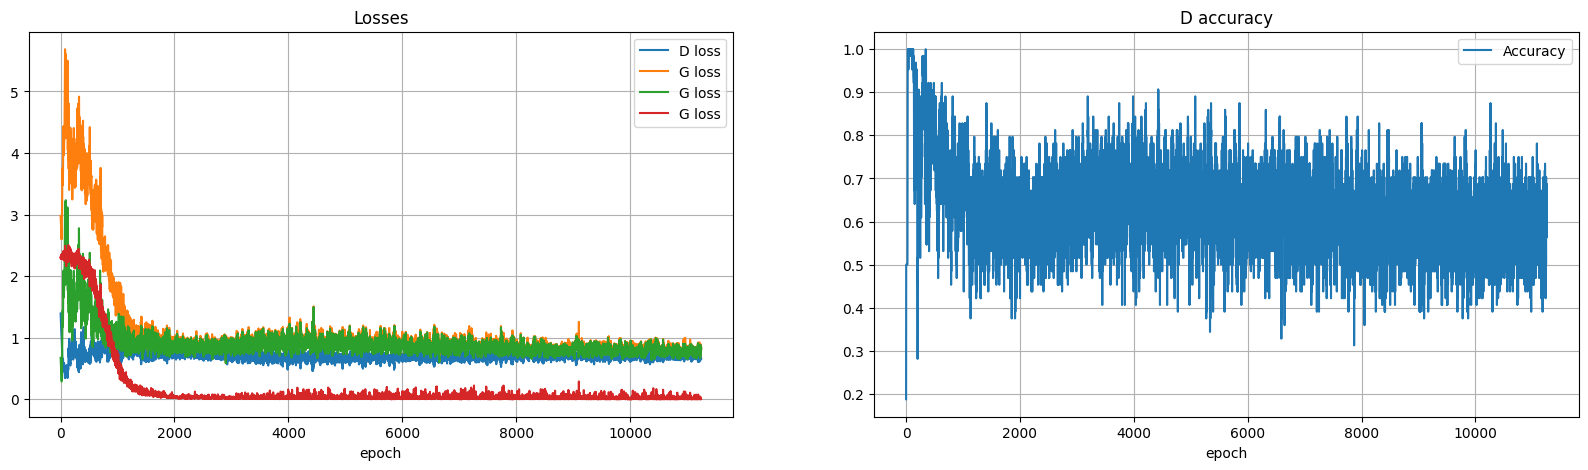

----EPOCH 6-----
0 [D loss: 0.7180,	 acc.: 43.75%]	[G loss: 0.8259]


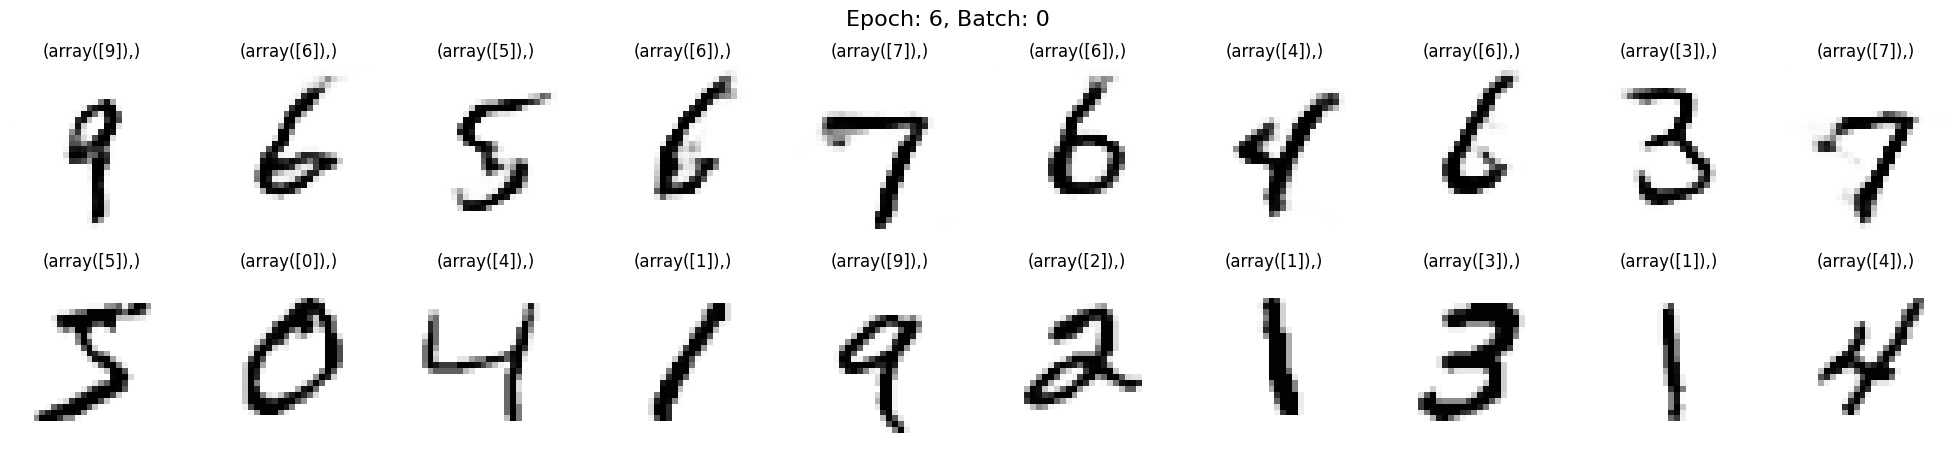

50 [D loss: 0.7128,	 acc.: 60.94%]	[G loss: 0.8337]
100 [D loss: 0.7287,	 acc.: 57.81%]	[G loss: 0.7888]
150 [D loss: 0.6524,	 acc.: 65.62%]	[G loss: 0.8101]
200 [D loss: 0.7250,	 acc.: 50.00%]	[G loss: 0.6733]
250 [D loss: 0.7324,	 acc.: 43.75%]	[G loss: 0.7435]
300 [D loss: 0.6770,	 acc.: 60.94%]	[G loss: 0.8501]
350 [D loss: 0.6556,	 acc.: 65.62%]	[G loss: 0.8677]
400 [D loss: 0.6805,	 acc.: 62.50%]	[G loss: 0.7556]
450 [D loss: 0.7180,	 acc.: 56.25%]	[G loss: 0.7549]
500 [D loss: 0.7285,	 acc.: 57.81%]	[G loss: 0.7308]


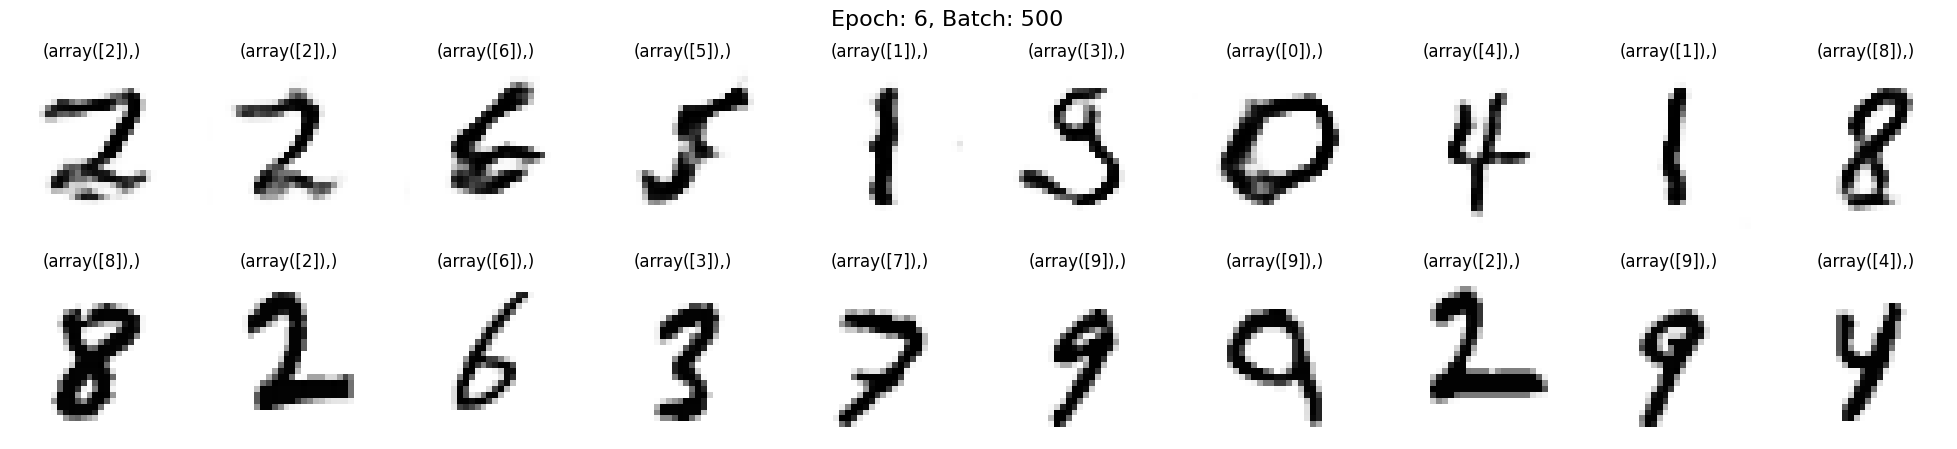

550 [D loss: 0.6805,	 acc.: 57.81%]	[G loss: 0.7371]
600 [D loss: 0.6666,	 acc.: 57.81%]	[G loss: 0.8482]
650 [D loss: 0.7253,	 acc.: 50.00%]	[G loss: 0.7559]
700 [D loss: 0.7002,	 acc.: 53.12%]	[G loss: 0.7980]
750 [D loss: 0.6917,	 acc.: 50.00%]	[G loss: 0.7804]
800 [D loss: 0.6910,	 acc.: 64.06%]	[G loss: 0.7519]
850 [D loss: 0.6885,	 acc.: 59.38%]	[G loss: 0.7358]
900 [D loss: 0.6709,	 acc.: 59.38%]	[G loss: 0.8478]
950 [D loss: 0.7641,	 acc.: 51.56%]	[G loss: 0.8461]
1000 [D loss: 0.7892,	 acc.: 48.44%]	[G loss: 0.7758]


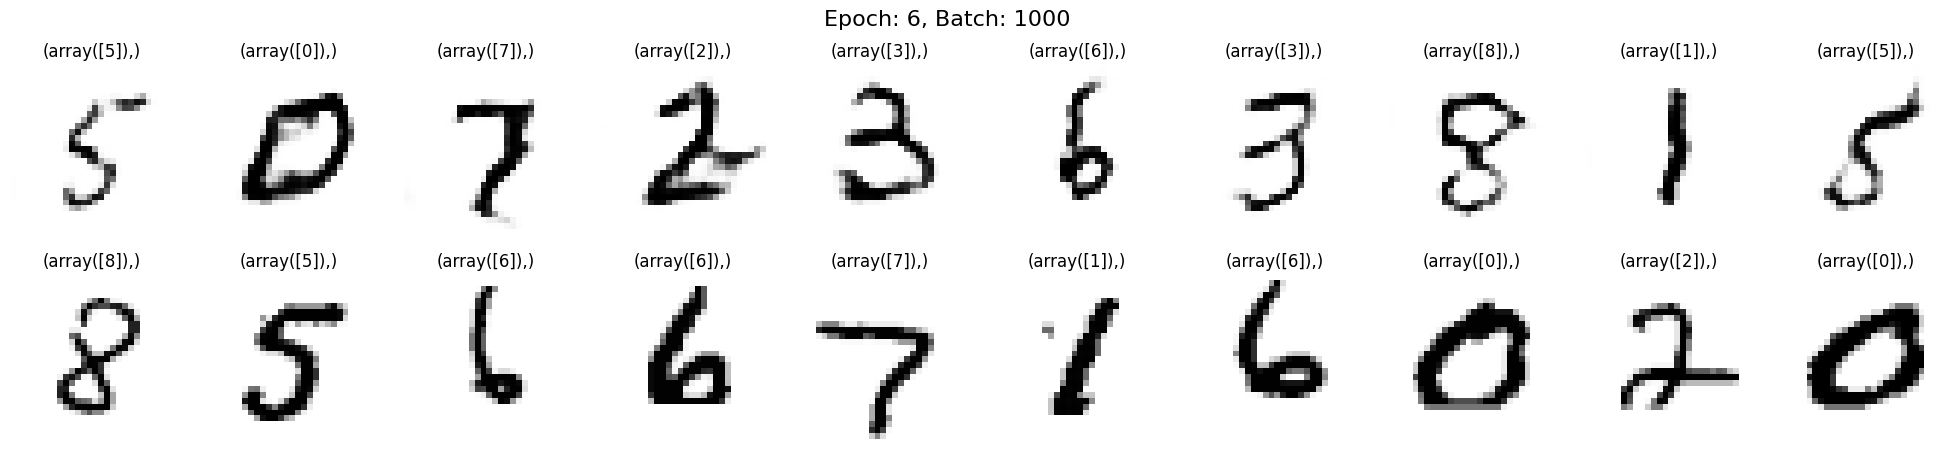

1050 [D loss: 0.7421,	 acc.: 51.56%]	[G loss: 0.7720]
1100 [D loss: 0.6716,	 acc.: 59.38%]	[G loss: 0.8764]
1150 [D loss: 0.6705,	 acc.: 70.31%]	[G loss: 0.7768]
1200 [D loss: 0.6898,	 acc.: 56.25%]	[G loss: 0.7640]
1250 [D loss: 0.7536,	 acc.: 51.56%]	[G loss: 0.7851]
1300 [D loss: 0.6902,	 acc.: 60.94%]	[G loss: 0.7953]
1350 [D loss: 0.7287,	 acc.: 54.69%]	[G loss: 0.7327]
1400 [D loss: 0.7070,	 acc.: 60.94%]	[G loss: 0.7318]
1450 [D loss: 0.6680,	 acc.: 68.75%]	[G loss: 0.8531]
1500 [D loss: 0.7014,	 acc.: 57.81%]	[G loss: 0.7102]


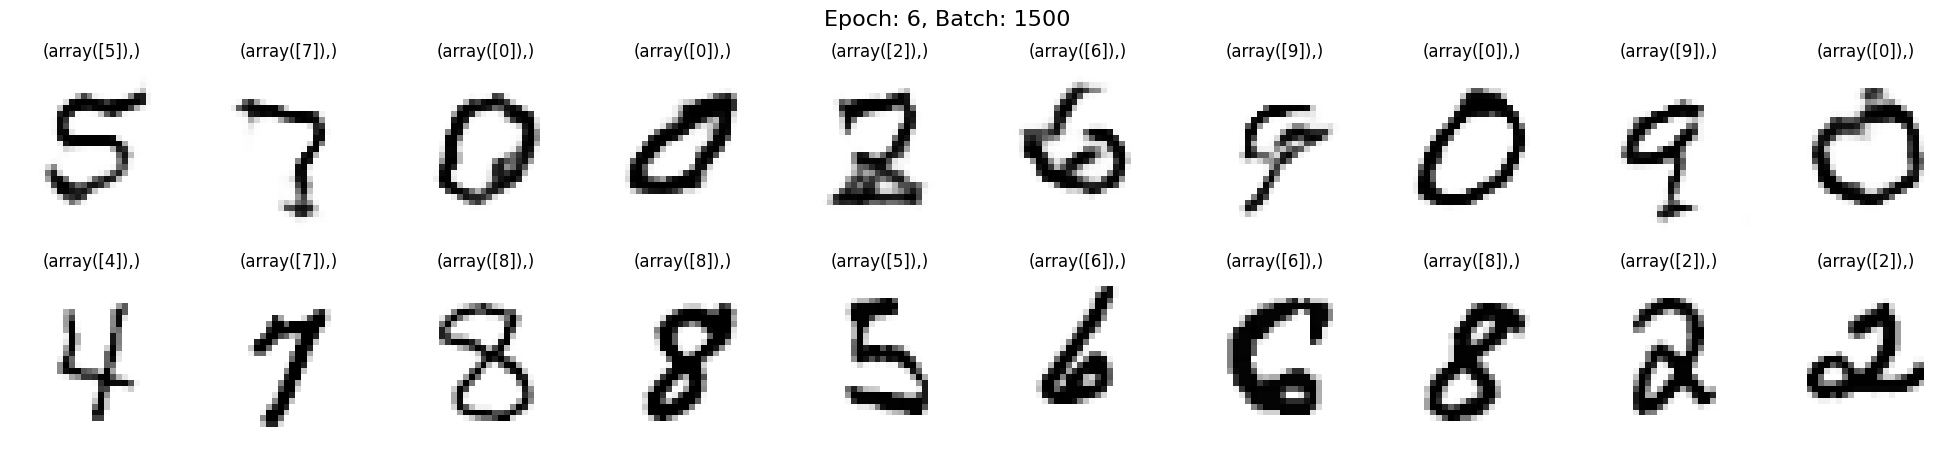

1550 [D loss: 0.6849,	 acc.: 56.25%]	[G loss: 0.8966]
1600 [D loss: 0.7174,	 acc.: 56.25%]	[G loss: 0.8636]
1650 [D loss: 0.7387,	 acc.: 50.00%]	[G loss: 0.8759]
1700 [D loss: 0.7430,	 acc.: 43.75%]	[G loss: 0.7062]
1750 [D loss: 0.6628,	 acc.: 65.62%]	[G loss: 0.7207]
1800 [D loss: 0.6748,	 acc.: 64.06%]	[G loss: 0.8464]
1850 [D loss: 0.6602,	 acc.: 60.94%]	[G loss: 0.7611]


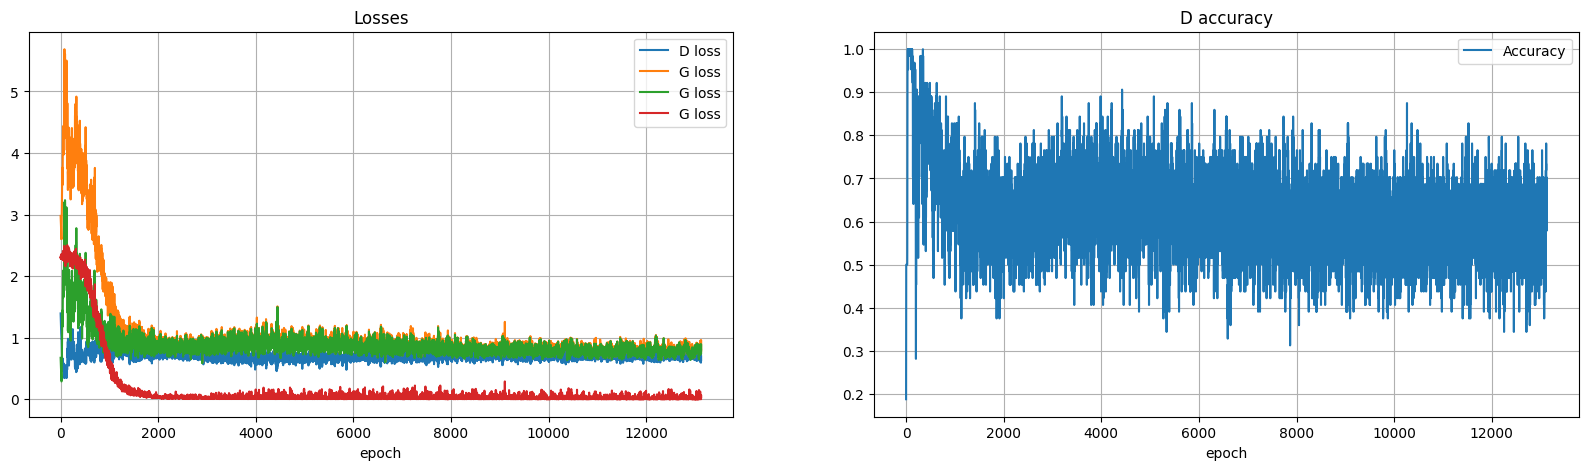

----EPOCH 7-----
0 [D loss: 0.6589,	 acc.: 60.94%]	[G loss: 0.8320]


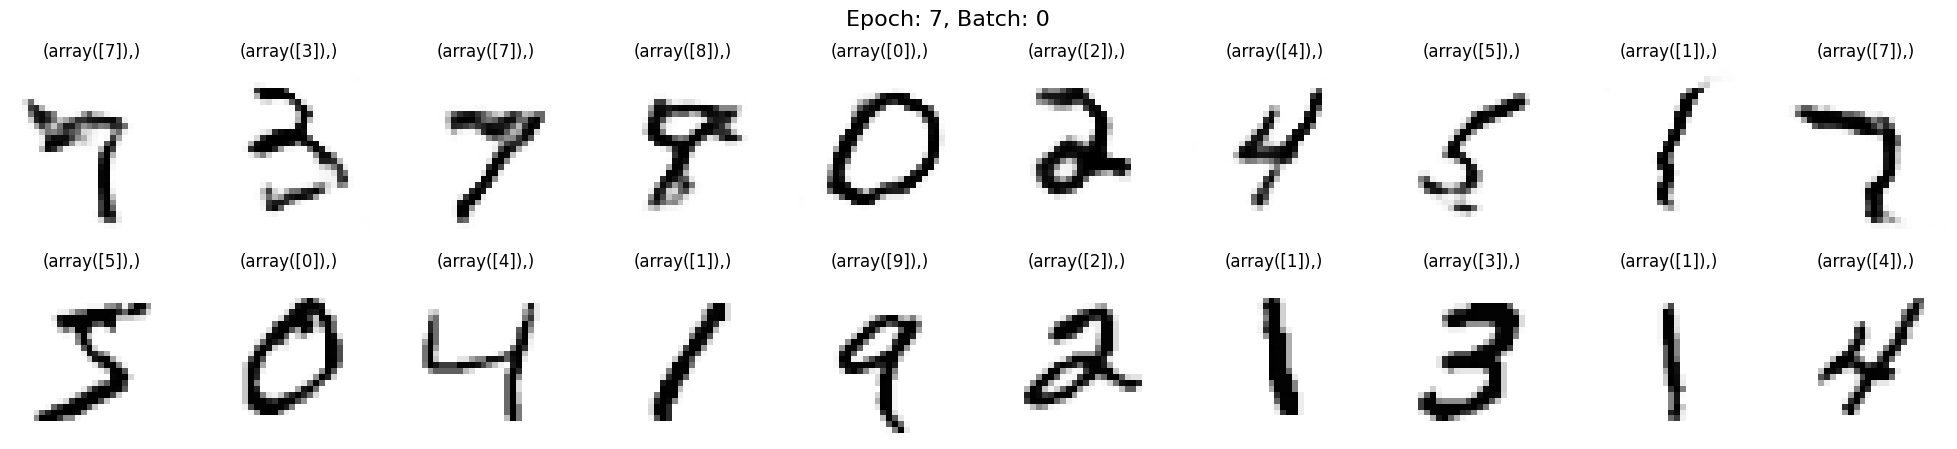

50 [D loss: 0.6917,	 acc.: 59.38%]	[G loss: 0.8276]
100 [D loss: 0.7231,	 acc.: 59.38%]	[G loss: 0.7226]
150 [D loss: 0.6735,	 acc.: 64.06%]	[G loss: 0.8541]
200 [D loss: 0.7453,	 acc.: 51.56%]	[G loss: 0.7811]
250 [D loss: 0.7262,	 acc.: 53.12%]	[G loss: 0.7948]
300 [D loss: 0.6933,	 acc.: 56.25%]	[G loss: 0.7522]
350 [D loss: 0.6715,	 acc.: 64.06%]	[G loss: 0.7526]
400 [D loss: 0.7623,	 acc.: 46.88%]	[G loss: 0.7655]
450 [D loss: 0.7046,	 acc.: 59.38%]	[G loss: 0.8137]
500 [D loss: 0.7413,	 acc.: 56.25%]	[G loss: 0.7039]


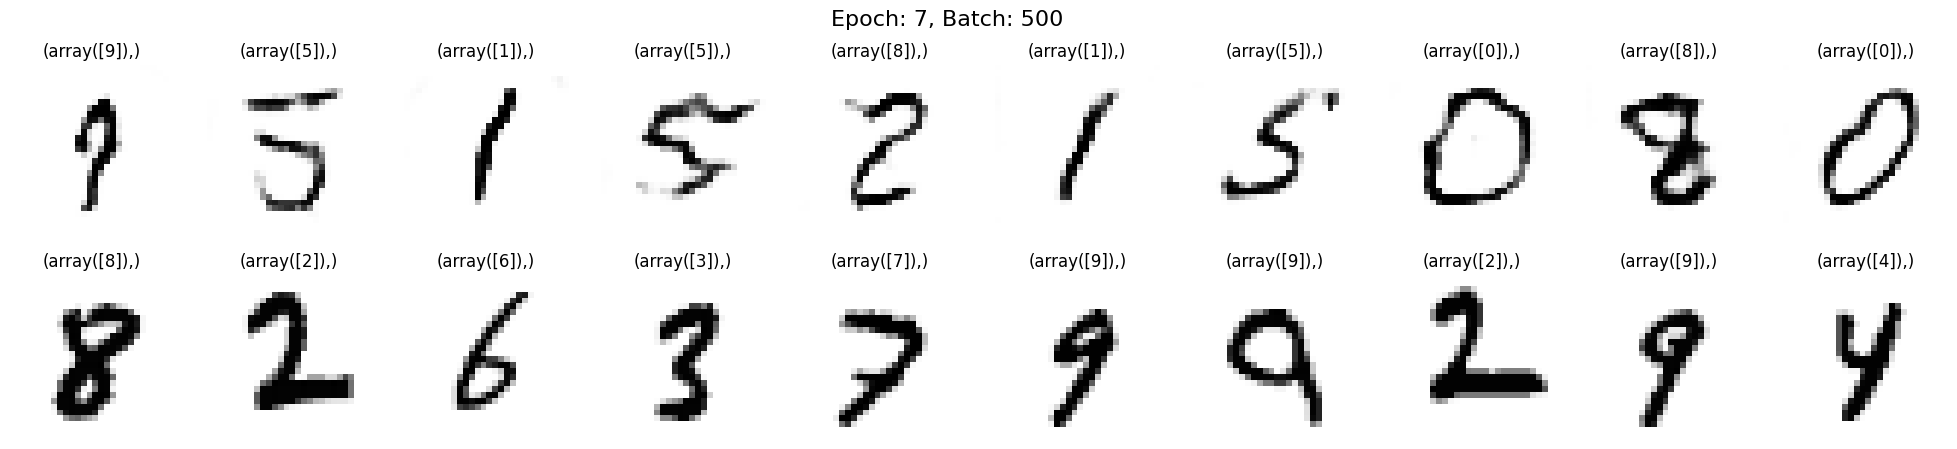

550 [D loss: 0.7196,	 acc.: 50.00%]	[G loss: 0.7773]
600 [D loss: 0.6743,	 acc.: 56.25%]	[G loss: 0.8220]
650 [D loss: 0.7125,	 acc.: 56.25%]	[G loss: 0.7779]
700 [D loss: 0.7359,	 acc.: 56.25%]	[G loss: 0.7299]
750 [D loss: 0.6899,	 acc.: 53.12%]	[G loss: 0.7622]
800 [D loss: 0.6574,	 acc.: 64.06%]	[G loss: 0.7940]
850 [D loss: 0.6951,	 acc.: 54.69%]	[G loss: 0.7432]
900 [D loss: 0.6814,	 acc.: 50.00%]	[G loss: 0.7469]
950 [D loss: 0.6714,	 acc.: 62.50%]	[G loss: 0.9427]
1000 [D loss: 0.8264,	 acc.: 43.75%]	[G loss: 0.8474]


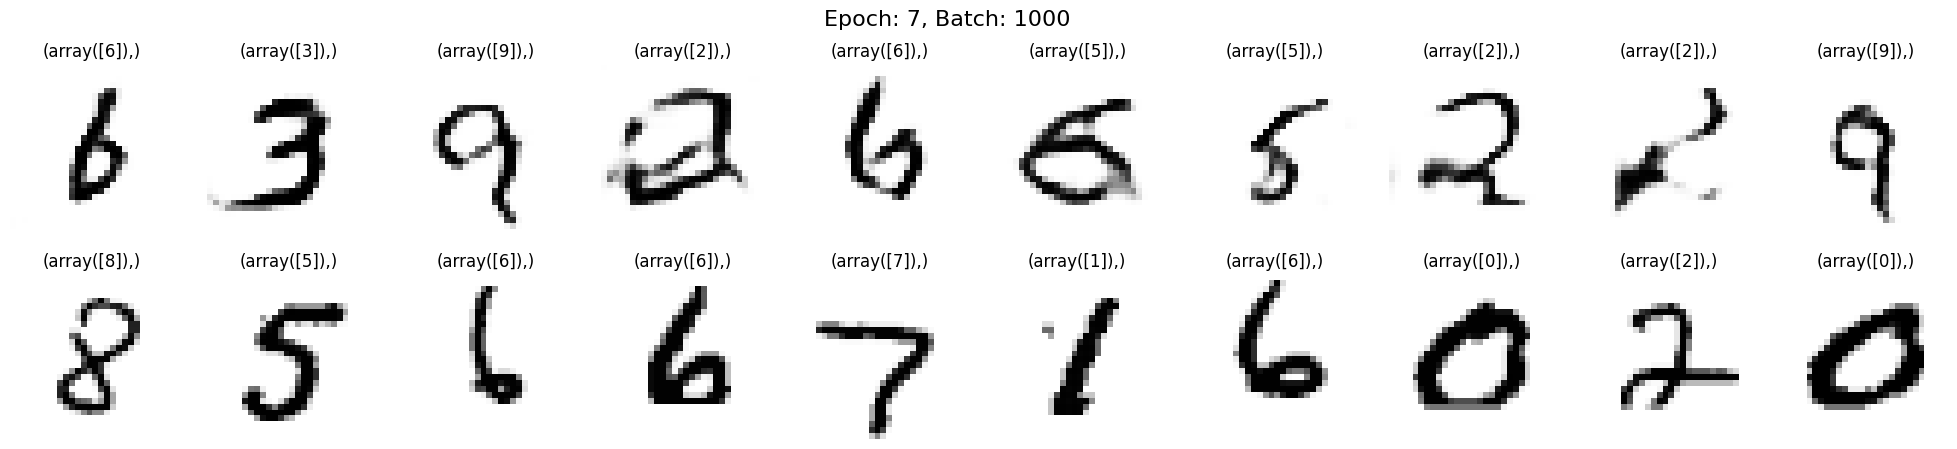

1050 [D loss: 0.6852,	 acc.: 56.25%]	[G loss: 0.7608]
1100 [D loss: 0.7137,	 acc.: 56.25%]	[G loss: 0.7648]
1150 [D loss: 0.7204,	 acc.: 60.94%]	[G loss: 0.8258]
1200 [D loss: 0.6849,	 acc.: 57.81%]	[G loss: 0.7868]
1250 [D loss: 0.6830,	 acc.: 57.81%]	[G loss: 0.8424]
1300 [D loss: 0.7092,	 acc.: 60.94%]	[G loss: 0.7237]
1350 [D loss: 0.7301,	 acc.: 54.69%]	[G loss: 0.7344]
1400 [D loss: 0.6998,	 acc.: 53.12%]	[G loss: 0.7631]
1450 [D loss: 0.7142,	 acc.: 56.25%]	[G loss: 0.7794]
1500 [D loss: 0.7013,	 acc.: 60.94%]	[G loss: 0.7211]


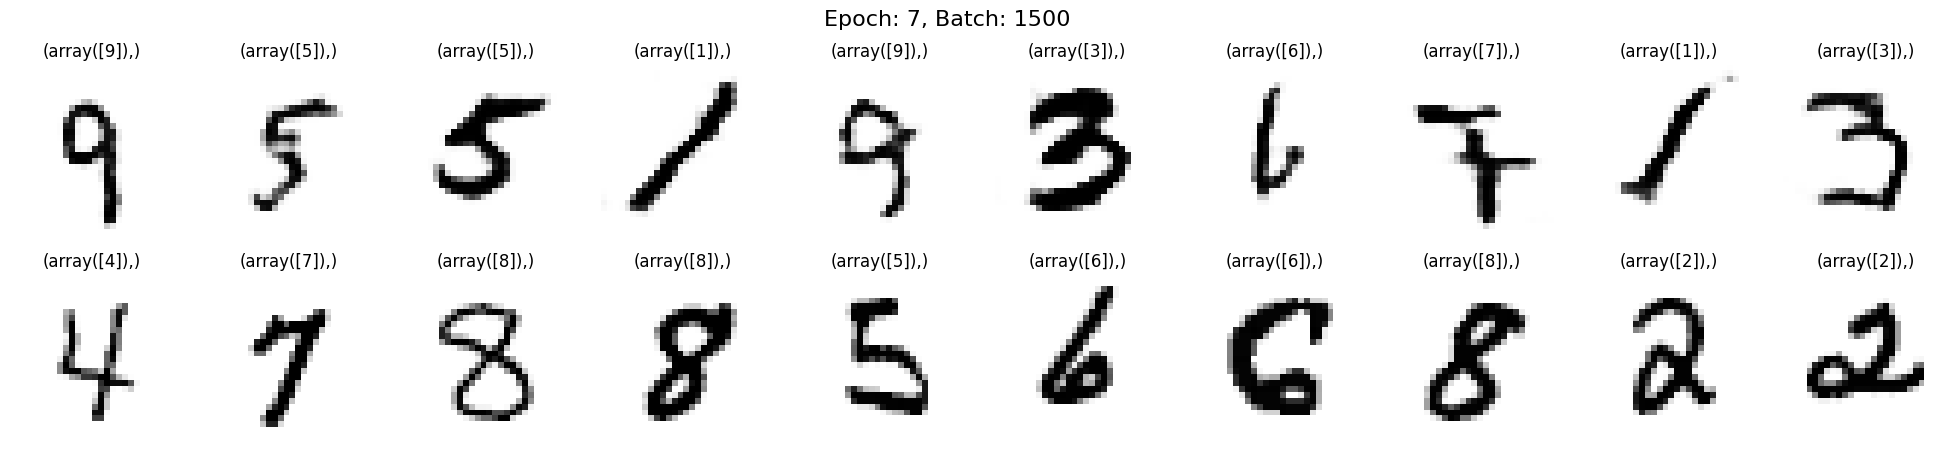

1550 [D loss: 0.7203,	 acc.: 59.38%]	[G loss: 0.7960]
1600 [D loss: 0.7456,	 acc.: 50.00%]	[G loss: 0.8256]
1650 [D loss: 0.7016,	 acc.: 64.06%]	[G loss: 0.7508]
1700 [D loss: 0.6881,	 acc.: 56.25%]	[G loss: 0.7568]
1750 [D loss: 0.6947,	 acc.: 53.12%]	[G loss: 0.7619]
1800 [D loss: 0.6771,	 acc.: 59.38%]	[G loss: 0.7406]
1850 [D loss: 0.6549,	 acc.: 65.62%]	[G loss: 0.8461]


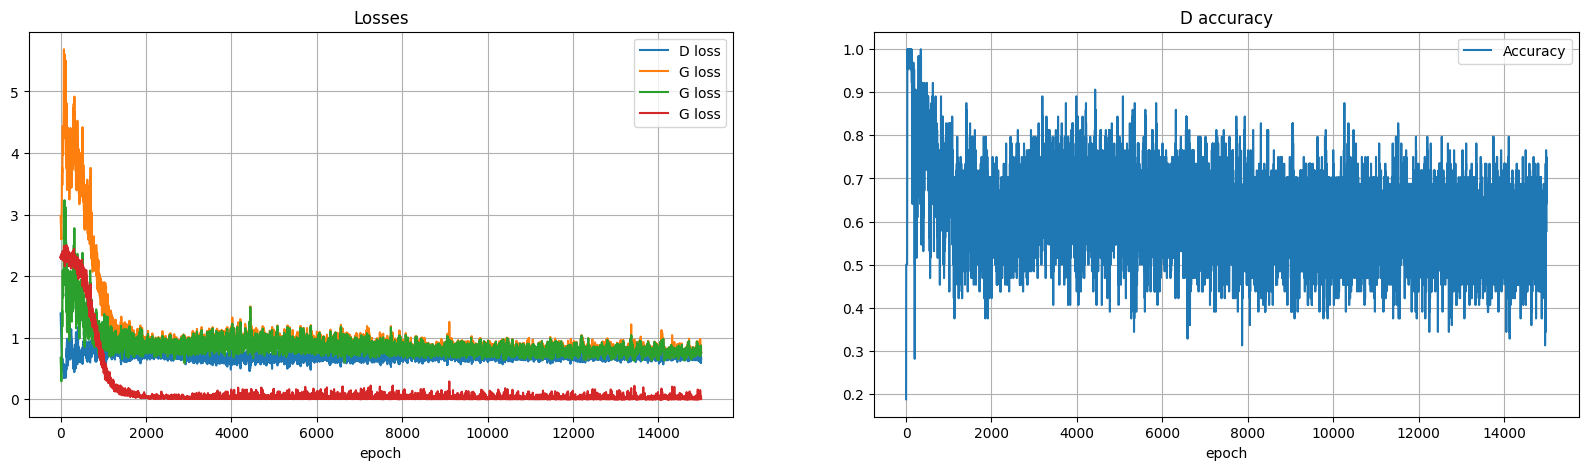

----EPOCH 8-----
0 [D loss: 0.7168,	 acc.: 54.69%]	[G loss: 0.7453]


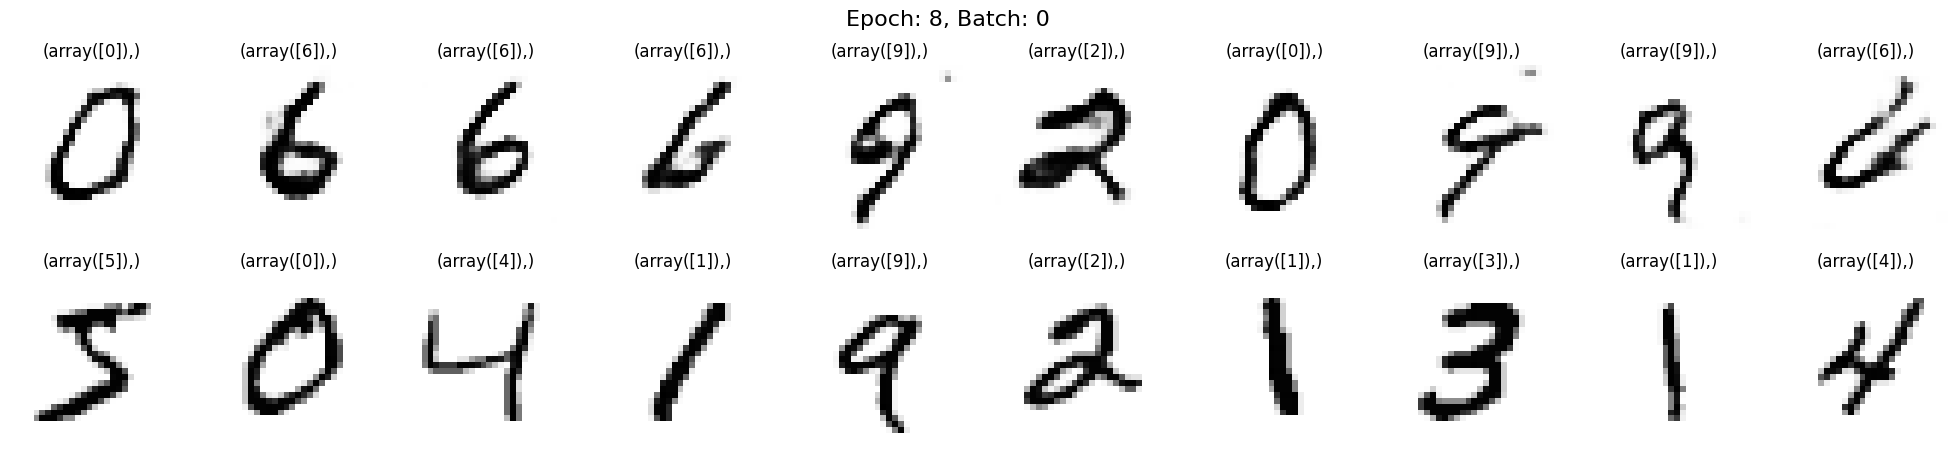

50 [D loss: 0.7016,	 acc.: 59.38%]	[G loss: 0.8792]
100 [D loss: 0.6732,	 acc.: 64.06%]	[G loss: 0.8184]
150 [D loss: 0.7068,	 acc.: 48.44%]	[G loss: 0.7837]
200 [D loss: 0.7437,	 acc.: 54.69%]	[G loss: 0.7259]
250 [D loss: 0.7279,	 acc.: 51.56%]	[G loss: 0.7956]
300 [D loss: 0.6762,	 acc.: 56.25%]	[G loss: 0.7304]
350 [D loss: 0.7136,	 acc.: 56.25%]	[G loss: 0.7642]
400 [D loss: 0.7181,	 acc.: 46.88%]	[G loss: 0.7627]
450 [D loss: 0.6849,	 acc.: 57.81%]	[G loss: 0.7892]
500 [D loss: 0.7593,	 acc.: 43.75%]	[G loss: 0.7442]


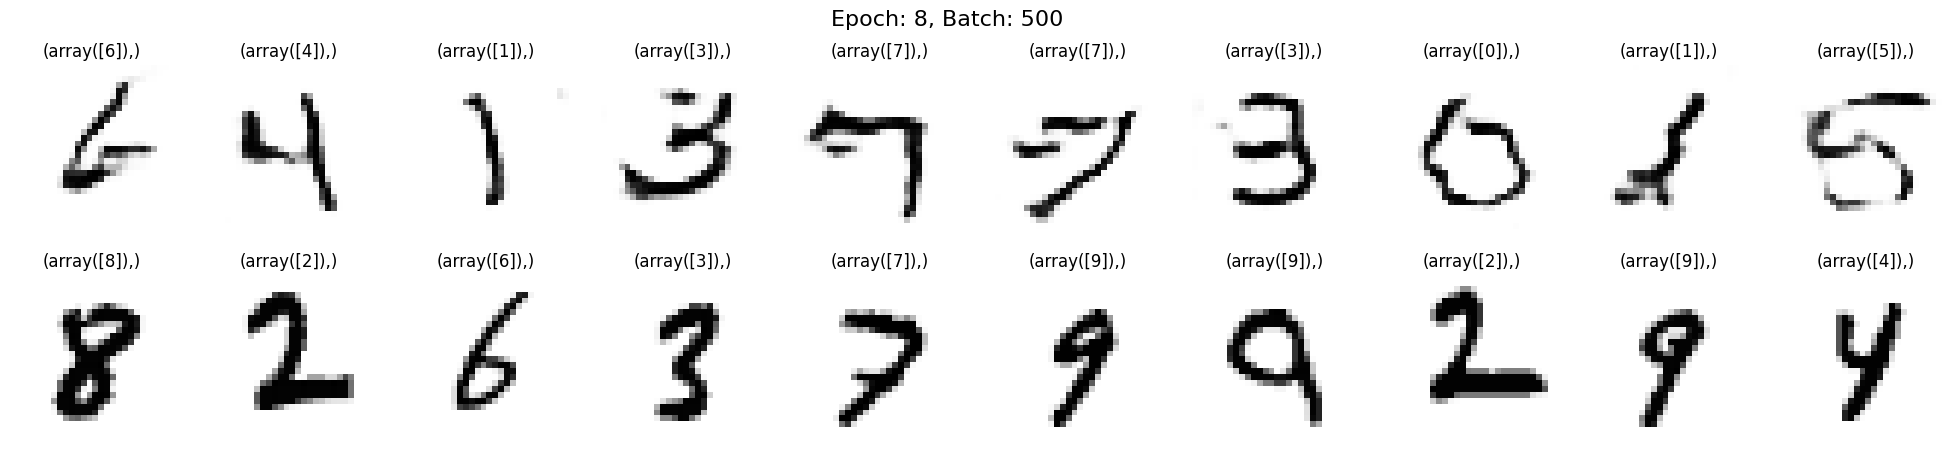

550 [D loss: 0.7063,	 acc.: 57.81%]	[G loss: 0.7092]
600 [D loss: 0.7259,	 acc.: 54.69%]	[G loss: 0.8040]
650 [D loss: 0.6988,	 acc.: 60.94%]	[G loss: 0.7498]
700 [D loss: 0.7186,	 acc.: 50.00%]	[G loss: 0.7549]
750 [D loss: 0.6811,	 acc.: 56.25%]	[G loss: 0.8075]
800 [D loss: 0.7242,	 acc.: 51.56%]	[G loss: 0.8288]
850 [D loss: 0.7084,	 acc.: 59.38%]	[G loss: 0.7707]
900 [D loss: 0.6880,	 acc.: 56.25%]	[G loss: 0.7477]
950 [D loss: 0.6953,	 acc.: 59.38%]	[G loss: 0.8713]
1000 [D loss: 0.7326,	 acc.: 46.88%]	[G loss: 0.8361]


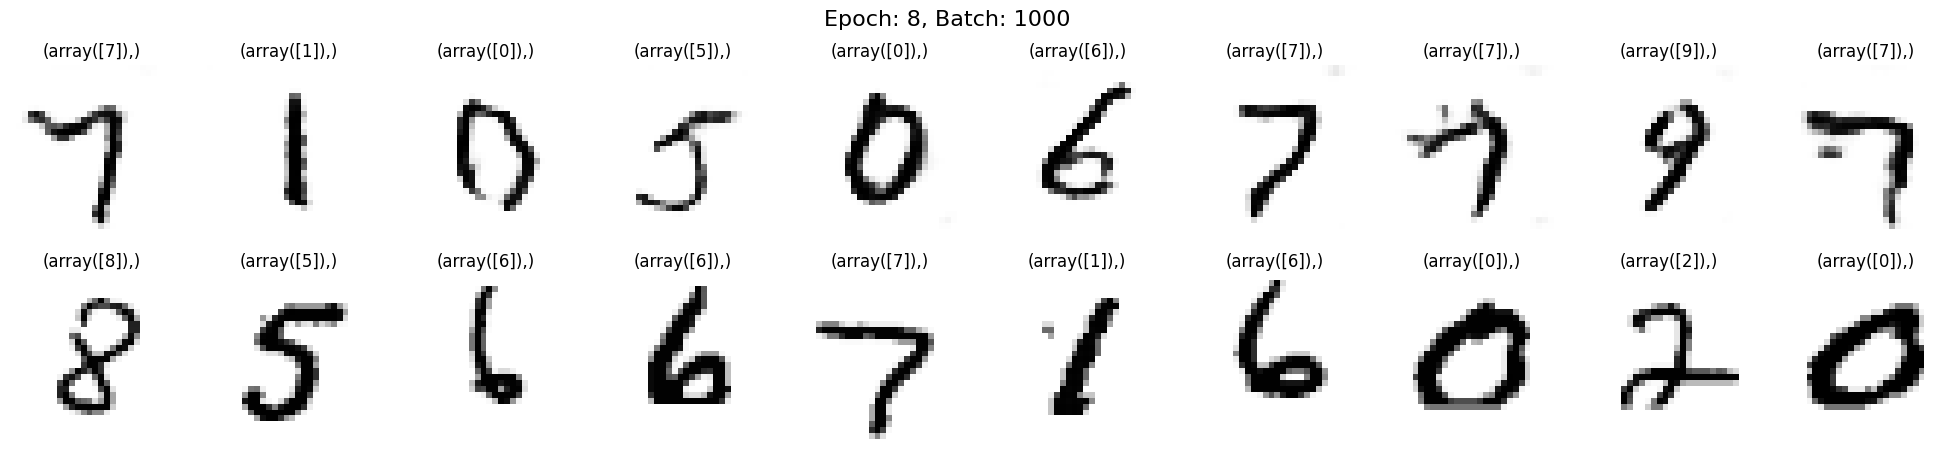

1050 [D loss: 0.6902,	 acc.: 54.69%]	[G loss: 0.7958]
1100 [D loss: 0.6833,	 acc.: 60.94%]	[G loss: 0.7797]
1150 [D loss: 0.6892,	 acc.: 59.38%]	[G loss: 0.7943]
1200 [D loss: 0.7203,	 acc.: 43.75%]	[G loss: 0.7240]
1250 [D loss: 0.6972,	 acc.: 62.50%]	[G loss: 0.7938]
1300 [D loss: 0.6569,	 acc.: 68.75%]	[G loss: 0.8704]
1350 [D loss: 0.7311,	 acc.: 51.56%]	[G loss: 0.7728]
1400 [D loss: 0.7198,	 acc.: 46.88%]	[G loss: 0.7761]
1450 [D loss: 0.7201,	 acc.: 53.12%]	[G loss: 0.7880]
1500 [D loss: 0.6968,	 acc.: 51.56%]	[G loss: 0.7465]


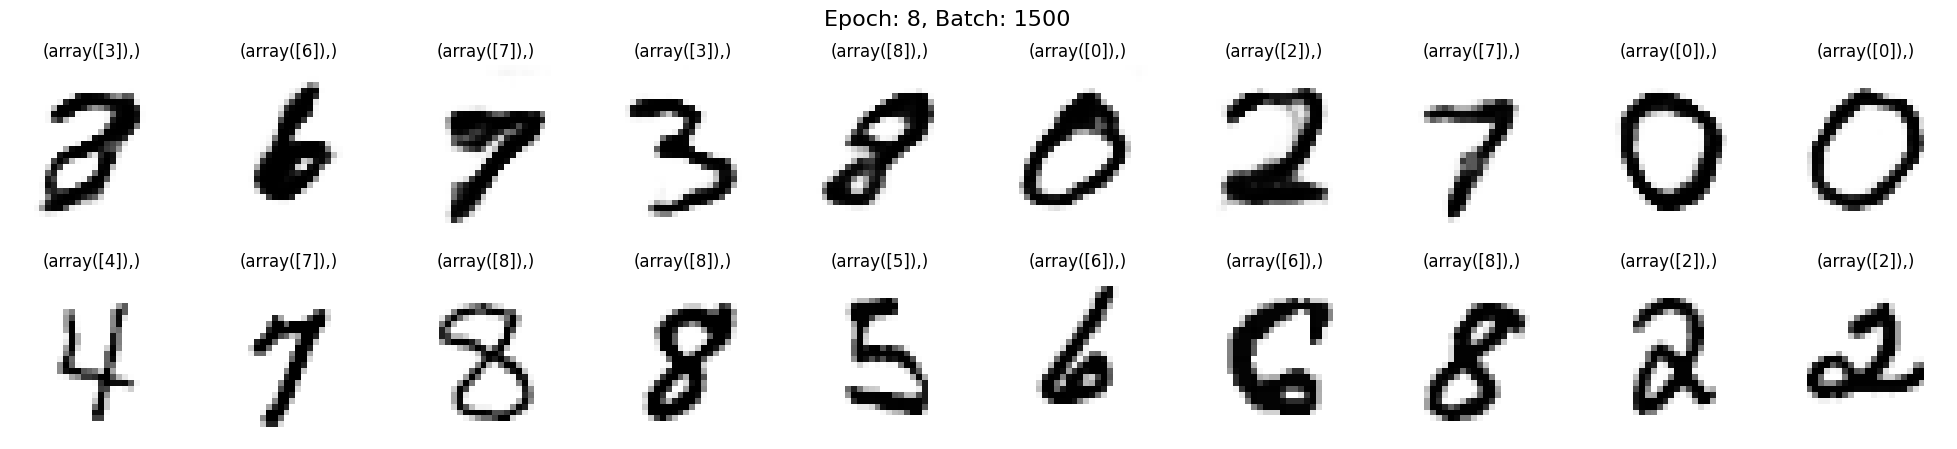

1550 [D loss: 0.6652,	 acc.: 57.81%]	[G loss: 0.7998]
1600 [D loss: 0.6601,	 acc.: 65.62%]	[G loss: 0.8616]
1650 [D loss: 0.7099,	 acc.: 54.69%]	[G loss: 0.7663]
1700 [D loss: 0.6913,	 acc.: 57.81%]	[G loss: 0.7390]
1750 [D loss: 0.6333,	 acc.: 76.56%]	[G loss: 0.8004]
1800 [D loss: 0.7229,	 acc.: 53.12%]	[G loss: 0.7987]
1850 [D loss: 0.7428,	 acc.: 56.25%]	[G loss: 0.7964]


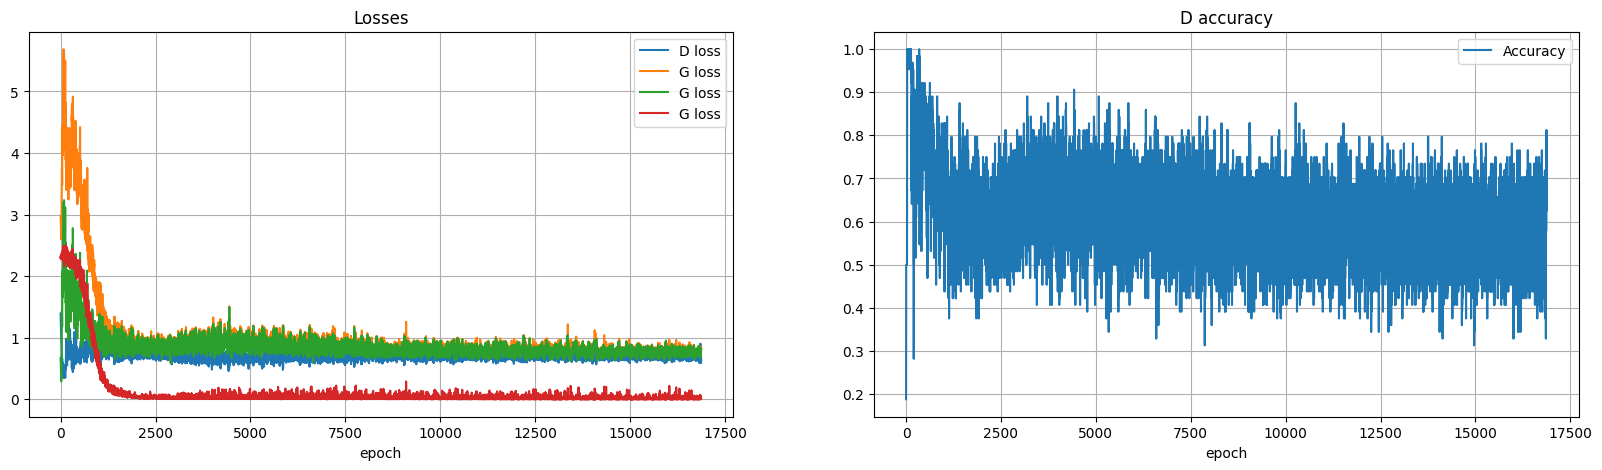

----EPOCH 9-----
0 [D loss: 0.6925,	 acc.: 57.81%]	[G loss: 0.8411]


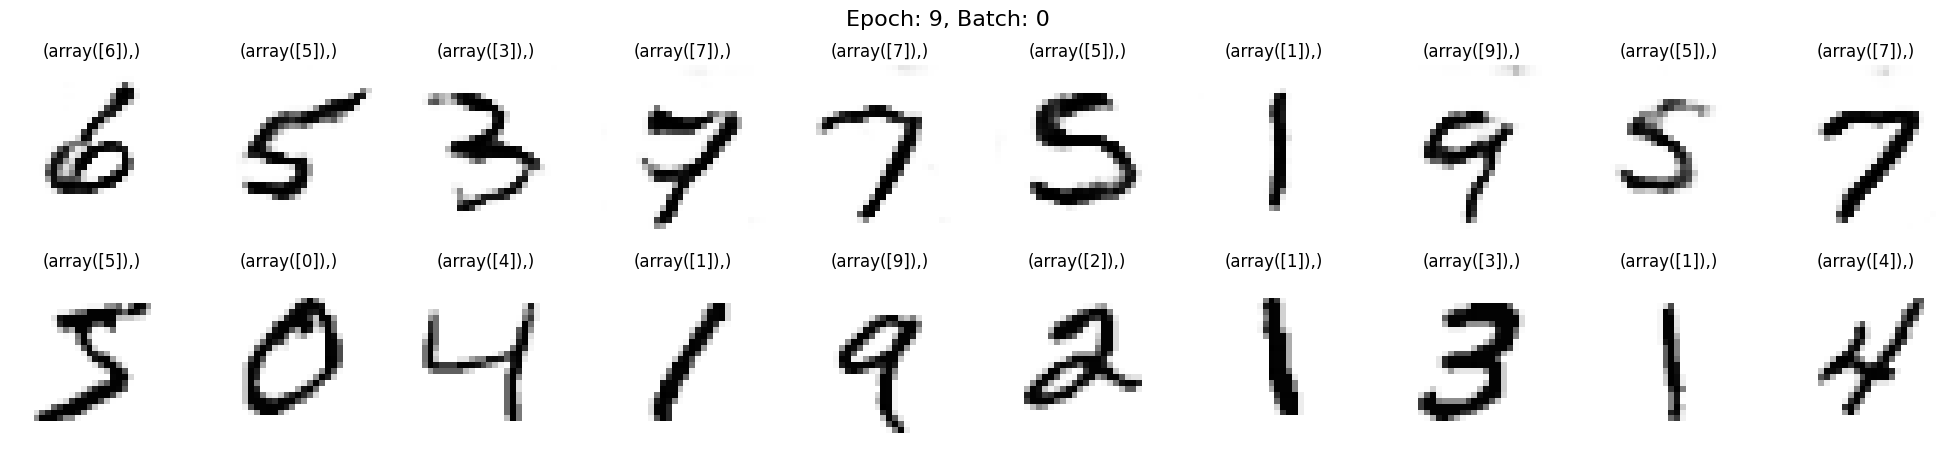

50 [D loss: 0.7006,	 acc.: 53.12%]	[G loss: 0.8136]
100 [D loss: 0.7230,	 acc.: 51.56%]	[G loss: 0.7645]
150 [D loss: 0.7209,	 acc.: 54.69%]	[G loss: 0.7489]
200 [D loss: 0.6642,	 acc.: 68.75%]	[G loss: 0.8233]
250 [D loss: 0.6924,	 acc.: 56.25%]	[G loss: 0.8067]
300 [D loss: 0.7046,	 acc.: 64.06%]	[G loss: 0.7293]
350 [D loss: 0.6890,	 acc.: 56.25%]	[G loss: 0.7906]
400 [D loss: 0.7152,	 acc.: 46.88%]	[G loss: 0.7774]
450 [D loss: 0.7038,	 acc.: 53.12%]	[G loss: 0.7759]
500 [D loss: 0.7471,	 acc.: 51.56%]	[G loss: 0.6762]


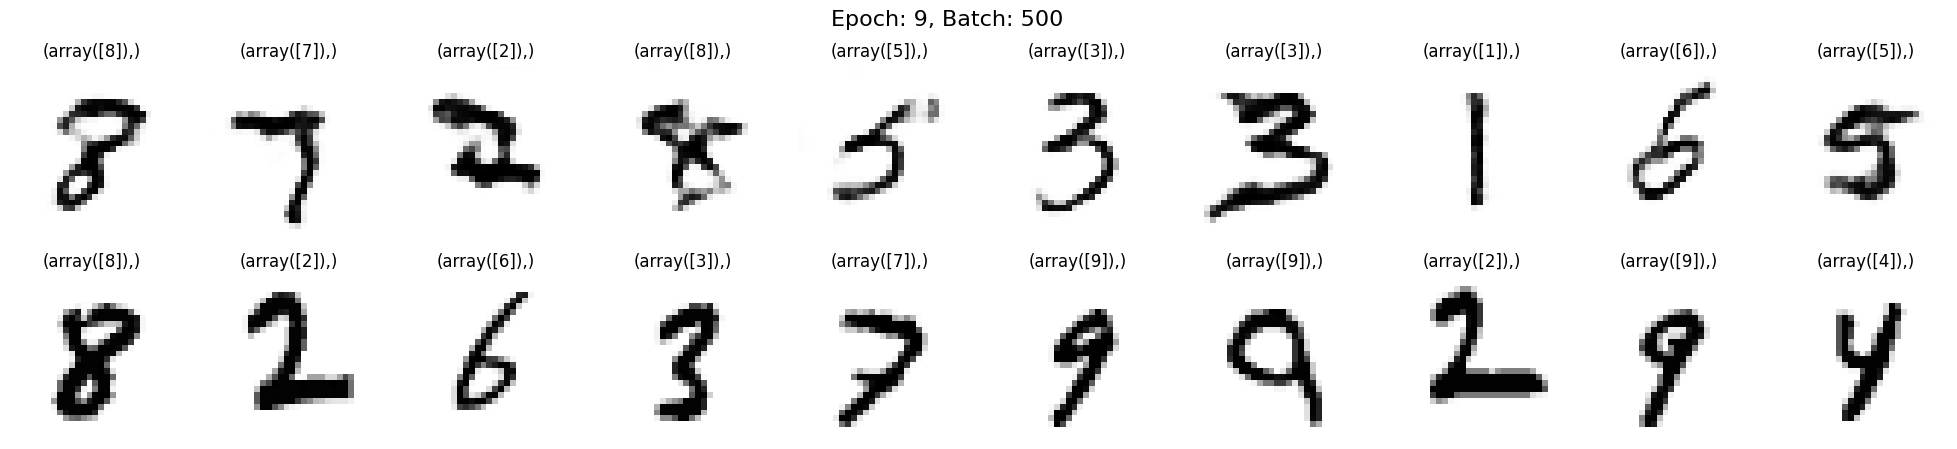

550 [D loss: 0.6837,	 acc.: 57.81%]	[G loss: 0.7779]
600 [D loss: 0.6803,	 acc.: 57.81%]	[G loss: 0.8038]
650 [D loss: 0.7192,	 acc.: 54.69%]	[G loss: 0.7755]
700 [D loss: 0.7456,	 acc.: 46.88%]	[G loss: 0.7871]
750 [D loss: 0.6198,	 acc.: 79.69%]	[G loss: 0.7696]
800 [D loss: 0.6964,	 acc.: 53.12%]	[G loss: 0.7101]
850 [D loss: 0.6962,	 acc.: 51.56%]	[G loss: 0.7307]
900 [D loss: 0.7061,	 acc.: 57.81%]	[G loss: 0.7482]
950 [D loss: 0.7090,	 acc.: 50.00%]	[G loss: 0.7597]
1000 [D loss: 0.7865,	 acc.: 43.75%]	[G loss: 0.8020]


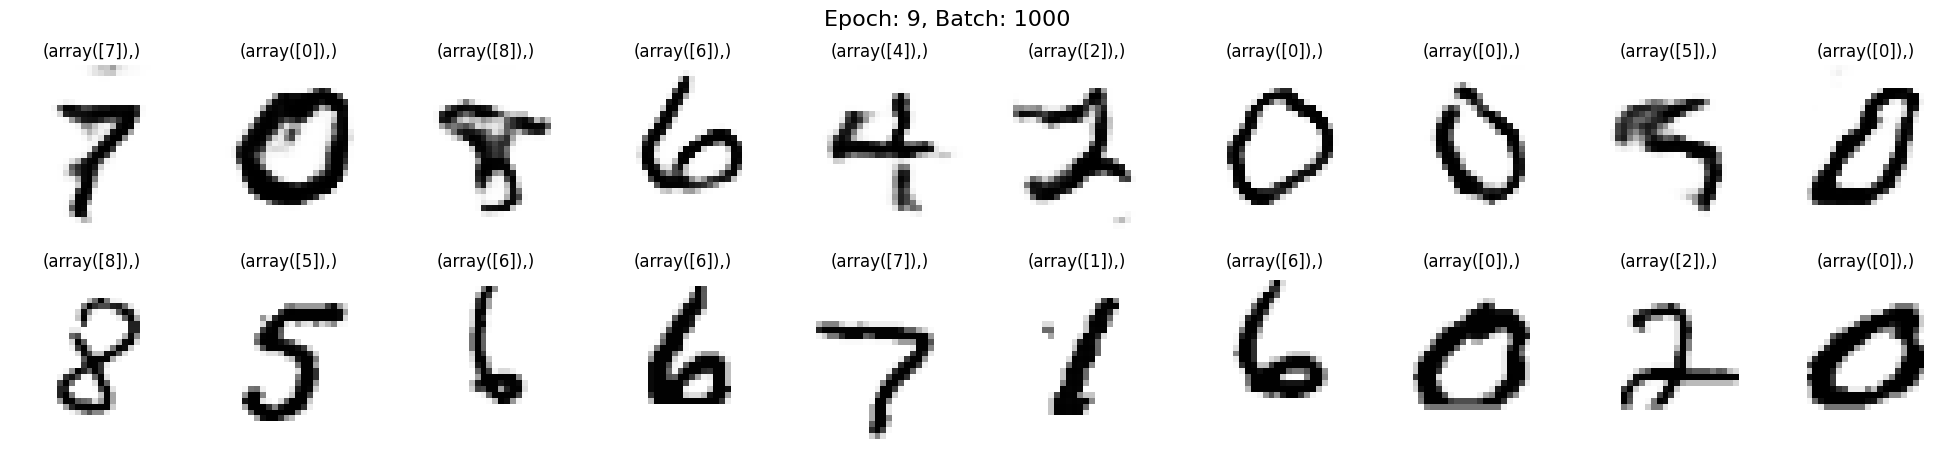

1050 [D loss: 0.7161,	 acc.: 51.56%]	[G loss: 0.8093]
1100 [D loss: 0.6963,	 acc.: 54.69%]	[G loss: 0.7284]
1150 [D loss: 0.7277,	 acc.: 48.44%]	[G loss: 0.6871]
1200 [D loss: 0.6803,	 acc.: 62.50%]	[G loss: 0.7312]
1250 [D loss: 0.7131,	 acc.: 51.56%]	[G loss: 0.8463]
1300 [D loss: 0.6939,	 acc.: 59.38%]	[G loss: 0.8088]
1350 [D loss: 0.6789,	 acc.: 60.94%]	[G loss: 0.7967]
1400 [D loss: 0.6988,	 acc.: 54.69%]	[G loss: 0.7257]
1450 [D loss: 0.7148,	 acc.: 62.50%]	[G loss: 0.7716]
1500 [D loss: 0.6778,	 acc.: 62.50%]	[G loss: 0.7617]


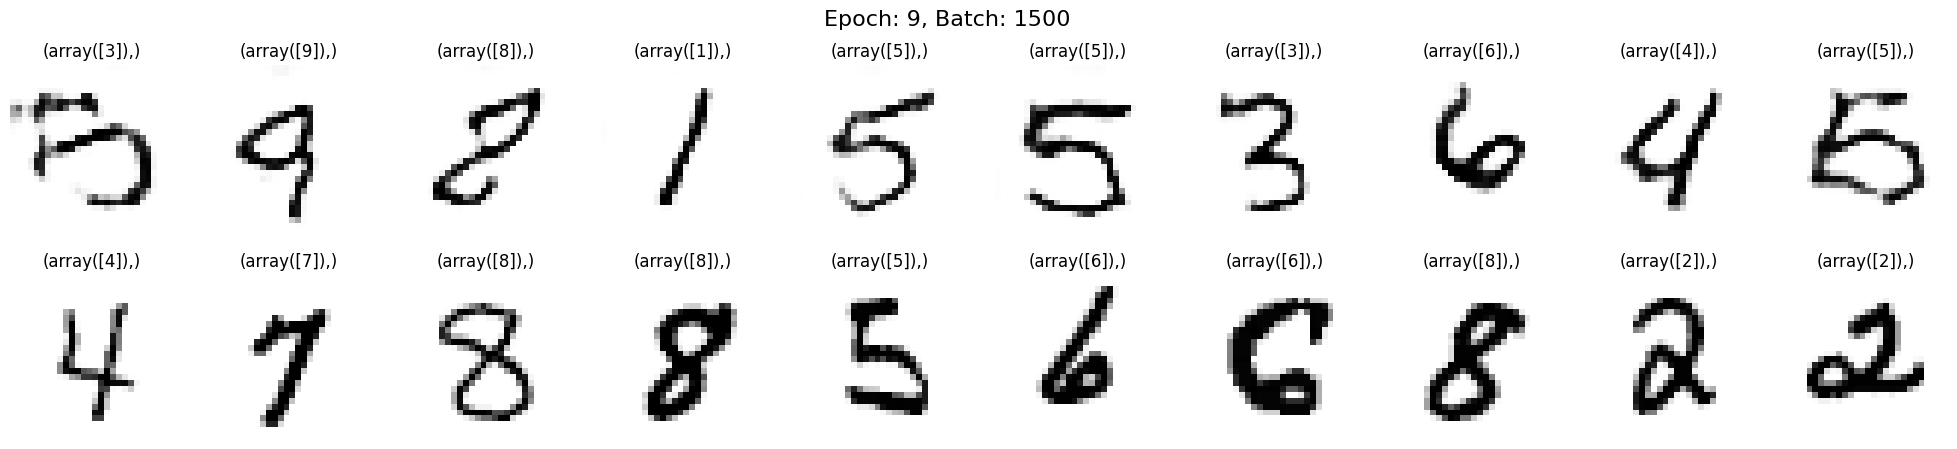

1550 [D loss: 0.6871,	 acc.: 57.81%]	[G loss: 0.8107]
1600 [D loss: 0.7582,	 acc.: 42.19%]	[G loss: 0.6800]
1650 [D loss: 0.7234,	 acc.: 54.69%]	[G loss: 0.7526]
1700 [D loss: 0.6703,	 acc.: 62.50%]	[G loss: 0.7496]
1750 [D loss: 0.6866,	 acc.: 59.38%]	[G loss: 0.7973]
1800 [D loss: 0.6634,	 acc.: 60.94%]	[G loss: 0.8842]
1850 [D loss: 0.6947,	 acc.: 62.50%]	[G loss: 0.7768]


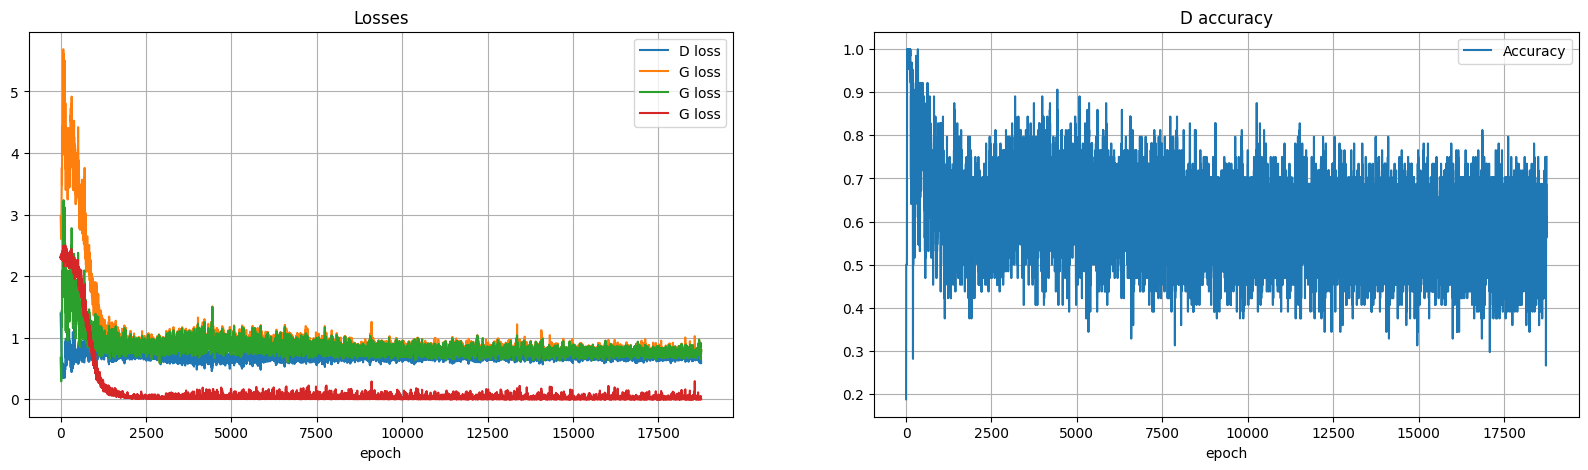

In [ ]:
train(X_train, y_train, generator, discriminator, combined, epochs=10, batch_size=32, sample_interval=100)

> Sinceramente es complicado mejorar el rendimiento del primer train, he intentado diferentes modelos y este es el único que rivaliza con él. No sabría decir si es mejor, peor o igual ya que si comparamos epoch a veces le supera y en otras ocasiones se ve superedo por el inicial, pero me ha parecido interesante el resultado y por eso he decidido añadirlo al cuaderno. Al fin y al cabo en el primer intento estoy utilizando una arquitectura similar a la mejor DCGAN y por ello creo que los resultados son difiles de superar.

> Como conclusión, puedo asegurar que las GAN son muy poderosas pero también difíciles de entrenar. Creo que he conseguido unos resultados bastante aceptables, hay muchos epoch donde cuesta mucho diferenciar cuál es real y cuál es el generado.

---

Creado por **Guillermo Iglesias** (guillermo.iglesias@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">